In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
cm_target

['NACA0018cm_blade1.csv',
 'case1cm_blade1.csv',
 'case2cm_blade1.csv',
 'case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [10]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
#     hh = generate_h(n_beta, t_len, normalize)
#     bb = generate_beta(n_beta, t_len, normalize)
#     total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    x = t
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [11]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
        cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 15, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [12]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [13]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>10:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [14]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

    beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [15]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [16]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [17]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [18]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target[1:3], n_beta, t_len, normalize=True)

Dimension - time and Cm:  (10000, 2)
Dimension - x:  (10000, 1)
Dimension - y:  (10000, 1)


In [19]:
x -=10

In [20]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [21]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [22]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=1)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [23]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               512       
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [25]:
model_directory = "D:\\TrainedModels\\20221227_flap1_2_randomState50"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [26]:
ckpt_name = model_directory + "20221227unsteadyPrediction_MLP_flap1_2_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_randomState50_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, min_delta=1e-07,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-8, min_lr=1e-06, verbose=1)

In [27]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [28]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/6 [====>.........................] - ETA: 5s - loss: 0.1912 - rmse: 0.4372
Epoch 1: val_loss improved from inf to 0.11935, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 1s 46ms/step - loss: 0.1568 - rmse: 0.3959 - val_loss: 0.1193 - val_rmse: 0.3453 - lr: 1.0000e-04
Epoch 2/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.1224 - rmse: 0.3498
Epoch 2: val_loss improved from 0.11935 to 0.09959, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 18ms/step - loss: 0.1098 - rmse: 0.3313 - val_loss: 0.0996 - val_rmse: 0.3154 - lr: 1.0000e-04
Epoch 3/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.1028 - rmse: 0.3204
Epoch 3: val_loss did not i

6/6 [==============================] - 0s 19ms/step - loss: 0.0701 - rmse: 0.2645 - val_loss: 0.0692 - val_rmse: 0.2629 - lr: 1.0000e-04
Epoch 21/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0687 - rmse: 0.2619
Epoch 21: val_loss improved from 0.06921 to 0.06897, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 19ms/step - loss: 0.0692 - rmse: 0.2629 - val_loss: 0.0690 - val_rmse: 0.2624 - lr: 1.0000e-04
Epoch 22/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0721 - rmse: 0.2682
Epoch 22: val_loss improved from 0.06897 to 0.06876, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 21ms/step - loss: 0.0691 - rmse: 0.2626 - val_loss: 0.0688 - val_rms

Epoch 42/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0689 - rmse: 0.2624
Epoch 42: val_loss improved from 0.06524 to 0.06489, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 21ms/step - loss: 0.0658 - rmse: 0.2562 - val_loss: 0.0649 - val_rmse: 0.2545 - lr: 1.0000e-04
Epoch 43/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0677 - rmse: 0.2600
Epoch 43: val_loss improved from 0.06489 to 0.06470, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 19ms/step - loss: 0.0647 - rmse: 0.2542 - val_loss: 0.0647 - val_rmse: 0.2542 - lr: 1.0000e-04
Epoch 44/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0696 - rmse: 0.2636
Epoch 44: val_loss

6/6 [==============================] - 0s 22ms/step - loss: 0.0621 - rmse: 0.2491 - val_loss: 0.0612 - val_rmse: 0.2472 - lr: 1.0000e-04
Epoch 63/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0705 - rmse: 0.2653
Epoch 63: val_loss improved from 0.06122 to 0.06094, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 22ms/step - loss: 0.0616 - rmse: 0.2480 - val_loss: 0.0609 - val_rmse: 0.2466 - lr: 1.0000e-04
Epoch 64/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0572 - rmse: 0.2389
Epoch 64: val_loss improved from 0.06094 to 0.06092, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0622 - rmse: 0.2491 - val_loss: 0.0609 - val_rms

Epoch 84/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0535 - rmse: 0.2310
Epoch 84: val_loss improved from 0.05800 to 0.05761, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 21ms/step - loss: 0.0596 - rmse: 0.2439 - val_loss: 0.0576 - val_rmse: 0.2398 - lr: 1.0000e-04
Epoch 85/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0552 - rmse: 0.2347
Epoch 85: val_loss did not improve from 0.05761
6/6 [==============================] - 0s 13ms/step - loss: 0.0598 - rmse: 0.2444 - val_loss: 0.0600 - val_rmse: 0.2448 - lr: 1.0000e-04
Epoch 86/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0586 - rmse: 0.2419
Epoch 86: val_loss improved from 0.05761 to 0.05751, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256unit

Epoch 107/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0576 - rmse: 0.2397
Epoch 107: val_loss improved from 0.05565 to 0.05560, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 29ms/step - loss: 0.0569 - rmse: 0.2383 - val_loss: 0.0556 - val_rmse: 0.2356 - lr: 1.0000e-04
Epoch 108/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0590 - rmse: 0.2427
Epoch 108: val_loss improved from 0.05560 to 0.05552, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 22ms/step - loss: 0.0571 - rmse: 0.2388 - val_loss: 0.0555 - val_rmse: 0.2354 - lr: 1.0000e-04
Epoch 109/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0520 - rmse: 0.2277
Epoch 109: va

6/6 [==============================] - 0s 25ms/step - loss: 0.0565 - rmse: 0.2374 - val_loss: 0.0551 - val_rmse: 0.2346 - lr: 1.0000e-04
Epoch 133/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0563 - rmse: 0.2371
Epoch 133: val_loss did not improve from 0.05512
6/6 [==============================] - 0s 13ms/step - loss: 0.0563 - rmse: 0.2372 - val_loss: 0.0554 - val_rmse: 0.2352 - lr: 1.0000e-04
Epoch 134/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0579 - rmse: 0.2404
Epoch 134: val_loss improved from 0.05512 to 0.05512, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 29ms/step - loss: 0.0566 - rmse: 0.2377 - val_loss: 0.0551 - val_rmse: 0.2346 - lr: 1.0000e-04
Epoch 135/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0543 - rmse: 0.2327
Epoch 135: val_loss did not improve from 0.0

Epoch 158/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0521 - rmse: 0.2281
Epoch 158: val_loss did not improve from 0.05497
6/6 [==============================] - 0s 13ms/step - loss: 0.0552 - rmse: 0.2347 - val_loss: 0.0550 - val_rmse: 0.2344 - lr: 1.0000e-04
Epoch 159/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0585 - rmse: 0.2416
Epoch 159: val_loss did not improve from 0.05497
6/6 [==============================] - 0s 14ms/step - loss: 0.0557 - rmse: 0.2357 - val_loss: 0.0555 - val_rmse: 0.2354 - lr: 1.0000e-04
Epoch 160/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0596 - rmse: 0.2439
Epoch 160: val_loss did not improve from 0.05497
6/6 [==============================] - 0s 14ms/step - loss: 0.0567 - rmse: 0.2379 - val_loss: 0.0550 - val_rmse: 0.2344 - lr: 1.0000e-04
Epoch 161/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0540 - rmse: 0.2321
Epoch 161: val_loss improved from 0.05497 to 0.05491, saving model to 

6/6 [==============================] - 0s 25ms/step - loss: 0.0560 - rmse: 0.2364 - val_loss: 0.0547 - val_rmse: 0.2337 - lr: 1.0000e-04
Epoch 184/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0549 - rmse: 0.2342
Epoch 184: val_loss did not improve from 0.05472
6/6 [==============================] - 0s 14ms/step - loss: 0.0555 - rmse: 0.2355 - val_loss: 0.0548 - val_rmse: 0.2339 - lr: 1.0000e-04
Epoch 185/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0590 - rmse: 0.2427
Epoch 185: val_loss did not improve from 0.05472
6/6 [==============================] - 0s 14ms/step - loss: 0.0564 - rmse: 0.2372 - val_loss: 0.0547 - val_rmse: 0.2338 - lr: 1.0000e-04
Epoch 186/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0546 - rmse: 0.2336
Epoch 186: val_loss did not improve from 0.05472
6/6 [==============================] - 0s 13ms/step - loss: 0.0556 - rmse: 0.2355 - val_loss: 0.0548 - val_rmse: 0.2340 - lr: 1.0000e-04
Epoch 187/10000
1/6 [====>

1/6 [====>.........................] - ETA: 0s - loss: 0.0590 - rmse: 0.2427
Epoch 209: val_loss did not improve from 0.05438
6/6 [==============================] - 0s 13ms/step - loss: 0.0556 - rmse: 0.2356 - val_loss: 0.0545 - val_rmse: 0.2332 - lr: 1.0000e-04
Epoch 210/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0560 - rmse: 0.2364
Epoch 210: val_loss did not improve from 0.05438
6/6 [==============================] - 0s 14ms/step - loss: 0.0560 - rmse: 0.2365 - val_loss: 0.0546 - val_rmse: 0.2334 - lr: 1.0000e-04
Epoch 211/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0531 - rmse: 0.2301
Epoch 211: val_loss did not improve from 0.05438
6/6 [==============================] - 0s 13ms/step - loss: 0.0552 - rmse: 0.2348 - val_loss: 0.0546 - val_rmse: 0.2335 - lr: 1.0000e-04
Epoch 212/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0564 - rmse: 0.2374
Epoch 212: val_loss improved from 0.05438 to 0.05436, saving model to D:\TrainedModels

6/6 [==============================] - 0s 24ms/step - loss: 0.0555 - rmse: 0.2354 - val_loss: 0.0540 - val_rmse: 0.2322 - lr: 1.0000e-04
Epoch 235/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0551 - rmse: 0.2346
Epoch 235: val_loss improved from 0.05401 to 0.05400, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 25ms/step - loss: 0.0538 - rmse: 0.2318 - val_loss: 0.0540 - val_rmse: 0.2322 - lr: 1.0000e-04
Epoch 236/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0517 - rmse: 0.2272
Epoch 236: val_loss did not improve from 0.05400
6/6 [==============================] - 0s 14ms/step - loss: 0.0551 - rmse: 0.2346 - val_loss: 0.0544 - val_rmse: 0.2331 - lr: 1.0000e-04
Epoch 237/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0548 - rmse: 0.2340
Epoch 237: val_loss did not improve from 0.0

6/6 [==============================] - 0s 25ms/step - loss: 0.0541 - rmse: 0.2325 - val_loss: 0.0535 - val_rmse: 0.2311 - lr: 1.0000e-04
Epoch 259/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0527 - rmse: 0.2293
Epoch 259: val_loss did not improve from 0.05349
6/6 [==============================] - 0s 13ms/step - loss: 0.0556 - rmse: 0.2355 - val_loss: 0.0537 - val_rmse: 0.2316 - lr: 1.0000e-04
Epoch 260/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0540 - rmse: 0.2323
Epoch 260: val_loss did not improve from 0.05349
6/6 [==============================] - 0s 13ms/step - loss: 0.0538 - rmse: 0.2317 - val_loss: 0.0544 - val_rmse: 0.2331 - lr: 1.0000e-04
Epoch 261/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0582 - rmse: 0.2410
Epoch 261: val_loss did not improve from 0.05349
6/6 [==============================] - 0s 13ms/step - loss: 0.0547 - rmse: 0.2337 - val_loss: 0.0536 - val_rmse: 0.2312 - lr: 1.0000e-04
Epoch 262/10000
1/6 [====>

6/6 [==============================] - 0s 24ms/step - loss: 0.0539 - rmse: 0.2320 - val_loss: 0.0528 - val_rmse: 0.2297 - lr: 1.0000e-04
Epoch 284/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0508 - rmse: 0.2251
Epoch 284: val_loss did not improve from 0.05284
6/6 [==============================] - 0s 13ms/step - loss: 0.0524 - rmse: 0.2288 - val_loss: 0.0529 - val_rmse: 0.2299 - lr: 1.0000e-04
Epoch 285/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0534 - rmse: 0.2309
Epoch 285: val_loss did not improve from 0.05284
6/6 [==============================] - 0s 14ms/step - loss: 0.0544 - rmse: 0.2330 - val_loss: 0.0536 - val_rmse: 0.2313 - lr: 1.0000e-04
Epoch 286/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0523 - rmse: 0.2286
Epoch 286: val_loss did not improve from 0.05284
6/6 [==============================] - 0s 13ms/step - loss: 0.0545 - rmse: 0.2334 - val_loss: 0.0532 - val_rmse: 0.2304 - lr: 1.0000e-04
Epoch 287/10000
1/6 [====>

1/6 [====>.........................] - ETA: 0s - loss: 0.0497 - rmse: 0.2227
Epoch 309: val_loss improved from 0.05220 to 0.05213, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0530 - rmse: 0.2301 - val_loss: 0.0521 - val_rmse: 0.2281 - lr: 1.0000e-04
Epoch 310/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0538 - rmse: 0.2317
Epoch 310: val_loss did not improve from 0.05213
6/6 [==============================] - 0s 13ms/step - loss: 0.0528 - rmse: 0.2296 - val_loss: 0.0525 - val_rmse: 0.2290 - lr: 1.0000e-04
Epoch 311/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0527 - rmse: 0.2293
Epoch 311: val_loss did not improve from 0.05213
6/6 [==============================] - 0s 14ms/step - loss: 0.0530 - rmse: 0.2301 - val_loss: 0.0528 - val_rmse: 0.2296 - lr: 1.0000e-04
Epoch 312/1

Epoch 335/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0524 - rmse: 0.2288
Epoch 335: val_loss improved from 0.05144 to 0.05139, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0519 - rmse: 0.2276 - val_loss: 0.0514 - val_rmse: 0.2265 - lr: 1.0000e-04
Epoch 336/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0492 - rmse: 0.2216
Epoch 336: val_loss did not improve from 0.05139
6/6 [==============================] - 0s 13ms/step - loss: 0.0515 - rmse: 0.2268 - val_loss: 0.0516 - val_rmse: 0.2270 - lr: 1.0000e-04
Epoch 337/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0490 - rmse: 0.2211
Epoch 337: val_loss improved from 0.05139 to 0.05133, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_2

1/6 [====>.........................] - ETA: 0s - loss: 0.0549 - rmse: 0.2342
Epoch 357: val_loss did not improve from 0.05013
6/6 [==============================] - 0s 14ms/step - loss: 0.0504 - rmse: 0.2242 - val_loss: 0.0510 - val_rmse: 0.2257 - lr: 1.0000e-04
Epoch 358/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0503 - rmse: 0.2241
Epoch 358: val_loss did not improve from 0.05013
6/6 [==============================] - 0s 14ms/step - loss: 0.0515 - rmse: 0.2268 - val_loss: 0.0504 - val_rmse: 0.2243 - lr: 1.0000e-04
Epoch 359/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0465 - rmse: 0.2153
Epoch 359: val_loss improved from 0.05013 to 0.05009, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0499 - rmse: 0.2231 - val_loss: 0.0501 - val_rmse: 0.2236 - lr: 1.0000e-04
Epoch 360/1

Epoch 380/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0479 - rmse: 0.2186
Epoch 380: val_loss improved from 0.04868 to 0.04857, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 26ms/step - loss: 0.0487 - rmse: 0.2204 - val_loss: 0.0486 - val_rmse: 0.2202 - lr: 1.0000e-04
Epoch 381/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0486 - rmse: 0.2203
Epoch 381: val_loss did not improve from 0.04857
6/6 [==============================] - 0s 13ms/step - loss: 0.0484 - rmse: 0.2197 - val_loss: 0.0486 - val_rmse: 0.2203 - lr: 1.0000e-04
Epoch 382/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0498 - rmse: 0.2231
Epoch 382: val_loss improved from 0.04857 to 0.04835, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_2

6/6 [==============================] - 0s 13ms/step - loss: 0.0471 - rmse: 0.2169 - val_loss: 0.0473 - val_rmse: 0.2174 - lr: 1.0000e-04
Epoch 404/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0441 - rmse: 0.2098
Epoch 404: val_loss improved from 0.04725 to 0.04693, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0463 - rmse: 0.2150 - val_loss: 0.0469 - val_rmse: 0.2165 - lr: 1.0000e-04
Epoch 405/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0481 - rmse: 0.2191
Epoch 405: val_loss did not improve from 0.04693
6/6 [==============================] - 0s 13ms/step - loss: 0.0476 - rmse: 0.2179 - val_loss: 0.0470 - val_rmse: 0.2166 - lr: 1.0000e-04
Epoch 406/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0496 - rmse: 0.2226
Epoch 406: val_loss improved from 0.04693 to

6/6 [==============================] - 0s 13ms/step - loss: 0.0449 - rmse: 0.2117 - val_loss: 0.0450 - val_rmse: 0.2119 - lr: 1.0000e-04
Epoch 428/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0452 - rmse: 0.2125
Epoch 428: val_loss improved from 0.04499 to 0.04477, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 22ms/step - loss: 0.0456 - rmse: 0.2134 - val_loss: 0.0448 - val_rmse: 0.2114 - lr: 1.0000e-04
Epoch 429/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0419 - rmse: 0.2045
Epoch 429: val_loss did not improve from 0.04477
6/6 [==============================] - 0s 13ms/step - loss: 0.0445 - rmse: 0.2108 - val_loss: 0.0455 - val_rmse: 0.2132 - lr: 1.0000e-04
Epoch 430/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0465 - rmse: 0.2155
Epoch 430: val_loss did not improve from 0.0

Epoch 451/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0419 - rmse: 0.2046
Epoch 451: val_loss improved from 0.04233 to 0.04211, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0411 - rmse: 0.2026 - val_loss: 0.0421 - val_rmse: 0.2050 - lr: 1.0000e-04
Epoch 452/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0444 - rmse: 0.2105
Epoch 452: val_loss did not improve from 0.04211
6/6 [==============================] - 0s 14ms/step - loss: 0.0437 - rmse: 0.2089 - val_loss: 0.0421 - val_rmse: 0.2051 - lr: 1.0000e-04
Epoch 453/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0430 - rmse: 0.2071
Epoch 453: val_loss did not improve from 0.04211
6/6 [==============================] - 0s 13ms/step - loss: 0.0407 - rmse: 0.2016 - val_loss: 0.0422 - val_rmse: 0.2052 - lr: 1.0000

Epoch 474/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0389 - rmse: 0.1971
Epoch 474: val_loss improved from 0.04042 to 0.04038, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 27ms/step - loss: 0.0393 - rmse: 0.1980 - val_loss: 0.0404 - val_rmse: 0.2008 - lr: 1.0000e-04
Epoch 475/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0404 - rmse: 0.2008
Epoch 475: val_loss improved from 0.04038 to 0.04035, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 27ms/step - loss: 0.0406 - rmse: 0.2012 - val_loss: 0.0403 - val_rmse: 0.2007 - lr: 1.0000e-04
Epoch 476/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0408 - rmse: 0.2019
Epoch 476: va

Epoch 497/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0444 - rmse: 0.2105
Epoch 497: val_loss did not improve from 0.03849
6/6 [==============================] - 0s 13ms/step - loss: 0.0396 - rmse: 0.1988 - val_loss: 0.0386 - val_rmse: 0.1962 - lr: 1.0000e-04
Epoch 498/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0384 - rmse: 0.1958
Epoch 498: val_loss improved from 0.03849 to 0.03839, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0387 - rmse: 0.1965 - val_loss: 0.0384 - val_rmse: 0.1957 - lr: 1.0000e-04
Epoch 499/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0391 - rmse: 0.1976
Epoch 499: val_loss did not improve from 0.03839
6/6 [==============================] - 0s 14ms/step - loss: 0.0381 - rmse: 0.1951 - val_loss: 0.0386 - val_rmse: 0.1962 - lr: 1.0000

Epoch 521/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0410 - rmse: 0.2023
Epoch 521: val_loss did not improve from 0.03676
6/6 [==============================] - 0s 14ms/step - loss: 0.0370 - rmse: 0.1921 - val_loss: 0.0369 - val_rmse: 0.1920 - lr: 1.0000e-04
Epoch 522/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0374 - rmse: 0.1932
Epoch 522: val_loss improved from 0.03676 to 0.03675, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 25ms/step - loss: 0.0367 - rmse: 0.1913 - val_loss: 0.0367 - val_rmse: 0.1915 - lr: 1.0000e-04
Epoch 523/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0384 - rmse: 0.1958
Epoch 523: val_loss did not improve from 0.03675
6/6 [==============================] - 0s 13ms/step - loss: 0.0366 - rmse: 0.1912 - val_loss: 0.0372 - val_rmse: 0.1927 - lr: 1.0000

6/6 [==============================] - 0s 23ms/step - loss: 0.0351 - rmse: 0.1871 - val_loss: 0.0351 - val_rmse: 0.1871 - lr: 1.0000e-04
Epoch 545/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0322 - rmse: 0.1791
Epoch 545: val_loss did not improve from 0.03508
6/6 [==============================] - 0s 14ms/step - loss: 0.0354 - rmse: 0.1880 - val_loss: 0.0356 - val_rmse: 0.1884 - lr: 1.0000e-04
Epoch 546/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0352 - rmse: 0.1875
Epoch 546: val_loss did not improve from 0.03508
6/6 [==============================] - 0s 13ms/step - loss: 0.0354 - rmse: 0.1879 - val_loss: 0.0353 - val_rmse: 0.1876 - lr: 1.0000e-04
Epoch 547/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0342 - rmse: 0.1847
Epoch 547: val_loss did not improve from 0.03508
6/6 [==============================] - 0s 14ms/step - loss: 0.0348 - rmse: 0.1863 - val_loss: 0.0353 - val_rmse: 0.1876 - lr: 1.0000e-04
Epoch 548/10000
1/6 [====>

6/6 [==============================] - 0s 26ms/step - loss: 0.0337 - rmse: 0.1834 - val_loss: 0.0336 - val_rmse: 0.1831 - lr: 1.0000e-04
Epoch 571/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0371 - rmse: 0.1924
Epoch 571: val_loss improved from 0.03362 to 0.03354, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0339 - rmse: 0.1838 - val_loss: 0.0335 - val_rmse: 0.1829 - lr: 1.0000e-04
Epoch 572/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0317 - rmse: 0.1777
Epoch 572: val_loss did not improve from 0.03354
6/6 [==============================] - 0s 13ms/step - loss: 0.0333 - rmse: 0.1822 - val_loss: 0.0339 - val_rmse: 0.1838 - lr: 1.0000e-04
Epoch 573/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0326 - rmse: 0.1803
Epoch 573: val_loss did not improve from 0.0

1/6 [====>.........................] - ETA: 0s - loss: 0.0317 - rmse: 0.1777
Epoch 593: val_loss improved from 0.03223 to 0.03218, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 23ms/step - loss: 0.0323 - rmse: 0.1796 - val_loss: 0.0322 - val_rmse: 0.1792 - lr: 1.0000e-04
Epoch 594/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0332 - rmse: 0.1821
Epoch 594: val_loss did not improve from 0.03218
6/6 [==============================] - 0s 14ms/step - loss: 0.0322 - rmse: 0.1792 - val_loss: 0.0324 - val_rmse: 0.1797 - lr: 1.0000e-04
Epoch 595/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0308 - rmse: 0.1752
Epoch 595: val_loss did not improve from 0.03218
6/6 [==============================] - 0s 13ms/step - loss: 0.0321 - rmse: 0.1789 - val_loss: 0.0326 - val_rmse: 0.1803 - lr: 1.0000e-04
Epoch 596/1

Epoch 618/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0315 - rmse: 0.1773
Epoch 618: val_loss improved from 0.03097 to 0.03089, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 22ms/step - loss: 0.0317 - rmse: 0.1780 - val_loss: 0.0309 - val_rmse: 0.1755 - lr: 1.0000e-04
Epoch 619/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0308 - rmse: 0.1754
Epoch 619: val_loss did not improve from 0.03089
6/6 [==============================] - 0s 13ms/step - loss: 0.0299 - rmse: 0.1728 - val_loss: 0.0317 - val_rmse: 0.1778 - lr: 1.0000e-04
Epoch 620/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0309 - rmse: 0.1755
Epoch 620: val_loss improved from 0.03089 to 0.03047, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_2

6/6 [==============================] - 0s 23ms/step - loss: 0.0283 - rmse: 0.1679 - val_loss: 0.0292 - val_rmse: 0.1708 - lr: 1.0000e-04
Epoch 644/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0321 - rmse: 0.1789
Epoch 644: val_loss did not improve from 0.02923
6/6 [==============================] - 0s 14ms/step - loss: 0.0293 - rmse: 0.1711 - val_loss: 0.0298 - val_rmse: 0.1724 - lr: 1.0000e-04
Epoch 645/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0268 - rmse: 0.1633
Epoch 645: val_loss improved from 0.02923 to 0.02898, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 28ms/step - loss: 0.0298 - rmse: 0.1725 - val_loss: 0.0290 - val_rmse: 0.1700 - lr: 1.0000e-04
Epoch 646/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0241 - rmse: 0.1551
Epoch 646: val_loss did not improve from 0.0

Epoch 669/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0268 - rmse: 0.1634
Epoch 669: val_loss did not improve from 0.02756
6/6 [==============================] - 0s 14ms/step - loss: 0.0283 - rmse: 0.1681 - val_loss: 0.0277 - val_rmse: 0.1663 - lr: 1.0000e-04
Epoch 670/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0262 - rmse: 0.1618
Epoch 670: val_loss did not improve from 0.02756
6/6 [==============================] - 0s 14ms/step - loss: 0.0275 - rmse: 0.1655 - val_loss: 0.0278 - val_rmse: 0.1664 - lr: 1.0000e-04
Epoch 671/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0276 - rmse: 0.1659
Epoch 671: val_loss improved from 0.02756 to 0.02731, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 28ms/step - loss: 0.0264 - rmse: 0.1624 - val_loss: 0.0273 - val_rmse: 0.1650 - lr: 1.0000

1/6 [====>.........................] - ETA: 0s - loss: 0.0287 - rmse: 0.1691
Epoch 694: val_loss improved from 0.02618 to 0.02597, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 28ms/step - loss: 0.0262 - rmse: 0.1616 - val_loss: 0.0260 - val_rmse: 0.1609 - lr: 1.0000e-04
Epoch 695/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0251 - rmse: 0.1582
Epoch 695: val_loss improved from 0.02597 to 0.02573, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 25ms/step - loss: 0.0257 - rmse: 0.1602 - val_loss: 0.0257 - val_rmse: 0.1602 - lr: 1.0000e-04
Epoch 696/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0271 - rmse: 0.1643
Epoch 696: val_loss did not i

Epoch 719/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0253 - rmse: 0.1589
Epoch 719: val_loss did not improve from 0.02487
6/6 [==============================] - 0s 14ms/step - loss: 0.0242 - rmse: 0.1554 - val_loss: 0.0261 - val_rmse: 0.1613 - lr: 1.0000e-04
Epoch 720/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0252 - rmse: 0.1586
Epoch 720: val_loss improved from 0.02487 to 0.02470, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0251 - rmse: 0.1581 - val_loss: 0.0247 - val_rmse: 0.1569 - lr: 1.0000e-04
Epoch 721/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0253 - rmse: 0.1588
Epoch 721: val_loss improved from 0.02470 to 0.02458, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_2

1/6 [====>.........................] - ETA: 0s - loss: 0.0252 - rmse: 0.1587
Epoch 744: val_loss improved from 0.02350 to 0.02290, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 25ms/step - loss: 0.0247 - rmse: 0.1568 - val_loss: 0.0229 - val_rmse: 0.1511 - lr: 1.0000e-04
Epoch 745/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0220 - rmse: 0.1482
Epoch 745: val_loss did not improve from 0.02290
6/6 [==============================] - 0s 14ms/step - loss: 0.0227 - rmse: 0.1505 - val_loss: 0.0253 - val_rmse: 0.1588 - lr: 1.0000e-04
Epoch 746/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0264 - rmse: 0.1622
Epoch 746: val_loss did not improve from 0.02290
6/6 [==============================] - 0s 14ms/step - loss: 0.0230 - rmse: 0.1514 - val_loss: 0.0232 - val_rmse: 0.1521 - lr: 1.0000e-04
Epoch 747/1

6/6 [==============================] - 0s 27ms/step - loss: 0.0213 - rmse: 0.1458 - val_loss: 0.0218 - val_rmse: 0.1474 - lr: 1.0000e-04
Epoch 769/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0217 - rmse: 0.1471
Epoch 769: val_loss did not improve from 0.02180
6/6 [==============================] - 0s 15ms/step - loss: 0.0219 - rmse: 0.1476 - val_loss: 0.0229 - val_rmse: 0.1512 - lr: 1.0000e-04
Epoch 770/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0242 - rmse: 0.1553
Epoch 770: val_loss did not improve from 0.02180
6/6 [==============================] - 0s 13ms/step - loss: 0.0221 - rmse: 0.1484 - val_loss: 0.0225 - val_rmse: 0.1496 - lr: 1.0000e-04
Epoch 771/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0221 - rmse: 0.1484
Epoch 771: val_loss did not improve from 0.02180
6/6 [==============================] - 0s 13ms/step - loss: 0.0222 - rmse: 0.1489 - val_loss: 0.0230 - val_rmse: 0.1513 - lr: 1.0000e-04
Epoch 772/10000
1/6 [====>

1/6 [====>.........................] - ETA: 0s - loss: 0.0216 - rmse: 0.1466
Epoch 791: val_loss did not improve from 0.02049
6/6 [==============================] - 0s 13ms/step - loss: 0.0204 - rmse: 0.1425 - val_loss: 0.0207 - val_rmse: 0.1436 - lr: 1.0000e-04
Epoch 792/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0188 - rmse: 0.1369
Epoch 792: val_loss did not improve from 0.02049
6/6 [==============================] - 0s 14ms/step - loss: 0.0204 - rmse: 0.1425 - val_loss: 0.0208 - val_rmse: 0.1438 - lr: 1.0000e-04
Epoch 793/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0198 - rmse: 0.1403
Epoch 793: val_loss did not improve from 0.02049
6/6 [==============================] - 0s 14ms/step - loss: 0.0207 - rmse: 0.1436 - val_loss: 0.0209 - val_rmse: 0.1445 - lr: 1.0000e-04
Epoch 794/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0196 - rmse: 0.1398
Epoch 794: val_loss did not improve from 0.02049
6/6 [==============================] 

1/6 [====>.........................] - ETA: 0s - loss: 0.0202 - rmse: 0.1417
Epoch 816: val_loss did not improve from 0.01896
6/6 [==============================] - 0s 13ms/step - loss: 0.0192 - rmse: 0.1384 - val_loss: 0.0192 - val_rmse: 0.1384 - lr: 1.0000e-04
Epoch 817/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0177 - rmse: 0.1330
Epoch 817: val_loss did not improve from 0.01896
6/6 [==============================] - 0s 13ms/step - loss: 0.0187 - rmse: 0.1364 - val_loss: 0.0191 - val_rmse: 0.1380 - lr: 1.0000e-04
Epoch 818/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0201 - rmse: 0.1414
Epoch 818: val_loss did not improve from 0.01896
6/6 [==============================] - 0s 14ms/step - loss: 0.0195 - rmse: 0.1394 - val_loss: 0.0190 - val_rmse: 0.1377 - lr: 1.0000e-04
Epoch 819/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0202 - rmse: 0.1420
Epoch 819: val_loss did not improve from 0.01896
6/6 [==============================] 

1/6 [====>.........................] - ETA: 0s - loss: 0.0188 - rmse: 0.1367
Epoch 841: val_loss did not improve from 0.01790
6/6 [==============================] - 0s 14ms/step - loss: 0.0180 - rmse: 0.1338 - val_loss: 0.0182 - val_rmse: 0.1346 - lr: 1.0000e-04
Epoch 842/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0181 - rmse: 0.1343
Epoch 842: val_loss improved from 0.01790 to 0.01760, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 25ms/step - loss: 0.0177 - rmse: 0.1329 - val_loss: 0.0176 - val_rmse: 0.1324 - lr: 1.0000e-04
Epoch 843/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0187 - rmse: 0.1366
Epoch 843: val_loss improved from 0.01760 to 0.01754, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomSt

1/6 [====>.........................] - ETA: 0s - loss: 0.0167 - rmse: 0.1290
Epoch 865: val_loss did not improve from 0.01653
6/6 [==============================] - 0s 13ms/step - loss: 0.0181 - rmse: 0.1344 - val_loss: 0.0172 - val_rmse: 0.1309 - lr: 1.0000e-04
Epoch 866/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0179 - rmse: 0.1335
Epoch 866: val_loss improved from 0.01653 to 0.01651, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 27ms/step - loss: 0.0164 - rmse: 0.1280 - val_loss: 0.0165 - val_rmse: 0.1282 - lr: 1.0000e-04
Epoch 867/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0163 - rmse: 0.1276
Epoch 867: val_loss did not improve from 0.01651
6/6 [==============================] - 0s 13ms/step - loss: 0.0167 - rmse: 0.1290 - val_loss: 0.0170 - val_rmse: 0.1300 - lr: 1.0000e-04
Epoch 868/1

1/6 [====>.........................] - ETA: 0s - loss: 0.0164 - rmse: 0.1279
Epoch 890: val_loss improved from 0.01545 to 0.01536, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0156 - rmse: 0.1248 - val_loss: 0.0154 - val_rmse: 0.1236 - lr: 1.0000e-04
Epoch 891/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0140 - rmse: 0.1180
Epoch 891: val_loss did not improve from 0.01536
6/6 [==============================] - 0s 14ms/step - loss: 0.0153 - rmse: 0.1234 - val_loss: 0.0165 - val_rmse: 0.1283 - lr: 1.0000e-04
Epoch 892/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0168 - rmse: 0.1292
Epoch 892: val_loss improved from 0.01536 to 0.01533, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomSt

Epoch 915/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0141 - rmse: 0.1187
Epoch 915: val_loss did not improve from 0.01466
6/6 [==============================] - 0s 14ms/step - loss: 0.0147 - rmse: 0.1211 - val_loss: 0.0148 - val_rmse: 0.1215 - lr: 1.0000e-04
Epoch 916/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0144 - rmse: 0.1197
Epoch 916: val_loss did not improve from 0.01466
6/6 [==============================] - 0s 13ms/step - loss: 0.0147 - rmse: 0.1208 - val_loss: 0.0147 - val_rmse: 0.1209 - lr: 1.0000e-04
Epoch 917/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0143 - rmse: 0.1192
Epoch 917: val_loss improved from 0.01466 to 0.01458, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 27ms/step - loss: 0.0150 - rmse: 0.1221 - val_loss: 0.0146 - val_rmse: 0.1205 - lr: 1.0000

Epoch 940/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0137 - rmse: 0.1168
Epoch 940: val_loss did not improve from 0.01359
6/6 [==============================] - 0s 13ms/step - loss: 0.0137 - rmse: 0.1167 - val_loss: 0.0136 - val_rmse: 0.1165 - lr: 1.0000e-04
Epoch 941/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0143 - rmse: 0.1192
Epoch 941: val_loss did not improve from 0.01359
6/6 [==============================] - 0s 13ms/step - loss: 0.0136 - rmse: 0.1162 - val_loss: 0.0140 - val_rmse: 0.1178 - lr: 1.0000e-04
Epoch 942/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0123 - rmse: 0.1107
Epoch 942: val_loss did not improve from 0.01359
6/6 [==============================] - 0s 13ms/step - loss: 0.0146 - rmse: 0.1207 - val_loss: 0.0141 - val_rmse: 0.1186 - lr: 1.0000e-04
Epoch 943/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0149 - rmse: 0.1218
Epoch 943: val_loss did not improve from 0.01359
6/6 [================

Epoch 966/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0139 - rmse: 0.1176
Epoch 966: val_loss did not improve from 0.01296
6/6 [==============================] - 0s 13ms/step - loss: 0.0140 - rmse: 0.1181 - val_loss: 0.0138 - val_rmse: 0.1172 - lr: 1.0000e-04
Epoch 967/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0140 - rmse: 0.1182
Epoch 967: val_loss did not improve from 0.01296
6/6 [==============================] - 0s 14ms/step - loss: 0.0136 - rmse: 0.1163 - val_loss: 0.0134 - val_rmse: 0.1155 - lr: 1.0000e-04
Epoch 968/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0145 - rmse: 0.1201
Epoch 968: val_loss improved from 0.01296 to 0.01292, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 32ms/step - loss: 0.0132 - rmse: 0.1147 - val_loss: 0.0129 - val_rmse: 0.1134 - lr: 1.0000

Epoch 992/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0136 - rmse: 0.1162
Epoch 992: val_loss improved from 0.01247 to 0.01234, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0125 - rmse: 0.1114 - val_loss: 0.0123 - val_rmse: 0.1108 - lr: 1.0000e-04
Epoch 993/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0133 - rmse: 0.1150
Epoch 993: val_loss did not improve from 0.01234
6/6 [==============================] - 0s 13ms/step - loss: 0.0125 - rmse: 0.1116 - val_loss: 0.0124 - val_rmse: 0.1110 - lr: 1.0000e-04
Epoch 994/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0135 - rmse: 0.1159
Epoch 994: val_loss improved from 0.01234 to 0.01222, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_2

Epoch 1018/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0140 - rmse: 0.1181
Epoch 1018: val_loss did not improve from 0.01179
6/6 [==============================] - 0s 13ms/step - loss: 0.0129 - rmse: 0.1134 - val_loss: 0.0145 - val_rmse: 0.1203 - lr: 1.0000e-04
Epoch 1019/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0147 - rmse: 0.1211
Epoch 1019: val_loss did not improve from 0.01179
6/6 [==============================] - 0s 13ms/step - loss: 0.0130 - rmse: 0.1139 - val_loss: 0.0121 - val_rmse: 0.1095 - lr: 1.0000e-04
Epoch 1020/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0130 - rmse: 0.1139
Epoch 1020: val_loss did not improve from 0.01179
6/6 [==============================] - 0s 13ms/step - loss: 0.0120 - rmse: 0.1092 - val_loss: 0.0121 - val_rmse: 0.1097 - lr: 1.0000e-04
Epoch 1021/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0136 - rmse: 0.1164
Epoch 1021: val_loss did not improve from 0.01179
6/6 [========

Epoch 1044/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0120 - rmse: 0.1090
Epoch 1044: val_loss did not improve from 0.01129
6/6 [==============================] - 0s 14ms/step - loss: 0.0117 - rmse: 0.1079 - val_loss: 0.0117 - val_rmse: 0.1076 - lr: 1.0000e-04
Epoch 1045/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0121 - rmse: 0.1099
Epoch 1045: val_loss improved from 0.01129 to 0.01122, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 29ms/step - loss: 0.0116 - rmse: 0.1073 - val_loss: 0.0112 - val_rmse: 0.1056 - lr: 1.0000e-04
Epoch 1046/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0105 - rmse: 0.1022
Epoch 1046: val_loss did not improve from 0.01122
6/6 [==============================] - 0s 13ms/step - loss: 0.0113 - rmse: 0.1060 - val_loss: 0.0114 - val_rmse: 0.1067 - lr: 

6/6 [==============================] - 0s 13ms/step - loss: 0.0112 - rmse: 0.1057 - val_loss: 0.0118 - val_rmse: 0.1083 - lr: 1.0000e-04
Epoch 1072/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0114 - rmse: 0.1066
Epoch 1072: val_loss did not improve from 0.01098
6/6 [==============================] - 0s 13ms/step - loss: 0.0114 - rmse: 0.1063 - val_loss: 0.0113 - val_rmse: 0.1059 - lr: 1.0000e-04
Epoch 1073/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0117 - rmse: 0.1077
Epoch 1073: val_loss did not improve from 0.01098
6/6 [==============================] - 0s 13ms/step - loss: 0.0119 - rmse: 0.1087 - val_loss: 0.0112 - val_rmse: 0.1055 - lr: 1.0000e-04
Epoch 1074/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0118 - rmse: 0.1083
Epoch 1074: val_loss did not improve from 0.01098
6/6 [==============================] - 0s 13ms/step - loss: 0.0116 - rmse: 0.1075 - val_loss: 0.0117 - val_rmse: 0.1080 - lr: 1.0000e-04
Epoch 1075/10000
1/6

1/6 [====>.........................] - ETA: 0s - loss: 0.0118 - rmse: 0.1084
Epoch 1097: val_loss improved from 0.01067 to 0.01062, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 33ms/step - loss: 0.0110 - rmse: 0.1045 - val_loss: 0.0106 - val_rmse: 0.1027 - lr: 1.0000e-04
Epoch 1098/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0099 - rmse: 0.0990
Epoch 1098: val_loss did not improve from 0.01062
6/6 [==============================] - 0s 13ms/step - loss: 0.0107 - rmse: 0.1029 - val_loss: 0.0110 - val_rmse: 0.1046 - lr: 1.0000e-04
Epoch 1099/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0106 - rmse: 0.1029
Epoch 1099: val_loss did not improve from 0.01062
6/6 [==============================] - 0s 13ms/step - loss: 0.0112 - rmse: 0.1055 - val_loss: 0.0109 - val_rmse: 0.1043 - lr: 1.0000e-04
Epoch 

1/6 [====>.........................] - ETA: 0s - loss: 0.0098 - rmse: 0.0988
Epoch 1122: val_loss did not improve from 0.01030
6/6 [==============================] - 0s 13ms/step - loss: 0.0109 - rmse: 0.1041 - val_loss: 0.0109 - val_rmse: 0.1042 - lr: 1.0000e-04
Epoch 1123/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0111 - rmse: 0.1051
Epoch 1123: val_loss did not improve from 0.01030
6/6 [==============================] - 0s 13ms/step - loss: 0.0109 - rmse: 0.1040 - val_loss: 0.0103 - val_rmse: 0.1014 - lr: 1.0000e-04
Epoch 1124/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0093 - rmse: 0.0962
Epoch 1124: val_loss did not improve from 0.01030
6/6 [==============================] - 0s 13ms/step - loss: 0.0101 - rmse: 0.1003 - val_loss: 0.0104 - val_rmse: 0.1014 - lr: 1.0000e-04
Epoch 1125/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0091 - rmse: 0.0950
Epoch 1125: val_loss improved from 0.01030 to 0.01027, saving model to D:\Traine

1/6 [====>.........................] - ETA: 0s - loss: 0.0102 - rmse: 0.1005
Epoch 1150: val_loss did not improve from 0.01008
6/6 [==============================] - 0s 14ms/step - loss: 0.0101 - rmse: 0.1000 - val_loss: 0.0103 - val_rmse: 0.1013 - lr: 1.0000e-04
Epoch 1151/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0094 - rmse: 0.0968
Epoch 1151: val_loss did not improve from 0.01008
6/6 [==============================] - 0s 13ms/step - loss: 0.0105 - rmse: 0.1022 - val_loss: 0.0102 - val_rmse: 0.1007 - lr: 1.0000e-04
Epoch 1152/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0093 - rmse: 0.0962
Epoch 1152: val_loss did not improve from 0.01008
6/6 [==============================] - 0s 13ms/step - loss: 0.0110 - rmse: 0.1044 - val_loss: 0.0108 - val_rmse: 0.1039 - lr: 1.0000e-04
Epoch 1153/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0090 - rmse: 0.0946
Epoch 1153: val_loss did not improve from 0.01008
6/6 [=========================

Epoch 1176/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0091 - rmse: 0.0952
Epoch 1176: val_loss did not improve from 0.00978
6/6 [==============================] - 0s 14ms/step - loss: 0.0101 - rmse: 0.1002 - val_loss: 0.0105 - val_rmse: 0.1023 - lr: 1.0000e-04
Epoch 1177/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0099 - rmse: 0.0991
Epoch 1177: val_loss did not improve from 0.00978
6/6 [==============================] - 0s 14ms/step - loss: 0.0104 - rmse: 0.1016 - val_loss: 0.0101 - val_rmse: 0.1001 - lr: 1.0000e-04
Epoch 1178/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0105 - rmse: 0.1023
Epoch 1178: val_loss did not improve from 0.00978
6/6 [==============================] - 0s 14ms/step - loss: 0.0104 - rmse: 0.1015 - val_loss: 0.0098 - val_rmse: 0.0987 - lr: 1.0000e-04
Epoch 1179/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0105 - rmse: 0.1021
Epoch 1179: val_loss did not improve from 0.00978
6/6 [========

6/6 [==============================] - 0s 24ms/step - loss: 0.0100 - rmse: 0.0996 - val_loss: 0.0096 - val_rmse: 0.0976 - lr: 1.0000e-04
Epoch 1203/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0098 - rmse: 0.0989
Epoch 1203: val_loss improved from 0.00960 to 0.00954, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0097 - rmse: 0.0979 - val_loss: 0.0095 - val_rmse: 0.0973 - lr: 1.0000e-04
Epoch 1204/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0095 - rmse: 0.0974
Epoch 1204: val_loss did not improve from 0.00954
6/6 [==============================] - 0s 14ms/step - loss: 0.0098 - rmse: 0.0985 - val_loss: 0.0105 - val_rmse: 0.1020 - lr: 1.0000e-04
Epoch 1205/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0111 - rmse: 0.1050
Epoch 1205: val_loss did not improve fr

1/6 [====>.........................] - ETA: 0s - loss: 0.0084 - rmse: 0.0913
Epoch 1229: val_loss did not improve from 0.00938
6/6 [==============================] - 0s 13ms/step - loss: 0.0098 - rmse: 0.0989 - val_loss: 0.0109 - val_rmse: 0.1039 - lr: 1.0000e-04
Epoch 1230/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0098 - rmse: 0.0986
Epoch 1230: val_loss did not improve from 0.00938
6/6 [==============================] - 0s 14ms/step - loss: 0.0100 - rmse: 0.0997 - val_loss: 0.0096 - val_rmse: 0.0974 - lr: 1.0000e-04
Epoch 1231/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0088 - rmse: 0.0936
Epoch 1231: val_loss did not improve from 0.00938
6/6 [==============================] - 0s 13ms/step - loss: 0.0093 - rmse: 0.0961 - val_loss: 0.0094 - val_rmse: 0.0967 - lr: 1.0000e-04
Epoch 1232/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0084 - rmse: 0.0914
Epoch 1232: val_loss improved from 0.00938 to 0.00938, saving model to D:\Traine

6/6 [==============================] - 0s 22ms/step - loss: 0.0093 - rmse: 0.0959 - val_loss: 0.0092 - val_rmse: 0.0956 - lr: 1.0000e-04
Epoch 1257/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0100 - rmse: 0.0998
Epoch 1257: val_loss did not improve from 0.00920
6/6 [==============================] - 0s 13ms/step - loss: 0.0096 - rmse: 0.0976 - val_loss: 0.0094 - val_rmse: 0.0967 - lr: 1.0000e-04
Epoch 1258/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0098 - rmse: 0.0988
Epoch 1258: val_loss did not improve from 0.00920
6/6 [==============================] - 0s 13ms/step - loss: 0.0094 - rmse: 0.0967 - val_loss: 0.0092 - val_rmse: 0.0958 - lr: 1.0000e-04
Epoch 1259/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0091 - rmse: 0.0949
Epoch 1259: val_loss did not improve from 0.00920
6/6 [==============================] - 0s 13ms/step - loss: 0.0093 - rmse: 0.0963 - val_loss: 0.0093 - val_rmse: 0.0959 - lr: 1.0000e-04
Epoch 1260/10000
1/6

Epoch 1284/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0094 - rmse: 0.0964
Epoch 1284: val_loss did not improve from 0.00902
6/6 [==============================] - 0s 13ms/step - loss: 0.0094 - rmse: 0.0968 - val_loss: 0.0093 - val_rmse: 0.0964 - lr: 1.0000e-04
Epoch 1285/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0099 - rmse: 0.0990
Epoch 1285: val_loss did not improve from 0.00902
6/6 [==============================] - 0s 13ms/step - loss: 0.0095 - rmse: 0.0973 - val_loss: 0.0095 - val_rmse: 0.0971 - lr: 1.0000e-04
Epoch 1286/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0100 - rmse: 0.0998
Epoch 1286: val_loss did not improve from 0.00902
6/6 [==============================] - 0s 14ms/step - loss: 0.0091 - rmse: 0.0952 - val_loss: 0.0091 - val_rmse: 0.0952 - lr: 1.0000e-04
Epoch 1287/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0091 - rmse: 0.0949
Epoch 1287: val_loss did not improve from 0.00902
6/6 [========

6/6 [==============================] - 0s 13ms/step - loss: 0.0098 - rmse: 0.0989 - val_loss: 0.0093 - val_rmse: 0.0959 - lr: 1.0000e-04
Epoch 1312/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0089 - rmse: 0.0941
Epoch 1312: val_loss did not improve from 0.00898
6/6 [==============================] - 0s 13ms/step - loss: 0.0091 - rmse: 0.0949 - val_loss: 0.0094 - val_rmse: 0.0964 - lr: 1.0000e-04
Epoch 1313/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0099 - rmse: 0.0993
Epoch 1313: val_loss did not improve from 0.00898
6/6 [==============================] - 0s 13ms/step - loss: 0.0096 - rmse: 0.0975 - val_loss: 0.0093 - val_rmse: 0.0964 - lr: 1.0000e-04
Epoch 1314/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0104 - rmse: 0.1016
Epoch 1314: val_loss did not improve from 0.00898
6/6 [==============================] - 0s 13ms/step - loss: 0.0094 - rmse: 0.0966 - val_loss: 0.0097 - val_rmse: 0.0981 - lr: 1.0000e-04
Epoch 1315/10000
1/6

6/6 [==============================] - 0s 13ms/step - loss: 0.0095 - rmse: 0.0969 - val_loss: 0.0089 - val_rmse: 0.0939 - lr: 1.0000e-04
Epoch 1340/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0093 - rmse: 0.0962
Epoch 1340: val_loss did not improve from 0.00883
6/6 [==============================] - 0s 13ms/step - loss: 0.0093 - rmse: 0.0959 - val_loss: 0.0088 - val_rmse: 0.0937 - lr: 1.0000e-04
Epoch 1341/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0080 - rmse: 0.0892
Epoch 1341: val_loss did not improve from 0.00883
6/6 [==============================] - 0s 13ms/step - loss: 0.0086 - rmse: 0.0926 - val_loss: 0.0091 - val_rmse: 0.0949 - lr: 1.0000e-04
Epoch 1342/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0091 - rmse: 0.0950
Epoch 1342: val_loss did not improve from 0.00883
6/6 [==============================] - 0s 14ms/step - loss: 0.0089 - rmse: 0.0943 - val_loss: 0.0092 - val_rmse: 0.0958 - lr: 1.0000e-04
Epoch 1343/10000
1/6

Epoch 1367/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0078 - rmse: 0.0877
Epoch 1367: val_loss did not improve from 0.00860
6/6 [==============================] - 0s 13ms/step - loss: 0.0086 - rmse: 0.0923 - val_loss: 0.0089 - val_rmse: 0.0939 - lr: 1.0000e-04
Epoch 1368/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0091 - rmse: 0.0950
Epoch 1368: val_loss improved from 0.00860 to 0.00859, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 27ms/step - loss: 0.0090 - rmse: 0.0945 - val_loss: 0.0086 - val_rmse: 0.0923 - lr: 1.0000e-04
Epoch 1369/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0080 - rmse: 0.0891
Epoch 1369: val_loss did not improve from 0.00859
6/6 [==============================] - 0s 13ms/step - loss: 0.0087 - rmse: 0.0930 - val_loss: 0.0086 - val_rmse: 0.0925 - lr: 

6/6 [==============================] - 0s 14ms/step - loss: 0.0089 - rmse: 0.0938 - val_loss: 0.0088 - val_rmse: 0.0935 - lr: 1.0000e-04
Epoch 1395/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0079 - rmse: 0.0884
Epoch 1395: val_loss did not improve from 0.00850
6/6 [==============================] - 0s 13ms/step - loss: 0.0090 - rmse: 0.0943 - val_loss: 0.0088 - val_rmse: 0.0937 - lr: 1.0000e-04
Epoch 1396/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0081 - rmse: 0.0896
Epoch 1396: val_loss did not improve from 0.00850
6/6 [==============================] - 0s 13ms/step - loss: 0.0091 - rmse: 0.0953 - val_loss: 0.0109 - val_rmse: 0.1042 - lr: 1.0000e-04
Epoch 1397/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0112 - rmse: 0.1054
Epoch 1397: val_loss did not improve from 0.00850
6/6 [==============================] - 0s 13ms/step - loss: 0.0105 - rmse: 0.1019 - val_loss: 0.0088 - val_rmse: 0.0936 - lr: 1.0000e-04
Epoch 1398/10000
1/6

6/6 [==============================] - 0s 13ms/step - loss: 0.0090 - rmse: 0.0943 - val_loss: 0.0086 - val_rmse: 0.0921 - lr: 1.0000e-04
Epoch 1423/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0088 - rmse: 0.0937
Epoch 1423: val_loss did not improve from 0.00842
6/6 [==============================] - 0s 13ms/step - loss: 0.0084 - rmse: 0.0914 - val_loss: 0.0085 - val_rmse: 0.0919 - lr: 1.0000e-04
Epoch 1424/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0087 - rmse: 0.0929
Epoch 1424: val_loss improved from 0.00842 to 0.00834, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 25ms/step - loss: 0.0087 - rmse: 0.0927 - val_loss: 0.0083 - val_rmse: 0.0910 - lr: 1.0000e-04
Epoch 1425/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0087 - rmse: 0.0928
Epoch 1425: val_loss did not improve fr

1/6 [====>.........................] - ETA: 0s - loss: 0.0094 - rmse: 0.0964
Epoch 1449: val_loss did not improve from 0.00825
6/6 [==============================] - 0s 13ms/step - loss: 0.0087 - rmse: 0.0932 - val_loss: 0.0092 - val_rmse: 0.0957 - lr: 1.0000e-04
Epoch 1450/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0093 - rmse: 0.0960
Epoch 1450: val_loss did not improve from 0.00825
6/6 [==============================] - 0s 13ms/step - loss: 0.0088 - rmse: 0.0935 - val_loss: 0.0084 - val_rmse: 0.0911 - lr: 1.0000e-04
Epoch 1451/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0086 - rmse: 0.0922
Epoch 1451: val_loss did not improve from 0.00825
6/6 [==============================] - 0s 13ms/step - loss: 0.0081 - rmse: 0.0895 - val_loss: 0.0085 - val_rmse: 0.0919 - lr: 1.0000e-04
Epoch 1452/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0102 - rmse: 0.1006
Epoch 1452: val_loss did not improve from 0.00825
6/6 [=========================

Epoch 1478/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0098 - rmse: 0.0986
Epoch 1478: val_loss did not improve from 0.00824
6/6 [==============================] - 0s 13ms/step - loss: 0.0088 - rmse: 0.0937 - val_loss: 0.0087 - val_rmse: 0.0930 - lr: 1.0000e-04
Epoch 1479/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0083 - rmse: 0.0909
Epoch 1479: val_loss did not improve from 0.00824
6/6 [==============================] - 0s 13ms/step - loss: 0.0087 - rmse: 0.0929 - val_loss: 0.0087 - val_rmse: 0.0928 - lr: 1.0000e-04
Epoch 1480/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0086 - rmse: 0.0922
Epoch 1480: val_loss did not improve from 0.00824
6/6 [==============================] - 0s 13ms/step - loss: 0.0089 - rmse: 0.0940 - val_loss: 0.0084 - val_rmse: 0.0915 - lr: 1.0000e-04
Epoch 1481/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0085 - rmse: 0.0920
Epoch 1481: val_loss did not improve from 0.00824
6/6 [========

6/6 [==============================] - 0s 14ms/step - loss: 0.0082 - rmse: 0.0900 - val_loss: 0.0082 - val_rmse: 0.0900 - lr: 1.0000e-04
Epoch 1506/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0081 - rmse: 0.0897
Epoch 1506: val_loss did not improve from 0.00807
6/6 [==============================] - 0s 13ms/step - loss: 0.0083 - rmse: 0.0908 - val_loss: 0.0093 - val_rmse: 0.0961 - lr: 1.0000e-04
Epoch 1507/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0096 - rmse: 0.0978
Epoch 1507: val_loss did not improve from 0.00807
6/6 [==============================] - 0s 13ms/step - loss: 0.0083 - rmse: 0.0908 - val_loss: 0.0081 - val_rmse: 0.0899 - lr: 1.0000e-04
Epoch 1508/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0095 - rmse: 0.0973
Epoch 1508: val_loss did not improve from 0.00807
6/6 [==============================] - 0s 13ms/step - loss: 0.0092 - rmse: 0.0956 - val_loss: 0.0101 - val_rmse: 0.1004 - lr: 1.0000e-04
Epoch 1509/10000
1/6

6/6 [==============================] - 0s 13ms/step - loss: 0.0084 - rmse: 0.0911 - val_loss: 0.0083 - val_rmse: 0.0907 - lr: 1.0000e-04
Epoch 1534/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0097 - rmse: 0.0984
Epoch 1534: val_loss did not improve from 0.00796
6/6 [==============================] - 0s 13ms/step - loss: 0.0088 - rmse: 0.0932 - val_loss: 0.0096 - val_rmse: 0.0975 - lr: 1.0000e-04
Epoch 1535/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0096 - rmse: 0.0978
Epoch 1535: val_loss did not improve from 0.00796
6/6 [==============================] - 0s 13ms/step - loss: 0.0091 - rmse: 0.0950 - val_loss: 0.0082 - val_rmse: 0.0905 - lr: 1.0000e-04
Epoch 1536/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0085 - rmse: 0.0916
Epoch 1536: val_loss did not improve from 0.00796
6/6 [==============================] - 0s 13ms/step - loss: 0.0082 - rmse: 0.0902 - val_loss: 0.0081 - val_rmse: 0.0896 - lr: 1.0000e-04
Epoch 1537/10000
1/6

6/6 [==============================] - 0s 23ms/step - loss: 0.0082 - rmse: 0.0902 - val_loss: 0.0078 - val_rmse: 0.0880 - lr: 1.0000e-04
Epoch 1562/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0069 - rmse: 0.0825
Epoch 1562: val_loss did not improve from 0.00780
6/6 [==============================] - 0s 13ms/step - loss: 0.0080 - rmse: 0.0890 - val_loss: 0.0079 - val_rmse: 0.0884 - lr: 1.0000e-04
Epoch 1563/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0075 - rmse: 0.0863
Epoch 1563: val_loss did not improve from 0.00780
6/6 [==============================] - 0s 13ms/step - loss: 0.0075 - rmse: 0.0862 - val_loss: 0.0079 - val_rmse: 0.0883 - lr: 1.0000e-04
Epoch 1564/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0087 - rmse: 0.0932
Epoch 1564: val_loss did not improve from 0.00780
6/6 [==============================] - 0s 13ms/step - loss: 0.0083 - rmse: 0.0905 - val_loss: 0.0079 - val_rmse: 0.0883 - lr: 1.0000e-04
Epoch 1565/10000
1/6

6/6 [==============================] - 0s 13ms/step - loss: 0.0078 - rmse: 0.0882 - val_loss: 0.0077 - val_rmse: 0.0874 - lr: 1.0000e-04
Epoch 1590/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0074 - rmse: 0.0856
Epoch 1590: val_loss did not improve from 0.00769
6/6 [==============================] - 0s 13ms/step - loss: 0.0080 - rmse: 0.0891 - val_loss: 0.0078 - val_rmse: 0.0880 - lr: 1.0000e-04
Epoch 1591/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0078 - rmse: 0.0880
Epoch 1591: val_loss did not improve from 0.00769
6/6 [==============================] - 0s 13ms/step - loss: 0.0080 - rmse: 0.0893 - val_loss: 0.0077 - val_rmse: 0.0875 - lr: 1.0000e-04
Epoch 1592/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0075 - rmse: 0.0862
Epoch 1592: val_loss did not improve from 0.00769
6/6 [==============================] - 0s 14ms/step - loss: 0.0078 - rmse: 0.0881 - val_loss: 0.0079 - val_rmse: 0.0887 - lr: 1.0000e-04
Epoch 1593/10000
1/6

Epoch 1617/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0097 - rmse: 0.0983
Epoch 1617: val_loss improved from 0.00759 to 0.00758, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0078 - rmse: 0.0879 - val_loss: 0.0076 - val_rmse: 0.0867 - lr: 1.0000e-04
Epoch 1618/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0076 - rmse: 0.0866
Epoch 1618: val_loss did not improve from 0.00758
6/6 [==============================] - 0s 13ms/step - loss: 0.0076 - rmse: 0.0870 - val_loss: 0.0077 - val_rmse: 0.0872 - lr: 1.0000e-04
Epoch 1619/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0086 - rmse: 0.0923
Epoch 1619: val_loss did not improve from 0.00758
6/6 [==============================] - 0s 13ms/step - loss: 0.0079 - rmse: 0.0888 - val_loss: 0.0080 - val_rmse: 0.0889 - lr: 

Epoch 1644/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0076 - rmse: 0.0869
Epoch 1644: val_loss did not improve from 0.00747
6/6 [==============================] - 0s 13ms/step - loss: 0.0075 - rmse: 0.0865 - val_loss: 0.0076 - val_rmse: 0.0869 - lr: 1.0000e-04
Epoch 1645/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0067 - rmse: 0.0812
Epoch 1645: val_loss did not improve from 0.00747
6/6 [==============================] - 0s 14ms/step - loss: 0.0076 - rmse: 0.0871 - val_loss: 0.0077 - val_rmse: 0.0873 - lr: 1.0000e-04
Epoch 1646/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0083 - rmse: 0.0907
Epoch 1646: val_loss did not improve from 0.00747
6/6 [==============================] - 0s 13ms/step - loss: 0.0080 - rmse: 0.0889 - val_loss: 0.0078 - val_rmse: 0.0882 - lr: 1.0000e-04
Epoch 1647/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0065 - rmse: 0.0802
Epoch 1647: val_loss did not improve from 0.00747
6/6 [========

Epoch 1673/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0080 - rmse: 0.0892
Epoch 1673: val_loss did not improve from 0.00741
6/6 [==============================] - 0s 14ms/step - loss: 0.0078 - rmse: 0.0880 - val_loss: 0.0080 - val_rmse: 0.0889 - lr: 1.0000e-04
Epoch 1674/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0079 - rmse: 0.0883
Epoch 1674: val_loss did not improve from 0.00741
6/6 [==============================] - 0s 13ms/step - loss: 0.0083 - rmse: 0.0907 - val_loss: 0.0090 - val_rmse: 0.0948 - lr: 1.0000e-04
Epoch 1675/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0093 - rmse: 0.0960
Epoch 1675: val_loss did not improve from 0.00741
6/6 [==============================] - 0s 13ms/step - loss: 0.0083 - rmse: 0.0908 - val_loss: 0.0077 - val_rmse: 0.0873 - lr: 1.0000e-04
Epoch 1676/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0079 - rmse: 0.0886
Epoch 1676: val_loss improved from 0.00741 to 0.00738, saving m

Epoch 1700/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0093 - rmse: 0.0959
Epoch 1700: val_loss did not improve from 0.00721
6/6 [==============================] - 0s 14ms/step - loss: 0.0082 - rmse: 0.0901 - val_loss: 0.0076 - val_rmse: 0.0867 - lr: 1.0000e-04
Epoch 1701/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0074 - rmse: 0.0856
Epoch 1701: val_loss did not improve from 0.00721
6/6 [==============================] - 0s 13ms/step - loss: 0.0078 - rmse: 0.0880 - val_loss: 0.0074 - val_rmse: 0.0854 - lr: 1.0000e-04
Epoch 1702/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0066 - rmse: 0.0811
Epoch 1702: val_loss did not improve from 0.00721
6/6 [==============================] - 0s 14ms/step - loss: 0.0076 - rmse: 0.0867 - val_loss: 0.0083 - val_rmse: 0.0905 - lr: 1.0000e-04
Epoch 1703/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0079 - rmse: 0.0887
Epoch 1703: val_loss did not improve from 0.00721
6/6 [========

Epoch 1727/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0078 - rmse: 0.0879
Epoch 1727: val_loss improved from 0.00702 to 0.00701, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 27ms/step - loss: 0.0075 - rmse: 0.0864 - val_loss: 0.0070 - val_rmse: 0.0834 - lr: 1.0000e-04
Epoch 1728/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0061 - rmse: 0.0779
Epoch 1728: val_loss did not improve from 0.00701
6/6 [==============================] - 0s 13ms/step - loss: 0.0072 - rmse: 0.0847 - val_loss: 0.0075 - val_rmse: 0.0863 - lr: 1.0000e-04
Epoch 1729/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0071 - rmse: 0.0837
Epoch 1729: val_loss did not improve from 0.00701
6/6 [==============================] - 0s 14ms/step - loss: 0.0074 - rmse: 0.0855 - val_loss: 0.0079 - val_rmse: 0.0888 - lr: 

6/6 [==============================] - 0s 13ms/step - loss: 0.0071 - rmse: 0.0840 - val_loss: 0.0072 - val_rmse: 0.0846 - lr: 1.0000e-04
Epoch 1755/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0067 - rmse: 0.0817
Epoch 1755: val_loss did not improve from 0.00689
6/6 [==============================] - 0s 13ms/step - loss: 0.0073 - rmse: 0.0852 - val_loss: 0.0069 - val_rmse: 0.0830 - lr: 1.0000e-04
Epoch 1756/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0067 - rmse: 0.0816
Epoch 1756: val_loss did not improve from 0.00689
6/6 [==============================] - 0s 13ms/step - loss: 0.0071 - rmse: 0.0841 - val_loss: 0.0077 - val_rmse: 0.0872 - lr: 1.0000e-04
Epoch 1757/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0082 - rmse: 0.0905
Epoch 1757: val_loss did not improve from 0.00689
6/6 [==============================] - 0s 13ms/step - loss: 0.0075 - rmse: 0.0861 - val_loss: 0.0072 - val_rmse: 0.0843 - lr: 1.0000e-04
Epoch 1758/10000
1/6

1/6 [====>.........................] - ETA: 0s - loss: 0.0084 - rmse: 0.0915
Epoch 1781: val_loss did not improve from 0.00677
6/6 [==============================] - 0s 14ms/step - loss: 0.0078 - rmse: 0.0881 - val_loss: 0.0077 - val_rmse: 0.0874 - lr: 1.0000e-04
Epoch 1782/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0074 - rmse: 0.0859
Epoch 1782: val_loss did not improve from 0.00677
6/6 [==============================] - 0s 13ms/step - loss: 0.0079 - rmse: 0.0884 - val_loss: 0.0077 - val_rmse: 0.0875 - lr: 1.0000e-04
Epoch 1783/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0079 - rmse: 0.0888
Epoch 1783: val_loss did not improve from 0.00677
6/6 [==============================] - 0s 13ms/step - loss: 0.0076 - rmse: 0.0867 - val_loss: 0.0074 - val_rmse: 0.0858 - lr: 1.0000e-04
Epoch 1784/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0069 - rmse: 0.0829
Epoch 1784: val_loss did not improve from 0.00677
6/6 [=========================

Epoch 1808/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0069 - rmse: 0.0826
Epoch 1808: val_loss did not improve from 0.00659
6/6 [==============================] - 0s 13ms/step - loss: 0.0072 - rmse: 0.0845 - val_loss: 0.0070 - val_rmse: 0.0831 - lr: 1.0000e-04
Epoch 1809/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0075 - rmse: 0.0860
Epoch 1809: val_loss did not improve from 0.00659
6/6 [==============================] - 0s 13ms/step - loss: 0.0067 - rmse: 0.0814 - val_loss: 0.0066 - val_rmse: 0.0810 - lr: 1.0000e-04
Epoch 1810/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0060 - rmse: 0.0769
Epoch 1810: val_loss did not improve from 0.00659
6/6 [==============================] - 0s 14ms/step - loss: 0.0070 - rmse: 0.0832 - val_loss: 0.0072 - val_rmse: 0.0844 - lr: 1.0000e-04
Epoch 1811/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0065 - rmse: 0.0800
Epoch 1811: val_loss did not improve from 0.00659
6/6 [========

6/6 [==============================] - 0s 13ms/step - loss: 0.0066 - rmse: 0.0809 - val_loss: 0.0066 - val_rmse: 0.0809 - lr: 1.0000e-04
Epoch 1836/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0061 - rmse: 0.0778
Epoch 1836: val_loss did not improve from 0.00645
6/6 [==============================] - 0s 13ms/step - loss: 0.0066 - rmse: 0.0808 - val_loss: 0.0067 - val_rmse: 0.0818 - lr: 1.0000e-04
Epoch 1837/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0064 - rmse: 0.0797
Epoch 1837: val_loss did not improve from 0.00645
6/6 [==============================] - 0s 13ms/step - loss: 0.0072 - rmse: 0.0846 - val_loss: 0.0068 - val_rmse: 0.0822 - lr: 1.0000e-04
Epoch 1838/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0074 - rmse: 0.0855
Epoch 1838: val_loss did not improve from 0.00645
6/6 [==============================] - 0s 13ms/step - loss: 0.0075 - rmse: 0.0861 - val_loss: 0.0075 - val_rmse: 0.0860 - lr: 1.0000e-04
Epoch 1839/10000
1/6

Epoch 1863/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0064 - rmse: 0.0797
Epoch 1863: val_loss did not improve from 0.00628
6/6 [==============================] - 0s 14ms/step - loss: 0.0066 - rmse: 0.0809 - val_loss: 0.0066 - val_rmse: 0.0807 - lr: 1.0000e-04
Epoch 1864/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0053 - rmse: 0.0724
Epoch 1864: val_loss did not improve from 0.00628
6/6 [==============================] - 0s 13ms/step - loss: 0.0059 - rmse: 0.0767 - val_loss: 0.0063 - val_rmse: 0.0792 - lr: 1.0000e-04
Epoch 1865/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0072 - rmse: 0.0842
Epoch 1865: val_loss did not improve from 0.00628
6/6 [==============================] - 0s 14ms/step - loss: 0.0065 - rmse: 0.0802 - val_loss: 0.0068 - val_rmse: 0.0820 - lr: 1.0000e-04
Epoch 1866/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0067 - rmse: 0.0818
Epoch 1866: val_loss did not improve from 0.00628
6/6 [========

1/6 [====>.........................] - ETA: 0s - loss: 0.0060 - rmse: 0.0774
Epoch 1889: val_loss did not improve from 0.00610
6/6 [==============================] - 0s 13ms/step - loss: 0.0064 - rmse: 0.0795 - val_loss: 0.0064 - val_rmse: 0.0799 - lr: 1.0000e-04
Epoch 1890/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0067 - rmse: 0.0812
Epoch 1890: val_loss did not improve from 0.00610
6/6 [==============================] - 0s 14ms/step - loss: 0.0070 - rmse: 0.0836 - val_loss: 0.0066 - val_rmse: 0.0810 - lr: 1.0000e-04
Epoch 1891/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0067 - rmse: 0.0815
Epoch 1891: val_loss did not improve from 0.00610
6/6 [==============================] - 0s 14ms/step - loss: 0.0069 - rmse: 0.0829 - val_loss: 0.0070 - val_rmse: 0.0831 - lr: 1.0000e-04
Epoch 1892/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0061 - rmse: 0.0774
Epoch 1892: val_loss did not improve from 0.00610
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0061 - rmse: 0.0775
Epoch 1917: val_loss did not improve from 0.00602
6/6 [==============================] - 0s 13ms/step - loss: 0.0069 - rmse: 0.0826 - val_loss: 0.0062 - val_rmse: 0.0781 - lr: 1.0000e-04
Epoch 1918/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0046 - rmse: 0.0676
Epoch 1918: val_loss did not improve from 0.00602
6/6 [==============================] - 0s 14ms/step - loss: 0.0060 - rmse: 0.0770 - val_loss: 0.0071 - val_rmse: 0.0840 - lr: 1.0000e-04
Epoch 1919/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0070 - rmse: 0.0835
Epoch 1919: val_loss did not improve from 0.00602
6/6 [==============================] - 0s 13ms/step - loss: 0.0065 - rmse: 0.0804 - val_loss: 0.0068 - val_rmse: 0.0820 - lr: 1.0000e-04
Epoch 1920/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0066 - rmse: 0.0809
Epoch 1920: val_loss improved from 0.00602 to 0.00589, saving model to D:\Traine

6/6 [==============================] - 0s 13ms/step - loss: 0.0060 - rmse: 0.0769 - val_loss: 0.0061 - val_rmse: 0.0780 - lr: 1.0000e-04
Epoch 1945/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0068 - rmse: 0.0822
Epoch 1945: val_loss did not improve from 0.00575
6/6 [==============================] - 0s 13ms/step - loss: 0.0057 - rmse: 0.0750 - val_loss: 0.0063 - val_rmse: 0.0787 - lr: 1.0000e-04
Epoch 1946/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0067 - rmse: 0.0813
Epoch 1946: val_loss did not improve from 0.00575
6/6 [==============================] - 0s 14ms/step - loss: 0.0062 - rmse: 0.0781 - val_loss: 0.0064 - val_rmse: 0.0798 - lr: 1.0000e-04
Epoch 1947/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0066 - rmse: 0.0808
Epoch 1947: val_loss did not improve from 0.00575
6/6 [==============================] - 0s 13ms/step - loss: 0.0070 - rmse: 0.0831 - val_loss: 0.0075 - val_rmse: 0.0862 - lr: 1.0000e-04
Epoch 1948/10000
1/6

6/6 [==============================] - 0s 13ms/step - loss: 0.0059 - rmse: 0.0762 - val_loss: 0.0061 - val_rmse: 0.0777 - lr: 1.0000e-04
Epoch 1973/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0060 - rmse: 0.0770
Epoch 1973: val_loss did not improve from 0.00562
6/6 [==============================] - 0s 13ms/step - loss: 0.0058 - rmse: 0.0755 - val_loss: 0.0058 - val_rmse: 0.0757 - lr: 1.0000e-04
Epoch 1974/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0061 - rmse: 0.0776
Epoch 1974: val_loss did not improve from 0.00562
6/6 [==============================] - 0s 13ms/step - loss: 0.0060 - rmse: 0.0768 - val_loss: 0.0064 - val_rmse: 0.0797 - lr: 1.0000e-04
Epoch 1975/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0060 - rmse: 0.0773
Epoch 1975: val_loss did not improve from 0.00562
6/6 [==============================] - 0s 13ms/step - loss: 0.0058 - rmse: 0.0760 - val_loss: 0.0057 - val_rmse: 0.0751 - lr: 1.0000e-04
Epoch 1976/10000
1/6

1/6 [====>.........................] - ETA: 0s - loss: 0.0056 - rmse: 0.0744
Epoch 1998: val_loss did not improve from 0.00546
6/6 [==============================] - 0s 13ms/step - loss: 0.0057 - rmse: 0.0749 - val_loss: 0.0058 - val_rmse: 0.0758 - lr: 1.0000e-04
Epoch 1999/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0057 - rmse: 0.0754
Epoch 1999: val_loss did not improve from 0.00546
6/6 [==============================] - 0s 13ms/step - loss: 0.0055 - rmse: 0.0739 - val_loss: 0.0061 - val_rmse: 0.0776 - lr: 1.0000e-04
Epoch 2000/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0066 - rmse: 0.0806
Epoch 2000: val_loss did not improve from 0.00546
6/6 [==============================] - 0s 13ms/step - loss: 0.0062 - rmse: 0.0782 - val_loss: 0.0068 - val_rmse: 0.0823 - lr: 1.0000e-04
Epoch 2001/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0067 - rmse: 0.0815
Epoch 2001: val_loss did not improve from 0.00546
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0058 - rmse: 0.0760
Epoch 2026: val_loss did not improve from 0.00535
6/6 [==============================] - 0s 13ms/step - loss: 0.0055 - rmse: 0.0739 - val_loss: 0.0055 - val_rmse: 0.0740 - lr: 1.0000e-04
Epoch 2027/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0061 - rmse: 0.0779
Epoch 2027: val_loss did not improve from 0.00535
6/6 [==============================] - 0s 13ms/step - loss: 0.0056 - rmse: 0.0748 - val_loss: 0.0054 - val_rmse: 0.0734 - lr: 1.0000e-04
Epoch 2028/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0061 - rmse: 0.0777
Epoch 2028: val_loss did not improve from 0.00535
6/6 [==============================] - 0s 14ms/step - loss: 0.0053 - rmse: 0.0725 - val_loss: 0.0054 - val_rmse: 0.0732 - lr: 1.0000e-04
Epoch 2029/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0054 - rmse: 0.0733
Epoch 2029: val_loss improved from 0.00535 to 0.00521, saving model to D:\Traine

1/6 [====>.........................] - ETA: 0s - loss: 0.0048 - rmse: 0.0689
Epoch 2054: val_loss did not improve from 0.00516
6/6 [==============================] - 0s 14ms/step - loss: 0.0057 - rmse: 0.0748 - val_loss: 0.0052 - val_rmse: 0.0719 - lr: 1.0000e-04
Epoch 2055/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0050 - rmse: 0.0700
Epoch 2055: val_loss did not improve from 0.00516
6/6 [==============================] - 0s 13ms/step - loss: 0.0052 - rmse: 0.0720 - val_loss: 0.0058 - val_rmse: 0.0760 - lr: 1.0000e-04
Epoch 2056/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0056 - rmse: 0.0747
Epoch 2056: val_loss did not improve from 0.00516
6/6 [==============================] - 0s 13ms/step - loss: 0.0054 - rmse: 0.0731 - val_loss: 0.0053 - val_rmse: 0.0727 - lr: 1.0000e-04
Epoch 2057/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0044 - rmse: 0.0660
Epoch 2057: val_loss did not improve from 0.00516
6/6 [=========================

Epoch 2081/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0055 - rmse: 0.0739
Epoch 2081: val_loss did not improve from 0.00498
6/6 [==============================] - 0s 13ms/step - loss: 0.0058 - rmse: 0.0761 - val_loss: 0.0055 - val_rmse: 0.0740 - lr: 1.0000e-04
Epoch 2082/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0051 - rmse: 0.0711
Epoch 2082: val_loss did not improve from 0.00498
6/6 [==============================] - 0s 13ms/step - loss: 0.0058 - rmse: 0.0760 - val_loss: 0.0058 - val_rmse: 0.0759 - lr: 1.0000e-04
Epoch 2083/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0048 - rmse: 0.0685
Epoch 2083: val_loss did not improve from 0.00498
6/6 [==============================] - 0s 13ms/step - loss: 0.0053 - rmse: 0.0726 - val_loss: 0.0054 - val_rmse: 0.0733 - lr: 1.0000e-04
Epoch 2084/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0060 - rmse: 0.0771
Epoch 2084: val_loss did not improve from 0.00498
6/6 [========

6/6 [==============================] - 0s 14ms/step - loss: 0.0052 - rmse: 0.0714 - val_loss: 0.0055 - val_rmse: 0.0738 - lr: 1.0000e-04
Epoch 2109/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0057 - rmse: 0.0749
Epoch 2109: val_loss improved from 0.00486 to 0.00478, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 27ms/step - loss: 0.0054 - rmse: 0.0731 - val_loss: 0.0048 - val_rmse: 0.0687 - lr: 1.0000e-04
Epoch 2110/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0049 - rmse: 0.0698
Epoch 2110: val_loss improved from 0.00478 to 0.00477, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 29ms/step - loss: 0.0050 - rmse: 0.0701 - val_loss: 0.0048 -

Epoch 2136/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0045 - rmse: 0.0665
Epoch 2136: val_loss did not improve from 0.00475
6/6 [==============================] - 0s 13ms/step - loss: 0.0049 - rmse: 0.0696 - val_loss: 0.0051 - val_rmse: 0.0712 - lr: 1.0000e-04
Epoch 2137/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0052 - rmse: 0.0716
Epoch 2137: val_loss did not improve from 0.00475
6/6 [==============================] - 0s 13ms/step - loss: 0.0049 - rmse: 0.0699 - val_loss: 0.0050 - val_rmse: 0.0700 - lr: 1.0000e-04
Epoch 2138/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0045 - rmse: 0.0669
Epoch 2138: val_loss improved from 0.00475 to 0.00475, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0048 - rmse: 0.0691 - val_loss: 0.0047 - val_rmse: 0.0685 - lr: 

Epoch 2163/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0054 - rmse: 0.0734
Epoch 2163: val_loss did not improve from 0.00457
6/6 [==============================] - 0s 13ms/step - loss: 0.0049 - rmse: 0.0694 - val_loss: 0.0047 - val_rmse: 0.0683 - lr: 1.0000e-04
Epoch 2164/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0053 - rmse: 0.0725
Epoch 2164: val_loss improved from 0.00457 to 0.00448, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 23ms/step - loss: 0.0047 - rmse: 0.0680 - val_loss: 0.0045 - val_rmse: 0.0665 - lr: 1.0000e-04
Epoch 2165/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0048 - rmse: 0.0686
Epoch 2165: val_loss did not improve from 0.00448
6/6 [==============================] - 0s 13ms/step - loss: 0.0049 - rmse: 0.0693 - val_loss: 0.0046 - val_rmse: 0.0673 - lr: 

Epoch 2190/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0067 - rmse: 0.0814
Epoch 2190: val_loss did not improve from 0.00438
6/6 [==============================] - 0s 13ms/step - loss: 0.0058 - rmse: 0.0759 - val_loss: 0.0056 - val_rmse: 0.0744 - lr: 1.0000e-04
Epoch 2191/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0066 - rmse: 0.0807
Epoch 2191: val_loss did not improve from 0.00438
6/6 [==============================] - 0s 13ms/step - loss: 0.0063 - rmse: 0.0788 - val_loss: 0.0063 - val_rmse: 0.0789 - lr: 1.0000e-04
Epoch 2192/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0056 - rmse: 0.0741
Epoch 2192: val_loss did not improve from 0.00438
6/6 [==============================] - 0s 14ms/step - loss: 0.0059 - rmse: 0.0765 - val_loss: 0.0065 - val_rmse: 0.0805 - lr: 1.0000e-04
Epoch 2193/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0073 - rmse: 0.0852
Epoch 2193: val_loss did not improve from 0.00438
6/6 [========

Epoch 2218/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0039 - rmse: 0.0623
Epoch 2218: val_loss did not improve from 0.00421
6/6 [==============================] - 0s 14ms/step - loss: 0.0045 - rmse: 0.0667 - val_loss: 0.0043 - val_rmse: 0.0648 - lr: 1.0000e-04
Epoch 2219/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0043 - rmse: 0.0648
Epoch 2219: val_loss did not improve from 0.00421
6/6 [==============================] - 0s 13ms/step - loss: 0.0043 - rmse: 0.0651 - val_loss: 0.0046 - val_rmse: 0.0674 - lr: 1.0000e-04
Epoch 2220/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0057 - rmse: 0.0749
Epoch 2220: val_loss did not improve from 0.00421
6/6 [==============================] - 0s 13ms/step - loss: 0.0046 - rmse: 0.0675 - val_loss: 0.0043 - val_rmse: 0.0649 - lr: 1.0000e-04
Epoch 2221/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0041 - rmse: 0.0633
Epoch 2221: val_loss did not improve from 0.00421
6/6 [========

6/6 [==============================] - 0s 13ms/step - loss: 0.0046 - rmse: 0.0676 - val_loss: 0.0041 - val_rmse: 0.0639 - lr: 1.0000e-04
Epoch 2246/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0040 - rmse: 0.0627
Epoch 2246: val_loss did not improve from 0.00409
6/6 [==============================] - 0s 14ms/step - loss: 0.0047 - rmse: 0.0683 - val_loss: 0.0045 - val_rmse: 0.0670 - lr: 1.0000e-04
Epoch 2247/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0045 - rmse: 0.0666
Epoch 2247: val_loss did not improve from 0.00409
6/6 [==============================] - 0s 13ms/step - loss: 0.0045 - rmse: 0.0665 - val_loss: 0.0043 - val_rmse: 0.0649 - lr: 1.0000e-04
Epoch 2248/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0039 - rmse: 0.0616
Epoch 2248: val_loss improved from 0.00409 to 0.00404, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_che

1/6 [====>.........................] - ETA: 0s - loss: 0.0040 - rmse: 0.0626
Epoch 2271: val_loss did not improve from 0.00389
6/6 [==============================] - 0s 14ms/step - loss: 0.0041 - rmse: 0.0633 - val_loss: 0.0039 - val_rmse: 0.0623 - lr: 1.0000e-04
Epoch 2272/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0037 - rmse: 0.0607
Epoch 2272: val_loss did not improve from 0.00389
6/6 [==============================] - 0s 14ms/step - loss: 0.0038 - rmse: 0.0616 - val_loss: 0.0041 - val_rmse: 0.0633 - lr: 1.0000e-04
Epoch 2273/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0041 - rmse: 0.0634
Epoch 2273: val_loss did not improve from 0.00389
6/6 [==============================] - 0s 13ms/step - loss: 0.0041 - rmse: 0.0635 - val_loss: 0.0040 - val_rmse: 0.0629 - lr: 1.0000e-04
Epoch 2274/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0043 - rmse: 0.0649
Epoch 2274: val_loss improved from 0.00389 to 0.00389, saving model to D:\Traine

6/6 [==============================] - 0s 14ms/step - loss: 0.0044 - rmse: 0.0660 - val_loss: 0.0045 - val_rmse: 0.0668 - lr: 1.0000e-04
Epoch 2299/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0046 - rmse: 0.0674
Epoch 2299: val_loss did not improve from 0.00379
6/6 [==============================] - 0s 13ms/step - loss: 0.0043 - rmse: 0.0651 - val_loss: 0.0043 - val_rmse: 0.0649 - lr: 1.0000e-04
Epoch 2300/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0043 - rmse: 0.0650
Epoch 2300: val_loss improved from 0.00379 to 0.00375, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0041 - rmse: 0.0633 - val_loss: 0.0038 - val_rmse: 0.0608 - lr: 1.0000e-04
Epoch 2301/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0038 - rmse: 0.0614
Epoch 2301: val_loss did not improve fr

1/6 [====>.........................] - ETA: 0s - loss: 0.0039 - rmse: 0.0620
Epoch 2325: val_loss did not improve from 0.00361
6/6 [==============================] - 0s 13ms/step - loss: 0.0042 - rmse: 0.0641 - val_loss: 0.0041 - val_rmse: 0.0635 - lr: 1.0000e-04
Epoch 2326/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0044 - rmse: 0.0658
Epoch 2326: val_loss did not improve from 0.00361
6/6 [==============================] - 0s 13ms/step - loss: 0.0039 - rmse: 0.0621 - val_loss: 0.0038 - val_rmse: 0.0611 - lr: 1.0000e-04
Epoch 2327/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0038 - rmse: 0.0612
Epoch 2327: val_loss did not improve from 0.00361
6/6 [==============================] - 0s 13ms/step - loss: 0.0041 - rmse: 0.0634 - val_loss: 0.0038 - val_rmse: 0.0613 - lr: 1.0000e-04
Epoch 2328/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0041 - rmse: 0.0640
Epoch 2328: val_loss improved from 0.00361 to 0.00359, saving model to D:\Traine

6/6 [==============================] - 0s 13ms/step - loss: 0.0036 - rmse: 0.0592 - val_loss: 0.0036 - val_rmse: 0.0596 - lr: 1.0000e-04
Epoch 2353/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0037 - rmse: 0.0601
Epoch 2353: val_loss did not improve from 0.00348
6/6 [==============================] - 0s 13ms/step - loss: 0.0037 - rmse: 0.0600 - val_loss: 0.0039 - val_rmse: 0.0616 - lr: 1.0000e-04
Epoch 2354/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0039 - rmse: 0.0619
Epoch 2354: val_loss did not improve from 0.00348
6/6 [==============================] - 0s 13ms/step - loss: 0.0039 - rmse: 0.0619 - val_loss: 0.0036 - val_rmse: 0.0598 - lr: 1.0000e-04
Epoch 2355/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0031 - rmse: 0.0554
Epoch 2355: val_loss did not improve from 0.00348
6/6 [==============================] - 0s 13ms/step - loss: 0.0037 - rmse: 0.0602 - val_loss: 0.0041 - val_rmse: 0.0635 - lr: 1.0000e-04
Epoch 2356/10000
1/6

6/6 [==============================] - 0s 14ms/step - loss: 0.0034 - rmse: 0.0578 - val_loss: 0.0034 - val_rmse: 0.0574 - lr: 1.0000e-04
Epoch 2381/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0039 - rmse: 0.0620
Epoch 2381: val_loss did not improve from 0.00332
6/6 [==============================] - 0s 13ms/step - loss: 0.0035 - rmse: 0.0589 - val_loss: 0.0034 - val_rmse: 0.0577 - lr: 1.0000e-04
Epoch 2382/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0030 - rmse: 0.0546
Epoch 2382: val_loss did not improve from 0.00332
6/6 [==============================] - 0s 13ms/step - loss: 0.0035 - rmse: 0.0589 - val_loss: 0.0034 - val_rmse: 0.0576 - lr: 1.0000e-04
Epoch 2383/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0026 - rmse: 0.0501
Epoch 2383: val_loss did not improve from 0.00332
6/6 [==============================] - 0s 13ms/step - loss: 0.0031 - rmse: 0.0551 - val_loss: 0.0034 - val_rmse: 0.0578 - lr: 1.0000e-04
Epoch 2384/10000
1/6

6/6 [==============================] - 0s 13ms/step - loss: 0.0037 - rmse: 0.0604 - val_loss: 0.0033 - val_rmse: 0.0568 - lr: 1.0000e-04
Epoch 2409/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0034 - rmse: 0.0582
Epoch 2409: val_loss did not improve from 0.00324
6/6 [==============================] - 0s 13ms/step - loss: 0.0037 - rmse: 0.0606 - val_loss: 0.0037 - val_rmse: 0.0606 - lr: 1.0000e-04
Epoch 2410/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0041 - rmse: 0.0638
Epoch 2410: val_loss did not improve from 0.00324
6/6 [==============================] - 0s 13ms/step - loss: 0.0036 - rmse: 0.0596 - val_loss: 0.0034 - val_rmse: 0.0582 - lr: 1.0000e-04
Epoch 2411/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0037 - rmse: 0.0605
Epoch 2411: val_loss did not improve from 0.00324
6/6 [==============================] - 0s 14ms/step - loss: 0.0036 - rmse: 0.0594 - val_loss: 0.0033 - val_rmse: 0.0573 - lr: 1.0000e-04
Epoch 2412/10000
1/6

6/6 [==============================] - 0s 13ms/step - loss: 0.0033 - rmse: 0.0572 - val_loss: 0.0031 - val_rmse: 0.0555 - lr: 1.0000e-04
Epoch 2437/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0030 - rmse: 0.0547
Epoch 2437: val_loss improved from 0.00311 to 0.00307, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 28ms/step - loss: 0.0033 - rmse: 0.0572 - val_loss: 0.0031 - val_rmse: 0.0549 - lr: 1.0000e-04
Epoch 2438/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0032 - rmse: 0.0560
Epoch 2438: val_loss did not improve from 0.00307
6/6 [==============================] - 0s 13ms/step - loss: 0.0032 - rmse: 0.0564 - val_loss: 0.0033 - val_rmse: 0.0570 - lr: 1.0000e-04
Epoch 2439/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0037 - rmse: 0.0605
Epoch 2439: val_loss did not improve fr

Epoch 2464/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0038 - rmse: 0.0613
Epoch 2464: val_loss did not improve from 0.00297
6/6 [==============================] - 0s 14ms/step - loss: 0.0034 - rmse: 0.0582 - val_loss: 0.0040 - val_rmse: 0.0626 - lr: 1.0000e-04
Epoch 2465/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0044 - rmse: 0.0659
Epoch 2465: val_loss did not improve from 0.00297
6/6 [==============================] - 0s 14ms/step - loss: 0.0035 - rmse: 0.0589 - val_loss: 0.0030 - val_rmse: 0.0545 - lr: 1.0000e-04
Epoch 2466/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0031 - rmse: 0.0555
Epoch 2466: val_loss did not improve from 0.00297
6/6 [==============================] - 0s 13ms/step - loss: 0.0032 - rmse: 0.0557 - val_loss: 0.0031 - val_rmse: 0.0553 - lr: 1.0000e-04
Epoch 2467/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0038 - rmse: 0.0615
Epoch 2467: val_loss did not improve from 0.00297
6/6 [========

1/6 [====>.........................] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 2490: val_loss did not improve from 0.00286
6/6 [==============================] - 0s 13ms/step - loss: 0.0030 - rmse: 0.0540 - val_loss: 0.0029 - val_rmse: 0.0530 - lr: 1.0000e-04
Epoch 2491/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0026 - rmse: 0.0508
Epoch 2491: val_loss did not improve from 0.00286
6/6 [==============================] - 0s 13ms/step - loss: 0.0030 - rmse: 0.0543 - val_loss: 0.0029 - val_rmse: 0.0537 - lr: 1.0000e-04
Epoch 2492/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0030 - rmse: 0.0539
Epoch 2492: val_loss did not improve from 0.00286
6/6 [==============================] - 0s 14ms/step - loss: 0.0030 - rmse: 0.0545 - val_loss: 0.0030 - val_rmse: 0.0542 - lr: 1.0000e-04
Epoch 2493/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0033 - rmse: 0.0566
Epoch 2493: val_loss did not improve from 0.00286
6/6 [=========================

6/6 [==============================] - 0s 13ms/step - loss: 0.0031 - rmse: 0.0548 - val_loss: 0.0029 - val_rmse: 0.0537 - lr: 1.0000e-04
Epoch 2518/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0026 - rmse: 0.0506
Epoch 2518: val_loss did not improve from 0.00278
6/6 [==============================] - 0s 13ms/step - loss: 0.0029 - rmse: 0.0536 - val_loss: 0.0035 - val_rmse: 0.0591 - lr: 1.0000e-04
Epoch 2519/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0038 - rmse: 0.0612
Epoch 2519: val_loss did not improve from 0.00278
6/6 [==============================] - 0s 13ms/step - loss: 0.0031 - rmse: 0.0553 - val_loss: 0.0028 - val_rmse: 0.0528 - lr: 1.0000e-04
Epoch 2520/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0029 - rmse: 0.0537
Epoch 2520: val_loss did not improve from 0.00278
6/6 [==============================] - 0s 14ms/step - loss: 0.0030 - rmse: 0.0542 - val_loss: 0.0029 - val_rmse: 0.0531 - lr: 1.0000e-04
Epoch 2521/10000
1/6

Epoch 2545/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0031 - rmse: 0.0551
Epoch 2545: val_loss did not improve from 0.00268
6/6 [==============================] - 0s 13ms/step - loss: 0.0031 - rmse: 0.0549 - val_loss: 0.0029 - val_rmse: 0.0534 - lr: 1.0000e-04
Epoch 2546/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0030 - rmse: 0.0539
Epoch 2546: val_loss did not improve from 0.00268
6/6 [==============================] - 0s 13ms/step - loss: 0.0029 - rmse: 0.0537 - val_loss: 0.0028 - val_rmse: 0.0521 - lr: 1.0000e-04
Epoch 2547/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0031 - rmse: 0.0552
Epoch 2547: val_loss did not improve from 0.00268
6/6 [==============================] - 0s 14ms/step - loss: 0.0028 - rmse: 0.0520 - val_loss: 0.0029 - val_rmse: 0.0530 - lr: 1.0000e-04
Epoch 2548/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0028 - rmse: 0.0522
Epoch 2548: val_loss did not improve from 0.00268
6/6 [========

6/6 [==============================] - 0s 13ms/step - loss: 0.0030 - rmse: 0.0539 - val_loss: 0.0026 - val_rmse: 0.0506 - lr: 1.0000e-04
Epoch 2573/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0022 - rmse: 0.0466
Epoch 2573: val_loss did not improve from 0.00255
6/6 [==============================] - 0s 13ms/step - loss: 0.0027 - rmse: 0.0516 - val_loss: 0.0027 - val_rmse: 0.0516 - lr: 1.0000e-04
Epoch 2574/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0030 - rmse: 0.0547
Epoch 2574: val_loss did not improve from 0.00255
6/6 [==============================] - 0s 13ms/step - loss: 0.0027 - rmse: 0.0514 - val_loss: 0.0026 - val_rmse: 0.0506 - lr: 1.0000e-04
Epoch 2575/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0028 - rmse: 0.0526
Epoch 2575: val_loss did not improve from 0.00255
6/6 [==============================] - 0s 13ms/step - loss: 0.0028 - rmse: 0.0527 - val_loss: 0.0027 - val_rmse: 0.0519 - lr: 1.0000e-04
Epoch 2576/10000
1/6

Epoch 2600/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0029 - rmse: 0.0533
Epoch 2600: val_loss did not improve from 0.00249
6/6 [==============================] - 0s 13ms/step - loss: 0.0027 - rmse: 0.0514 - val_loss: 0.0025 - val_rmse: 0.0496 - lr: 1.0000e-04
Epoch 2601/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0027 - rmse: 0.0518
Epoch 2601: val_loss improved from 0.00249 to 0.00244, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 29ms/step - loss: 0.0024 - rmse: 0.0481 - val_loss: 0.0024 - val_rmse: 0.0489 - lr: 1.0000e-04
Epoch 2602/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0024 - rmse: 0.0488
Epoch 2602: val_loss did not improve from 0.00244
6/6 [==============================] - 0s 13ms/step - loss: 0.0026 - rmse: 0.0509 - val_loss: 0.0025 - val_rmse: 0.0492 - lr: 

6/6 [==============================] - 0s 13ms/step - loss: 0.0030 - rmse: 0.0546 - val_loss: 0.0027 - val_rmse: 0.0517 - lr: 1.0000e-04
Epoch 2628/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0029 - rmse: 0.0533
Epoch 2628: val_loss did not improve from 0.00235
6/6 [==============================] - 0s 14ms/step - loss: 0.0033 - rmse: 0.0570 - val_loss: 0.0039 - val_rmse: 0.0622 - lr: 1.0000e-04
Epoch 2629/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0042 - rmse: 0.0644
Epoch 2629: val_loss did not improve from 0.00235
6/6 [==============================] - 0s 13ms/step - loss: 0.0032 - rmse: 0.0564 - val_loss: 0.0027 - val_rmse: 0.0512 - lr: 1.0000e-04
Epoch 2630/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0026 - rmse: 0.0506
Epoch 2630: val_loss did not improve from 0.00235
6/6 [==============================] - 0s 14ms/step - loss: 0.0030 - rmse: 0.0544 - val_loss: 0.0031 - val_rmse: 0.0552 - lr: 1.0000e-04
Epoch 2631/10000
1/6

1/6 [====>.........................] - ETA: 0s - loss: 0.0028 - rmse: 0.0521
Epoch 2654: val_loss improved from 0.00228 to 0.00224, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 25ms/step - loss: 0.0023 - rmse: 0.0475 - val_loss: 0.0022 - val_rmse: 0.0468 - lr: 1.0000e-04
Epoch 2655/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0024 - rmse: 0.0485
Epoch 2655: val_loss did not improve from 0.00224
6/6 [==============================] - 0s 13ms/step - loss: 0.0026 - rmse: 0.0500 - val_loss: 0.0023 - val_rmse: 0.0471 - lr: 1.0000e-04
Epoch 2656/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0023 - rmse: 0.0472
Epoch 2656: val_loss did not improve from 0.00224
6/6 [==============================] - 0s 13ms/step - loss: 0.0027 - rmse: 0.0517 - val_loss: 0.0037 - val_rmse: 0.0601 - lr: 1.0000e-04
Epoch 

Epoch 2683/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0032 - rmse: 0.0558
Epoch 2683: val_loss did not improve from 0.00224
6/6 [==============================] - 0s 13ms/step - loss: 0.0027 - rmse: 0.0512 - val_loss: 0.0023 - val_rmse: 0.0472 - lr: 1.0000e-04
Epoch 2684/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0023 - rmse: 0.0479
Epoch 2684: val_loss did not improve from 0.00224
6/6 [==============================] - 0s 14ms/step - loss: 0.0024 - rmse: 0.0480 - val_loss: 0.0023 - val_rmse: 0.0472 - lr: 1.0000e-04
Epoch 2685/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0024 - rmse: 0.0485
Epoch 2685: val_loss improved from 0.00224 to 0.00222, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0023 - rmse: 0.0475 - val_loss: 0.0022 - val_rmse: 0.0465 - lr: 

Epoch 2710/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0023 - rmse: 0.0470
Epoch 2710: val_loss did not improve from 0.00208
6/6 [==============================] - 0s 13ms/step - loss: 0.0023 - rmse: 0.0473 - val_loss: 0.0022 - val_rmse: 0.0460 - lr: 1.0000e-04
Epoch 2711/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0021 - rmse: 0.0452
Epoch 2711: val_loss did not improve from 0.00208
6/6 [==============================] - 0s 14ms/step - loss: 0.0022 - rmse: 0.0459 - val_loss: 0.0021 - val_rmse: 0.0454 - lr: 1.0000e-04
Epoch 2712/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0024 - rmse: 0.0487
Epoch 2712: val_loss did not improve from 0.00208
6/6 [==============================] - 0s 13ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0028 - val_rmse: 0.0522 - lr: 1.0000e-04
Epoch 2713/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0029 - rmse: 0.0535
Epoch 2713: val_loss did not improve from 0.00208
6/6 [========

Epoch 2739/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0030 - rmse: 0.0540
Epoch 2739: val_loss did not improve from 0.00206
6/6 [==============================] - 0s 14ms/step - loss: 0.0027 - rmse: 0.0510 - val_loss: 0.0027 - val_rmse: 0.0514 - lr: 1.0000e-04
Epoch 2740/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0025 - rmse: 0.0497
Epoch 2740: val_loss did not improve from 0.00206
6/6 [==============================] - 0s 13ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0022 - val_rmse: 0.0460 - lr: 1.0000e-04
Epoch 2741/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0020 - rmse: 0.0446
Epoch 2741: val_loss did not improve from 0.00206
6/6 [==============================] - 0s 13ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0027 - val_rmse: 0.0513 - lr: 1.0000e-04
Epoch 2742/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0028 - rmse: 0.0526
Epoch 2742: val_loss did not improve from 0.00206
6/6 [========

6/6 [==============================] - 0s 13ms/step - loss: 0.0027 - rmse: 0.0516 - val_loss: 0.0038 - val_rmse: 0.0612 - lr: 1.0000e-04
Epoch 2767/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0039 - rmse: 0.0624
Epoch 2767: val_loss did not improve from 0.00198
6/6 [==============================] - 0s 14ms/step - loss: 0.0030 - rmse: 0.0546 - val_loss: 0.0047 - val_rmse: 0.0681 - lr: 1.0000e-04
Epoch 2768/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0049 - rmse: 0.0696
Epoch 2768: val_loss improved from 0.00198 to 0.00195, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 22ms/step - loss: 0.0036 - rmse: 0.0592 - val_loss: 0.0020 - val_rmse: 0.0435 - lr: 1.0000e-04
Epoch 2769/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0017 - rmse: 0.0408
Epoch 2769: val_loss did not improve fr

6/6 [==============================] - 0s 14ms/step - loss: 0.0025 - rmse: 0.0497 - val_loss: 0.0021 - val_rmse: 0.0447 - lr: 1.0000e-04
Epoch 2795/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0021 - rmse: 0.0451
Epoch 2795: val_loss did not improve from 0.00195
6/6 [==============================] - 0s 14ms/step - loss: 0.0025 - rmse: 0.0490 - val_loss: 0.0024 - val_rmse: 0.0482 - lr: 1.0000e-04
Epoch 2796/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0023 - rmse: 0.0477
Epoch 2796: val_loss did not improve from 0.00195
6/6 [==============================] - 0s 13ms/step - loss: 0.0022 - rmse: 0.0466 - val_loss: 0.0021 - val_rmse: 0.0455 - lr: 1.0000e-04
Epoch 2797/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0018 - rmse: 0.0423
Epoch 2797: val_loss did not improve from 0.00195
6/6 [==============================] - 0s 13ms/step - loss: 0.0020 - rmse: 0.0441 - val_loss: 0.0021 - val_rmse: 0.0456 - lr: 1.0000e-04
Epoch 2798/10000
1/6

Epoch 2822/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0019 - rmse: 0.0425
Epoch 2822: val_loss did not improve from 0.00184
6/6 [==============================] - 0s 13ms/step - loss: 0.0024 - rmse: 0.0483 - val_loss: 0.0022 - val_rmse: 0.0467 - lr: 1.0000e-04
Epoch 2823/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0022 - rmse: 0.0459
Epoch 2823: val_loss did not improve from 0.00184
6/6 [==============================] - 0s 13ms/step - loss: 0.0022 - rmse: 0.0465 - val_loss: 0.0023 - val_rmse: 0.0479 - lr: 1.0000e-04
Epoch 2824/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0024 - rmse: 0.0487
Epoch 2824: val_loss did not improve from 0.00184
6/6 [==============================] - 0s 13ms/step - loss: 0.0021 - rmse: 0.0458 - val_loss: 0.0020 - val_rmse: 0.0440 - lr: 1.0000e-04
Epoch 2825/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0020 - rmse: 0.0436
Epoch 2825: val_loss did not improve from 0.00184
6/6 [========

6/6 [==============================] - 0s 26ms/step - loss: 0.0019 - rmse: 0.0427 - val_loss: 0.0017 - val_rmse: 0.0411 - lr: 1.0000e-04
Epoch 2850/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0016 - rmse: 0.0394
Epoch 2850: val_loss improved from 0.00175 to 0.00174, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 0.0020 - rmse: 0.0438 - val_loss: 0.0017 - val_rmse: 0.0411 - lr: 1.0000e-04
Epoch 2851/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0020 - rmse: 0.0441
Epoch 2851: val_loss did not improve from 0.00174
6/6 [==============================] - 0s 14ms/step - loss: 0.0019 - rmse: 0.0429 - val_loss: 0.0023 - val_rmse: 0.0479 - lr: 1.0000e-04
Epoch 2852/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0024 - rmse: 0.0487
Epoch 2852: val_loss did not improve fr

Epoch 2877/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0025 - rmse: 0.0497
Epoch 2877: val_loss did not improve from 0.00171
6/6 [==============================] - 0s 14ms/step - loss: 0.0022 - rmse: 0.0466 - val_loss: 0.0019 - val_rmse: 0.0434 - lr: 1.0000e-04
Epoch 2878/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0019 - rmse: 0.0426
Epoch 2878: val_loss did not improve from 0.00171
6/6 [==============================] - 0s 14ms/step - loss: 0.0020 - rmse: 0.0446 - val_loss: 0.0022 - val_rmse: 0.0458 - lr: 1.0000e-04
Epoch 2879/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0021 - rmse: 0.0451
Epoch 2879: val_loss did not improve from 0.00171
6/6 [==============================] - 0s 13ms/step - loss: 0.0023 - rmse: 0.0475 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-04
Epoch 2880/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0020 - rmse: 0.0444
Epoch 2880: val_loss did not improve from 0.00171
6/6 [========

Epoch 2905/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0017 - rmse: 0.0410
Epoch 2905: val_loss did not improve from 0.00169
6/6 [==============================] - 0s 13ms/step - loss: 0.0022 - rmse: 0.0461 - val_loss: 0.0023 - val_rmse: 0.0469 - lr: 1.0000e-04
Epoch 2906/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0025 - rmse: 0.0499
Epoch 2906: val_loss did not improve from 0.00169
6/6 [==============================] - 0s 13ms/step - loss: 0.0021 - rmse: 0.0450 - val_loss: 0.0020 - val_rmse: 0.0442 - lr: 1.0000e-04
Epoch 2907/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0023 - rmse: 0.0471
Epoch 2907: val_loss did not improve from 0.00169
6/6 [==============================] - 0s 14ms/step - loss: 0.0019 - rmse: 0.0431 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 1.0000e-04
Epoch 2908/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0029 - rmse: 0.0536
Epoch 2908: val_loss did not improve from 0.00169
6/6 [========

Epoch 2931/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0030 - rmse: 0.0541
Epoch 2931: val_loss did not improve from 0.00161
6/6 [==============================] - 0s 14ms/step - loss: 0.0020 - rmse: 0.0446 - val_loss: 0.0018 - val_rmse: 0.0419 - lr: 1.0000e-04
Epoch 2932/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0016 - rmse: 0.0397
Epoch 2932: val_loss did not improve from 0.00161
6/6 [==============================] - 0s 14ms/step - loss: 0.0019 - rmse: 0.0425 - val_loss: 0.0017 - val_rmse: 0.0405 - lr: 1.0000e-04
Epoch 2933/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0018 - rmse: 0.0423
Epoch 2933: val_loss did not improve from 0.00161
6/6 [==============================] - 0s 13ms/step - loss: 0.0017 - rmse: 0.0404 - val_loss: 0.0016 - val_rmse: 0.0395 - lr: 1.0000e-04
Epoch 2934/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0016 - rmse: 0.0393
Epoch 2934: val_loss did not improve from 0.00161
6/6 [========

Epoch 2959/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0016 - rmse: 0.0388
Epoch 2959: val_loss did not improve from 0.00159
6/6 [==============================] - 0s 13ms/step - loss: 0.0017 - rmse: 0.0407 - val_loss: 0.0022 - val_rmse: 0.0460 - lr: 1.0000e-04
Epoch 2960/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 2960: val_loss did not improve from 0.00159
6/6 [==============================] - 0s 13ms/step - loss: 0.0020 - rmse: 0.0444 - val_loss: 0.0020 - val_rmse: 0.0445 - lr: 1.0000e-04
Epoch 2961/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0021 - rmse: 0.0447
Epoch 2961: val_loss did not improve from 0.00159
6/6 [==============================] - 0s 13ms/step - loss: 0.0021 - rmse: 0.0448 - val_loss: 0.0021 - val_rmse: 0.0447 - lr: 1.0000e-04
Epoch 2962/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0021 - rmse: 0.0456
Epoch 2962: val_loss did not improve from 0.00159
6/6 [========

6/6 [==============================] - 0s 26ms/step - loss: 0.0015 - rmse: 0.0385 - val_loss: 0.0015 - val_rmse: 0.0382 - lr: 1.0000e-04
Epoch 2987/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0014 - rmse: 0.0369
Epoch 2987: val_loss did not improve from 0.00151
6/6 [==============================] - 0s 14ms/step - loss: 0.0016 - rmse: 0.0395 - val_loss: 0.0016 - val_rmse: 0.0395 - lr: 1.0000e-04
Epoch 2988/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0017 - rmse: 0.0402
Epoch 2988: val_loss did not improve from 0.00151
6/6 [==============================] - 0s 14ms/step - loss: 0.0017 - rmse: 0.0401 - val_loss: 0.0017 - val_rmse: 0.0404 - lr: 1.0000e-04
Epoch 2989/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0016 - rmse: 0.0387
Epoch 2989: val_loss did not improve from 0.00151
6/6 [==============================] - 0s 13ms/step - loss: 0.0018 - rmse: 0.0423 - val_loss: 0.0020 - val_rmse: 0.0438 - lr: 1.0000e-04
Epoch 2990/10000
1/6

6/6 [==============================] - 0s 13ms/step - loss: 0.0018 - rmse: 0.0423 - val_loss: 0.0021 - val_rmse: 0.0449 - lr: 1.0000e-04
Epoch 3015/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0022 - rmse: 0.0467
Epoch 3015: val_loss did not improve from 0.00148
6/6 [==============================] - 0s 13ms/step - loss: 0.0020 - rmse: 0.0439 - val_loss: 0.0021 - val_rmse: 0.0447 - lr: 1.0000e-04
Epoch 3016/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0018 - rmse: 0.0423
Epoch 3016: val_loss did not improve from 0.00148
6/6 [==============================] - 0s 13ms/step - loss: 0.0021 - rmse: 0.0457 - val_loss: 0.0027 - val_rmse: 0.0513 - lr: 1.0000e-04
Epoch 3017/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0027 - rmse: 0.0515
Epoch 3017: val_loss did not improve from 0.00148
6/6 [==============================] - 0s 14ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0029 - val_rmse: 0.0536 - lr: 1.0000e-04
Epoch 3018/10000
1/6

1/6 [====>.........................] - ETA: 0s - loss: 0.0016 - rmse: 0.0396
Epoch 3043: val_loss did not improve from 0.00145
6/6 [==============================] - 0s 13ms/step - loss: 0.0017 - rmse: 0.0402 - val_loss: 0.0015 - val_rmse: 0.0378 - lr: 1.0000e-04
Epoch 3044/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0015 - rmse: 0.0376
Epoch 3044: val_loss did not improve from 0.00145
6/6 [==============================] - 0s 13ms/step - loss: 0.0016 - rmse: 0.0396 - val_loss: 0.0016 - val_rmse: 0.0392 - lr: 1.0000e-04
Epoch 3045/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0014 - rmse: 0.0371
Epoch 3045: val_loss did not improve from 0.00145
6/6 [==============================] - 0s 14ms/step - loss: 0.0017 - rmse: 0.0402 - val_loss: 0.0018 - val_rmse: 0.0412 - lr: 1.0000e-04
Epoch 3046/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0017 - rmse: 0.0403
Epoch 3046: val_loss did not improve from 0.00145
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0014 - rmse: 0.0368
Epoch 3071: val_loss did not improve from 0.00140
6/6 [==============================] - 0s 14ms/step - loss: 0.0015 - rmse: 0.0384 - val_loss: 0.0019 - val_rmse: 0.0432 - lr: 1.0000e-04
Epoch 3072/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0019 - rmse: 0.0430
Epoch 3072: val_loss did not improve from 0.00140
6/6 [==============================] - 0s 14ms/step - loss: 0.0020 - rmse: 0.0438 - val_loss: 0.0025 - val_rmse: 0.0498 - lr: 1.0000e-04
Epoch 3073/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0026 - rmse: 0.0503
Epoch 3073: val_loss did not improve from 0.00140
6/6 [==============================] - 0s 14ms/step - loss: 0.0019 - rmse: 0.0433 - val_loss: 0.0015 - val_rmse: 0.0383 - lr: 1.0000e-04
Epoch 3074/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0014 - rmse: 0.0373
Epoch 3074: val_loss did not improve from 0.00140
6/6 [=========================

Epoch 3100/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0012 - rmse: 0.0340
Epoch 3100: val_loss did not improve from 0.00136
6/6 [==============================] - 0s 13ms/step - loss: 0.0019 - rmse: 0.0427 - val_loss: 0.0015 - val_rmse: 0.0386 - lr: 1.0000e-04
Epoch 3101/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0014 - rmse: 0.0372
Epoch 3101: val_loss did not improve from 0.00136
6/6 [==============================] - 0s 13ms/step - loss: 0.0020 - rmse: 0.0441 - val_loss: 0.0015 - val_rmse: 0.0380 - lr: 1.0000e-04
Epoch 3102/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0015 - rmse: 0.0380
Epoch 3102: val_loss did not improve from 0.00136
6/6 [==============================] - 0s 13ms/step - loss: 0.0029 - rmse: 0.0537 - val_loss: 0.0015 - val_rmse: 0.0378 - lr: 1.0000e-04
Epoch 3103/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0015 - rmse: 0.0381
Epoch 3103: val_loss did not improve from 0.00136
6/6 [========

Epoch 3129/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0020 - rmse: 0.0436
Epoch 3129: val_loss did not improve from 0.00135
6/6 [==============================] - 0s 13ms/step - loss: 0.0026 - rmse: 0.0500 - val_loss: 0.0019 - val_rmse: 0.0431 - lr: 1.0000e-04
Epoch 3130/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0022 - rmse: 0.0460
Epoch 3130: val_loss did not improve from 0.00135
6/6 [==============================] - 0s 14ms/step - loss: 0.0021 - rmse: 0.0455 - val_loss: 0.0019 - val_rmse: 0.0427 - lr: 1.0000e-04
Epoch 3131/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0020 - rmse: 0.0439
Epoch 3131: val_loss improved from 0.00135 to 0.00135, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 26ms/step - loss: 0.0016 - rmse: 0.0394 - val_loss: 0.0013 - val_rmse: 0.0359 - lr: 

Epoch 3157/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0353
Epoch 3157: val_loss did not improve from 0.00131
6/6 [==============================] - 0s 13ms/step - loss: 0.0014 - rmse: 0.0366 - val_loss: 0.0013 - val_rmse: 0.0356 - lr: 1.0000e-04
Epoch 3158/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0014 - rmse: 0.0370
Epoch 3158: val_loss did not improve from 0.00131
6/6 [==============================] - 0s 13ms/step - loss: 0.0013 - rmse: 0.0360 - val_loss: 0.0016 - val_rmse: 0.0389 - lr: 1.0000e-04
Epoch 3159/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0016 - rmse: 0.0392
Epoch 3159: val_loss did not improve from 0.00131
6/6 [==============================] - 0s 13ms/step - loss: 0.0019 - rmse: 0.0426 - val_loss: 0.0013 - val_rmse: 0.0357 - lr: 1.0000e-04
Epoch 3160/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0355
Epoch 3160: val_loss improved from 0.00131 to 0.00127, saving m

Epoch 3185/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0014 - rmse: 0.0366
Epoch 3185: val_loss did not improve from 0.00124
6/6 [==============================] - 0s 14ms/step - loss: 0.0019 - rmse: 0.0426 - val_loss: 0.0020 - val_rmse: 0.0439 - lr: 1.0000e-04
Epoch 3186/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0019 - rmse: 0.0430
Epoch 3186: val_loss did not improve from 0.00124
6/6 [==============================] - 0s 13ms/step - loss: 0.0021 - rmse: 0.0456 - val_loss: 0.0017 - val_rmse: 0.0411 - lr: 1.0000e-04
Epoch 3187/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0019 - rmse: 0.0425
Epoch 3187: val_loss did not improve from 0.00124
6/6 [==============================] - 0s 13ms/step - loss: 0.0015 - rmse: 0.0380 - val_loss: 0.0016 - val_rmse: 0.0389 - lr: 1.0000e-04
Epoch 3188/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0017 - rmse: 0.0408
Epoch 3188: val_loss did not improve from 0.00124
6/6 [========

6/6 [==============================] - 0s 26ms/step - loss: 0.0012 - rmse: 0.0346 - val_loss: 0.0012 - val_rmse: 0.0338 - lr: 1.0000e-04
Epoch 3213/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0327
Epoch 3213: val_loss did not improve from 0.00120
6/6 [==============================] - 0s 13ms/step - loss: 0.0017 - rmse: 0.0406 - val_loss: 0.0013 - val_rmse: 0.0358 - lr: 1.0000e-04
Epoch 3214/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0359
Epoch 3214: val_loss did not improve from 0.00120
6/6 [==============================] - 0s 14ms/step - loss: 0.0015 - rmse: 0.0376 - val_loss: 0.0013 - val_rmse: 0.0349 - lr: 1.0000e-04
Epoch 3215/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0014 - rmse: 0.0370
Epoch 3215: val_loss did not improve from 0.00120
6/6 [==============================] - 0s 13ms/step - loss: 0.0016 - rmse: 0.0392 - val_loss: 0.0013 - val_rmse: 0.0346 - lr: 1.0000e-04
Epoch 3216/10000
1/6

1/6 [====>.........................] - ETA: 0s - loss: 0.0021 - rmse: 0.0451
Epoch 3241: val_loss did not improve from 0.00117
6/6 [==============================] - 0s 13ms/step - loss: 0.0022 - rmse: 0.0461 - val_loss: 0.0030 - val_rmse: 0.0540 - lr: 1.0000e-04
Epoch 3242/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0027 - rmse: 0.0516
Epoch 3242: val_loss did not improve from 0.00117
6/6 [==============================] - 0s 14ms/step - loss: 0.0024 - rmse: 0.0481 - val_loss: 0.0020 - val_rmse: 0.0445 - lr: 1.0000e-04
Epoch 3243/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0020 - rmse: 0.0444
Epoch 3243: val_loss did not improve from 0.00117
6/6 [==============================] - 0s 13ms/step - loss: 0.0017 - rmse: 0.0409 - val_loss: 0.0014 - val_rmse: 0.0363 - lr: 1.0000e-04
Epoch 3244/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0348
Epoch 3244: val_loss did not improve from 0.00117
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0015 - rmse: 0.0378
Epoch 3270: val_loss did not improve from 0.00117
6/6 [==============================] - 0s 13ms/step - loss: 0.0016 - rmse: 0.0398 - val_loss: 0.0013 - val_rmse: 0.0353 - lr: 1.0000e-04
Epoch 3271/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0348
Epoch 3271: val_loss did not improve from 0.00117
6/6 [==============================] - 0s 13ms/step - loss: 0.0013 - rmse: 0.0346 - val_loss: 0.0014 - val_rmse: 0.0373 - lr: 1.0000e-04
Epoch 3272/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0015 - rmse: 0.0381
Epoch 3272: val_loss did not improve from 0.00117
6/6 [==============================] - 0s 14ms/step - loss: 0.0013 - rmse: 0.0356 - val_loss: 0.0013 - val_rmse: 0.0352 - lr: 1.0000e-04
Epoch 3273/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0012 - rmse: 0.0345
Epoch 3273: val_loss did not improve from 0.00117
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0047 - rmse: 0.0679
Epoch 3299: val_loss did not improve from 0.00117
6/6 [==============================] - 0s 14ms/step - loss: 0.0025 - rmse: 0.0496 - val_loss: 0.0023 - val_rmse: 0.0477 - lr: 1.0000e-04
Epoch 3300/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0024 - rmse: 0.0485
Epoch 3300: val_loss did not improve from 0.00117
6/6 [==============================] - 0s 13ms/step - loss: 0.0020 - rmse: 0.0439 - val_loss: 0.0026 - val_rmse: 0.0501 - lr: 1.0000e-04
Epoch 3301/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0029 - rmse: 0.0535
Epoch 3301: val_loss did not improve from 0.00117
6/6 [==============================] - 0s 13ms/step - loss: 0.0019 - rmse: 0.0427 - val_loss: 0.0023 - val_rmse: 0.0474 - lr: 1.0000e-04
Epoch 3302/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0021 - rmse: 0.0452
Epoch 3302: val_loss did not improve from 0.00117
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0350
Epoch 3327: val_loss did not improve from 0.00111
6/6 [==============================] - 0s 14ms/step - loss: 0.0012 - rmse: 0.0343 - val_loss: 0.0012 - val_rmse: 0.0345 - lr: 1.0000e-04
Epoch 3328/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0012 - rmse: 0.0342
Epoch 3328: val_loss did not improve from 0.00111
6/6 [==============================] - 0s 13ms/step - loss: 0.0013 - rmse: 0.0356 - val_loss: 0.0013 - val_rmse: 0.0353 - lr: 1.0000e-04
Epoch 3329/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0356
Epoch 3329: val_loss did not improve from 0.00111
6/6 [==============================] - 0s 13ms/step - loss: 0.0013 - rmse: 0.0351 - val_loss: 0.0016 - val_rmse: 0.0390 - lr: 1.0000e-04
Epoch 3330/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0018 - rmse: 0.0414
Epoch 3330: val_loss did not improve from 0.00111
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 0.0016 - rmse: 0.0399
Epoch 3356: val_loss did not improve from 0.00111
6/6 [==============================] - 0s 13ms/step - loss: 0.0019 - rmse: 0.0427 - val_loss: 0.0020 - val_rmse: 0.0438 - lr: 1.0000e-04
Epoch 3357/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0022 - rmse: 0.0463
Epoch 3357: val_loss did not improve from 0.00111
6/6 [==============================] - 0s 13ms/step - loss: 0.0019 - rmse: 0.0425 - val_loss: 0.0013 - val_rmse: 0.0352 - lr: 1.0000e-04
Epoch 3358/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0014 - rmse: 0.0364
Epoch 3358: val_loss did not improve from 0.00111
6/6 [==============================] - 0s 13ms/step - loss: 0.0018 - rmse: 0.0420 - val_loss: 0.0019 - val_rmse: 0.0431 - lr: 1.0000e-04
Epoch 3359/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0016 - rmse: 0.0399
Epoch 3359: val_loss did not improve from 0.00111
6/6 [=========================

1/6 [====>.........................] - ETA: 0s - loss: 9.9432e-04 - rmse: 0.0307
Epoch 3384: val_loss did not improve from 0.00109
6/6 [==============================] - 0s 13ms/step - loss: 0.0013 - rmse: 0.0349 - val_loss: 0.0013 - val_rmse: 0.0355 - lr: 1.0000e-04
Epoch 3385/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0359
Epoch 3385: val_loss did not improve from 0.00109
6/6 [==============================] - 0s 14ms/step - loss: 0.0012 - rmse: 0.0343 - val_loss: 0.0014 - val_rmse: 0.0365 - lr: 1.0000e-04
Epoch 3386/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0014 - rmse: 0.0365
Epoch 3386: val_loss did not improve from 0.00109
6/6 [==============================] - 0s 13ms/step - loss: 0.0013 - rmse: 0.0350 - val_loss: 0.0012 - val_rmse: 0.0343 - lr: 1.0000e-04
Epoch 3387/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0012 - rmse: 0.0332
Epoch 3387: val_loss did not improve from 0.00109
6/6 [=====================

Epoch 3412/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0012 - rmse: 0.0332
Epoch 3412: val_loss did not improve from 0.00102
6/6 [==============================] - 0s 13ms/step - loss: 0.0012 - rmse: 0.0333 - val_loss: 0.0013 - val_rmse: 0.0347 - lr: 1.0000e-04
Epoch 3413/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0014 - rmse: 0.0363
Epoch 3413: val_loss did not improve from 0.00102
6/6 [==============================] - 0s 13ms/step - loss: 0.0013 - rmse: 0.0348 - val_loss: 0.0012 - val_rmse: 0.0337 - lr: 1.0000e-04
Epoch 3414/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.8742e-04 - rmse: 0.0305
Epoch 3414: val_loss did not improve from 0.00102
6/6 [==============================] - 0s 14ms/step - loss: 0.0011 - rmse: 0.0328 - val_loss: 0.0012 - val_rmse: 0.0344 - lr: 1.0000e-04
Epoch 3415/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0350
Epoch 3415: val_loss did not improve from 0.00102
6/6 [====

Epoch 3441/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0012 - rmse: 0.0336
Epoch 3441: val_loss did not improve from 0.00100
6/6 [==============================] - 0s 14ms/step - loss: 0.0011 - rmse: 0.0318 - val_loss: 0.0010 - val_rmse: 0.0311 - lr: 1.0000e-04
Epoch 3442/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0321
Epoch 3442: val_loss did not improve from 0.00100
6/6 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0313 - val_loss: 0.0010 - val_rmse: 0.0312 - lr: 1.0000e-04
Epoch 3443/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0010 - rmse: 0.0314
Epoch 3443: val_loss did not improve from 0.00100
6/6 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0323 - val_loss: 0.0014 - val_rmse: 0.0366 - lr: 1.0000e-04
Epoch 3444/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0015 - rmse: 0.0386
Epoch 3444: val_loss did not improve from 0.00100
6/6 [========

Epoch 3469/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.6408e-04 - rmse: 0.0302
Epoch 3469: val_loss did not improve from 0.00098
6/6 [==============================] - 0s 13ms/step - loss: 0.0023 - rmse: 0.0475 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-04
Epoch 3470/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0318
Epoch 3470: val_loss did not improve from 0.00098
6/6 [==============================] - 0s 13ms/step - loss: 0.0016 - rmse: 0.0398 - val_loss: 0.0016 - val_rmse: 0.0397 - lr: 1.0000e-04
Epoch 3471/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0016 - rmse: 0.0398
Epoch 3471: val_loss did not improve from 0.00098
6/6 [==============================] - 0s 13ms/step - loss: 0.0018 - rmse: 0.0417 - val_loss: 0.0016 - val_rmse: 0.0390 - lr: 1.0000e-04
Epoch 3472/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0016 - rmse: 0.0398
Epoch 3472: val_loss did not improve from 0.00098
6/6 [====

1/6 [====>.........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0327
Epoch 3498: val_loss improved from 0.00098 to 0.00097, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 27ms/step - loss: 0.0010 - rmse: 0.0313 - val_loss: 9.7268e-04 - val_rmse: 0.0303 - lr: 1.0000e-04
Epoch 3499/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0010 - rmse: 0.0312
Epoch 3499: val_loss did not improve from 0.00097
6/6 [==============================] - 0s 13ms/step - loss: 9.9088e-04 - rmse: 0.0306 - val_loss: 0.0011 - val_rmse: 0.0331 - lr: 1.0000e-04
Epoch 3500/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0012 - rmse: 0.0340
Epoch 3500: val_loss did not improve from 0.00097
6/6 [==============================] - 0s 13ms/step - loss: 0.0012 - rmse: 0.0339 - val_loss: 0.0013 - val_rmse: 0.0349 - lr: 1.0000e-0

Epoch 3526/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0014 - rmse: 0.0362
Epoch 3526: val_loss did not improve from 0.00095
6/6 [==============================] - 0s 14ms/step - loss: 0.0012 - rmse: 0.0335 - val_loss: 9.7423e-04 - val_rmse: 0.0303 - lr: 1.0000e-04
Epoch 3527/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.0374e-04 - rmse: 0.0292
Epoch 3527: val_loss did not improve from 0.00095
6/6 [==============================] - 0s 13ms/step - loss: 9.9802e-04 - rmse: 0.0307 - val_loss: 0.0011 - val_rmse: 0.0322 - lr: 1.0000e-04
Epoch 3528/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0322
Epoch 3528: val_loss did not improve from 0.00095
6/6 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0310 - val_loss: 9.9062e-04 - val_rmse: 0.0306 - lr: 1.0000e-04
Epoch 3529/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0317
Epoch 3529: val_loss improved from 0.00095 to 0

6/6 [==============================] - 0s 13ms/step - loss: 0.0012 - rmse: 0.0344 - val_loss: 0.0018 - val_rmse: 0.0423 - lr: 1.0000e-04
Epoch 3555/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0018 - rmse: 0.0420
Epoch 3555: val_loss did not improve from 0.00095
6/6 [==============================] - 0s 14ms/step - loss: 0.0013 - rmse: 0.0356 - val_loss: 0.0013 - val_rmse: 0.0352 - lr: 1.0000e-04
Epoch 3556/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0014 - rmse: 0.0369
Epoch 3556: val_loss did not improve from 0.00095
6/6 [==============================] - 0s 13ms/step - loss: 0.0012 - rmse: 0.0339 - val_loss: 0.0011 - val_rmse: 0.0322 - lr: 1.0000e-04
Epoch 3557/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0012 - rmse: 0.0335
Epoch 3557: val_loss did not improve from 0.00095
6/6 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0310 - val_loss: 0.0011 - val_rmse: 0.0321 - lr: 1.0000e-04
Epoch 3558/10000
1/6

Epoch 3583/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0010 - rmse: 0.0309
Epoch 3583: val_loss did not improve from 0.00094
6/6 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 0.0012 - val_rmse: 0.0332 - lr: 1.0000e-04
Epoch 3584/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0326
Epoch 3584: val_loss did not improve from 0.00094
6/6 [==============================] - 0s 14ms/step - loss: 0.0010 - rmse: 0.0311 - val_loss: 0.0013 - val_rmse: 0.0352 - lr: 1.0000e-04
Epoch 3585/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0012 - rmse: 0.0344
Epoch 3585: val_loss did not improve from 0.00094
6/6 [==============================] - 0s 13ms/step - loss: 0.0012 - rmse: 0.0339 - val_loss: 0.0012 - val_rmse: 0.0337 - lr: 1.0000e-04
Epoch 3586/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0012 - rmse: 0.0344
Epoch 3586: val_loss did not improve from 0.00094
6/6 [========

1/6 [====>.........................] - ETA: 0s - loss: 0.0021 - rmse: 0.0450
Epoch 3611: val_loss did not improve from 0.00092
6/6 [==============================] - 0s 13ms/step - loss: 0.0015 - rmse: 0.0383 - val_loss: 0.0013 - val_rmse: 0.0348 - lr: 1.0000e-04
Epoch 3612/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0349
Epoch 3612: val_loss did not improve from 0.00092
6/6 [==============================] - 0s 14ms/step - loss: 0.0011 - rmse: 0.0328 - val_loss: 0.0010 - val_rmse: 0.0309 - lr: 1.0000e-04
Epoch 3613/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0010 - rmse: 0.0313
Epoch 3613: val_loss did not improve from 0.00092
6/6 [==============================] - 0s 13ms/step - loss: 9.9559e-04 - rmse: 0.0307 - val_loss: 0.0011 - val_rmse: 0.0318 - lr: 1.0000e-04
Epoch 3614/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0318
Epoch 3614: val_loss did not improve from 0.00092
6/6 [=====================

Epoch 3639/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0350
Epoch 3639: val_loss did not improve from 0.00090
6/6 [==============================] - 0s 13ms/step - loss: 0.0017 - rmse: 0.0403 - val_loss: 9.3725e-04 - val_rmse: 0.0297 - lr: 1.0000e-04
Epoch 3640/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.8096e-04 - rmse: 0.0305
Epoch 3640: val_loss did not improve from 0.00090
6/6 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 9.9465e-04 - val_rmse: 0.0307 - lr: 1.0000e-04
Epoch 3641/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0322
Epoch 3641: val_loss did not improve from 0.00090
6/6 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0315 - val_loss: 9.6321e-04 - val_rmse: 0.0302 - lr: 1.0000e-04
Epoch 3642/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0010 - rmse: 0.0313
Epoch 3642: val_loss did not improve from 0.000

Epoch 3668/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0021 - rmse: 0.0449
Epoch 3668: val_loss did not improve from 0.00090
6/6 [==============================] - 0s 13ms/step - loss: 0.0024 - rmse: 0.0489 - val_loss: 0.0027 - val_rmse: 0.0517 - lr: 1.0000e-04
Epoch 3669/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0030 - rmse: 0.0540
Epoch 3669: val_loss did not improve from 0.00090
6/6 [==============================] - 0s 13ms/step - loss: 0.0019 - rmse: 0.0435 - val_loss: 0.0015 - val_rmse: 0.0381 - lr: 1.0000e-04
Epoch 3670/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0015 - rmse: 0.0384
Epoch 3670: val_loss did not improve from 0.00090
6/6 [==============================] - 0s 13ms/step - loss: 0.0014 - rmse: 0.0364 - val_loss: 0.0010 - val_rmse: 0.0315 - lr: 1.0000e-04
Epoch 3671/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0319
Epoch 3671: val_loss did not improve from 0.00090
6/6 [========

1/6 [====>.........................] - ETA: 0s - loss: 8.7901e-04 - rmse: 0.0287
Epoch 3696: val_loss did not improve from 0.00085
6/6 [==============================] - 0s 13ms/step - loss: 0.0012 - rmse: 0.0336 - val_loss: 0.0015 - val_rmse: 0.0377 - lr: 1.0000e-04
Epoch 3697/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0014 - rmse: 0.0365
Epoch 3697: val_loss did not improve from 0.00085
6/6 [==============================] - 0s 13ms/step - loss: 0.0015 - rmse: 0.0381 - val_loss: 0.0020 - val_rmse: 0.0446 - lr: 1.0000e-04
Epoch 3698/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0021 - rmse: 0.0458
Epoch 3698: val_loss did not improve from 0.00085
6/6 [==============================] - 0s 13ms/step - loss: 0.0013 - rmse: 0.0356 - val_loss: 9.7797e-04 - val_rmse: 0.0304 - lr: 1.0000e-04
Epoch 3699/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0010 - rmse: 0.0308
Epoch 3699: val_loss did not improve from 0.00085
6/6 [=================

Epoch 3725/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0010 - rmse: 0.0313
Epoch 3725: val_loss did not improve from 0.00085
6/6 [==============================] - 0s 13ms/step - loss: 0.0012 - rmse: 0.0332 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-04
Epoch 3726/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0322
Epoch 3726: val_loss did not improve from 0.00085
6/6 [==============================] - 0s 13ms/step - loss: 9.6259e-04 - rmse: 0.0301 - val_loss: 0.0013 - val_rmse: 0.0347 - lr: 1.0000e-04
Epoch 3727/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0014 - rmse: 0.0368
Epoch 3727: val_loss did not improve from 0.00085
6/6 [==============================] - 0s 13ms/step - loss: 0.0012 - rmse: 0.0332 - val_loss: 0.0015 - val_rmse: 0.0383 - lr: 1.0000e-04
Epoch 3728/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0015 - rmse: 0.0380
Epoch 3728: val_loss did not improve from 0.00085
6/6 [====

Epoch 3754/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.5465e-04 - rmse: 0.0283
Epoch 3754: val_loss did not improve from 0.00085
6/6 [==============================] - 0s 13ms/step - loss: 8.1697e-04 - rmse: 0.0276 - val_loss: 9.1944e-04 - val_rmse: 0.0294 - lr: 1.0000e-04
Epoch 3755/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.8746e-04 - rmse: 0.0306
Epoch 3755: val_loss did not improve from 0.00085
6/6 [==============================] - 0s 13ms/step - loss: 9.2061e-04 - rmse: 0.0294 - val_loss: 9.4882e-04 - val_rmse: 0.0299 - lr: 1.0000e-04
Epoch 3756/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.5127e-04 - rmse: 0.0300
Epoch 3756: val_loss did not improve from 0.00085
6/6 [==============================] - 0s 13ms/step - loss: 0.0012 - rmse: 0.0331 - val_loss: 0.0010 - val_rmse: 0.0314 - lr: 1.0000e-04
Epoch 3757/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0330
Epoch 3757: val_loss improved from 

Epoch 3781/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0323
Epoch 3781: val_loss did not improve from 0.00084
6/6 [==============================] - 0s 14ms/step - loss: 0.0017 - rmse: 0.0402 - val_loss: 0.0013 - val_rmse: 0.0350 - lr: 1.0000e-04
Epoch 3782/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0347
Epoch 3782: val_loss did not improve from 0.00084
6/6 [==============================] - 0s 14ms/step - loss: 0.0016 - rmse: 0.0392 - val_loss: 0.0011 - val_rmse: 0.0318 - lr: 1.0000e-04
Epoch 3783/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0010 - rmse: 0.0308
Epoch 3783: val_loss did not improve from 0.00084
6/6 [==============================] - 0s 13ms/step - loss: 0.0012 - rmse: 0.0344 - val_loss: 0.0018 - val_rmse: 0.0420 - lr: 1.0000e-04
Epoch 3784/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0019 - rmse: 0.0424
Epoch 3784: val_loss did not improve from 0.00084
6/6 [========

Epoch 3810/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0012 - rmse: 0.0345
Epoch 3810: val_loss did not improve from 0.00084
6/6 [==============================] - 0s 14ms/step - loss: 0.0014 - rmse: 0.0364 - val_loss: 0.0023 - val_rmse: 0.0473 - lr: 1.0000e-04
Epoch 3811/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0023 - rmse: 0.0475
Epoch 3811: val_loss did not improve from 0.00084
6/6 [==============================] - 0s 13ms/step - loss: 0.0016 - rmse: 0.0389 - val_loss: 0.0013 - val_rmse: 0.0354 - lr: 1.0000e-04
Epoch 3812/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0014 - rmse: 0.0366
Epoch 3812: val_loss did not improve from 0.00084
6/6 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0321 - val_loss: 8.6926e-04 - val_rmse: 0.0286 - lr: 1.0000e-04
Epoch 3813/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.4064e-04 - rmse: 0.0281
Epoch 3813: val_loss did not improve from 0.00084
6/6 [

6/6 [==============================] - 0s 23ms/step - loss: 9.4836e-04 - rmse: 0.0299 - val_loss: 8.0305e-04 - val_rmse: 0.0274 - lr: 1.0000e-04
Epoch 3838/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.6316e-04 - rmse: 0.0266
Epoch 3838: val_loss did not improve from 0.00080
6/6 [==============================] - 0s 13ms/step - loss: 8.9545e-04 - rmse: 0.0290 - val_loss: 9.6136e-04 - val_rmse: 0.0301 - lr: 1.0000e-04
Epoch 3839/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.6124e-04 - rmse: 0.0284
Epoch 3839: val_loss did not improve from 0.00080
6/6 [==============================] - 0s 13ms/step - loss: 0.0012 - rmse: 0.0336 - val_loss: 0.0029 - val_rmse: 0.0530 - lr: 1.0000e-04
Epoch 3840/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0029 - rmse: 0.0529
Epoch 3840: val_loss did not improve from 0.00080
6/6 [==============================] - 0s 13ms/step - loss: 0.0022 - rmse: 0.0465 - val_loss: 0.0028 - val_rmse: 0.0529 - lr: 1.0000e

Epoch 3866/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0017 - rmse: 0.0406
Epoch 3866: val_loss did not improve from 0.00080
6/6 [==============================] - 0s 13ms/step - loss: 0.0014 - rmse: 0.0368 - val_loss: 0.0010 - val_rmse: 0.0313 - lr: 1.0000e-04
Epoch 3867/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.9874e-04 - rmse: 0.0307
Epoch 3867: val_loss did not improve from 0.00080
6/6 [==============================] - 0s 14ms/step - loss: 0.0011 - rmse: 0.0323 - val_loss: 0.0010 - val_rmse: 0.0316 - lr: 1.0000e-04
Epoch 3868/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0319
Epoch 3868: val_loss did not improve from 0.00080
6/6 [==============================] - 0s 13ms/step - loss: 0.0020 - rmse: 0.0444 - val_loss: 9.7099e-04 - val_rmse: 0.0303 - lr: 1.0000e-04
Epoch 3869/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0010 - rmse: 0.0314
Epoch 3869: val_loss did not improve from 0.00080
6/6 [

6/6 [==============================] - 0s 23ms/step - loss: 0.0012 - rmse: 0.0335 - val_loss: 7.7539e-04 - val_rmse: 0.0269 - lr: 1.0000e-04
Epoch 3895/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.0108e-04 - rmse: 0.0273
Epoch 3895: val_loss did not improve from 0.00078
6/6 [==============================] - 0s 14ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 0.0012 - val_rmse: 0.0334 - lr: 1.0000e-04
Epoch 3896/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0010 - rmse: 0.0310
Epoch 3896: val_loss did not improve from 0.00078
6/6 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0319 - val_loss: 0.0011 - val_rmse: 0.0323 - lr: 1.0000e-04
Epoch 3897/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0318
Epoch 3897: val_loss did not improve from 0.00078
6/6 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0321 - val_loss: 0.0014 - val_rmse: 0.0369 - lr: 1.0000e-04
Epoch 3898/1

1/6 [====>.........................] - ETA: 0s - loss: 7.2844e-04 - rmse: 0.0260
Epoch 3923: val_loss did not improve from 0.00078
6/6 [==============================] - 0s 13ms/step - loss: 8.9156e-04 - rmse: 0.0290 - val_loss: 8.1297e-04 - val_rmse: 0.0276 - lr: 1.0000e-04
Epoch 3924/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.4947e-04 - rmse: 0.0264
Epoch 3924: val_loss did not improve from 0.00078
6/6 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 8.0912e-04 - val_rmse: 0.0275 - lr: 1.0000e-04
Epoch 3925/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.8168e-04 - rmse: 0.0270
Epoch 3925: val_loss did not improve from 0.00078
6/6 [==============================] - 0s 13ms/step - loss: 8.4495e-04 - rmse: 0.0281 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-04
Epoch 3926/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0318
Epoch 3926: val_loss did not improve from 0.00078
6/

1/6 [====>.........................] - ETA: 0s - loss: 7.4542e-04 - rmse: 0.0263
Epoch 3950: val_loss did not improve from 0.00075
6/6 [==============================] - 0s 14ms/step - loss: 7.2316e-04 - rmse: 0.0259 - val_loss: 7.6651e-04 - val_rmse: 0.0267 - lr: 1.0000e-04
Epoch 3951/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.6276e-04 - rmse: 0.0285
Epoch 3951: val_loss did not improve from 0.00075
6/6 [==============================] - 0s 13ms/step - loss: 7.8026e-04 - rmse: 0.0270 - val_loss: 0.0011 - val_rmse: 0.0319 - lr: 1.0000e-04
Epoch 3952/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.8057e-04 - rmse: 0.0305
Epoch 3952: val_loss did not improve from 0.00075
6/6 [==============================] - 0s 14ms/step - loss: 9.3859e-04 - rmse: 0.0298 - val_loss: 9.3144e-04 - val_rmse: 0.0296 - lr: 1.0000e-04
Epoch 3953/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.4276e-04 - rmse: 0.0298
Epoch 3953: val_loss did not improve from 0.

Epoch 3979/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0042 - rmse: 0.0647
Epoch 3979: val_loss did not improve from 0.00075
6/6 [==============================] - 0s 13ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0018 - val_rmse: 0.0416 - lr: 1.0000e-04
Epoch 3980/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0019 - rmse: 0.0425
Epoch 3980: val_loss did not improve from 0.00075
6/6 [==============================] - 0s 13ms/step - loss: 0.0014 - rmse: 0.0364 - val_loss: 7.8715e-04 - val_rmse: 0.0271 - lr: 1.0000e-04
Epoch 3981/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.3008e-04 - rmse: 0.0279
Epoch 3981: val_loss did not improve from 0.00075
6/6 [==============================] - 0s 14ms/step - loss: 0.0011 - rmse: 0.0324 - val_loss: 0.0010 - val_rmse: 0.0308 - lr: 1.0000e-04
Epoch 3982/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0010 - rmse: 0.0310
Epoch 3982: val_loss did not improve from 0.00075
6/6 [

Epoch 4007/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0012 - rmse: 0.0335
Epoch 4007: val_loss did not improve from 0.00073
6/6 [==============================] - 0s 14ms/step - loss: 0.0011 - rmse: 0.0320 - val_loss: 0.0013 - val_rmse: 0.0353 - lr: 1.0000e-04
Epoch 4008/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0350
Epoch 4008: val_loss did not improve from 0.00073
6/6 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 0.0012 - val_rmse: 0.0342 - lr: 1.0000e-04
Epoch 4009/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0331
Epoch 4009: val_loss did not improve from 0.00073
6/6 [==============================] - 0s 14ms/step - loss: 8.3579e-04 - rmse: 0.0280 - val_loss: 8.8106e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 4010/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.2990e-04 - rmse: 0.0279
Epoch 4010: val_loss did not improve from 0.00073
6

1/6 [====>.........................] - ETA: 0s - loss: 8.9923e-04 - rmse: 0.0291
Epoch 4034: val_loss improved from 0.00072 to 0.00071, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 25ms/step - loss: 8.1661e-04 - rmse: 0.0276 - val_loss: 7.1111e-04 - val_rmse: 0.0257 - lr: 1.0000e-04
Epoch 4035/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.0823e-04 - rmse: 0.0256
Epoch 4035: val_loss did not improve from 0.00071
6/6 [==============================] - 0s 13ms/step - loss: 0.0018 - rmse: 0.0419 - val_loss: 0.0034 - val_rmse: 0.0576 - lr: 1.0000e-04
Epoch 4036/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0035 - rmse: 0.0584
Epoch 4036: val_loss did not improve from 0.00071
6/6 [==============================] - 0s 14ms/step - loss: 0.0018 - rmse: 0.0423 - val_loss: 0.0019 - val_rmse: 0.0430 - lr: 1

Epoch 4062/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.7033e-04 - rmse: 0.0286
Epoch 4062: val_loss did not improve from 0.00071
6/6 [==============================] - 0s 13ms/step - loss: 0.0023 - rmse: 0.0469 - val_loss: 8.7792e-04 - val_rmse: 0.0287 - lr: 1.0000e-04
Epoch 4063/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.7024e-04 - rmse: 0.0286
Epoch 4063: val_loss did not improve from 0.00071
6/6 [==============================] - 0s 13ms/step - loss: 0.0017 - rmse: 0.0402 - val_loss: 0.0010 - val_rmse: 0.0315 - lr: 1.0000e-04
Epoch 4064/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0010 - rmse: 0.0308
Epoch 4064: val_loss did not improve from 0.00071
6/6 [==============================] - 0s 13ms/step - loss: 0.0015 - rmse: 0.0376 - val_loss: 0.0011 - val_rmse: 0.0329 - lr: 1.0000e-04
Epoch 4065/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0322
Epoch 4065: val_loss did not improve from 0.00071
6

Epoch 4090/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0012 - rmse: 0.0334
Epoch 4090: val_loss did not improve from 0.00071
6/6 [==============================] - 0s 14ms/step - loss: 0.0010 - rmse: 0.0315 - val_loss: 8.6595e-04 - val_rmse: 0.0285 - lr: 1.0000e-04
Epoch 4091/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.5798e-04 - rmse: 0.0265
Epoch 4091: val_loss did not improve from 0.00071
6/6 [==============================] - 0s 13ms/step - loss: 9.5546e-04 - rmse: 0.0300 - val_loss: 0.0021 - val_rmse: 0.0449 - lr: 1.0000e-04
Epoch 4092/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0020 - rmse: 0.0440
Epoch 4092: val_loss did not improve from 0.00071
6/6 [==============================] - 0s 14ms/step - loss: 0.0014 - rmse: 0.0371 - val_loss: 0.0014 - val_rmse: 0.0365 - lr: 1.0000e-04
Epoch 4093/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0015 - rmse: 0.0374
Epoch 4093: val_loss did not improve from 0.00071
6

Epoch 4118/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0354
Epoch 4118: val_loss did not improve from 0.00070
6/6 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0325 - val_loss: 8.9430e-04 - val_rmse: 0.0290 - lr: 1.0000e-04
Epoch 4119/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.5708e-04 - rmse: 0.0284
Epoch 4119: val_loss did not improve from 0.00070
6/6 [==============================] - 0s 14ms/step - loss: 8.8893e-04 - rmse: 0.0289 - val_loss: 9.5458e-04 - val_rmse: 0.0300 - lr: 1.0000e-04
Epoch 4120/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.6565e-04 - rmse: 0.0302
Epoch 4120: val_loss did not improve from 0.00070
6/6 [==============================] - 0s 14ms/step - loss: 9.4952e-04 - rmse: 0.0299 - val_loss: 9.0240e-04 - val_rmse: 0.0291 - lr: 1.0000e-04
Epoch 4121/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.4047e-04 - rmse: 0.0281
Epoch 4121: val_loss did not im

Epoch 4146/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.4663e-04 - rmse: 0.0244
Epoch 4146: val_loss did not improve from 0.00069
6/6 [==============================] - 0s 13ms/step - loss: 7.7891e-04 - rmse: 0.0269 - val_loss: 7.6669e-04 - val_rmse: 0.0267 - lr: 1.0000e-04
Epoch 4147/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.0924e-04 - rmse: 0.0275
Epoch 4147: val_loss did not improve from 0.00069
6/6 [==============================] - 0s 13ms/step - loss: 0.0012 - rmse: 0.0345 - val_loss: 7.1950e-04 - val_rmse: 0.0258 - lr: 1.0000e-04
Epoch 4148/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.3795e-04 - rmse: 0.0242
Epoch 4148: val_loss did not improve from 0.00069
6/6 [==============================] - 0s 13ms/step - loss: 8.7817e-04 - rmse: 0.0287 - val_loss: 7.8468e-04 - val_rmse: 0.0270 - lr: 1.0000e-04
Epoch 4149/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.8705e-04 - rmse: 0.0271
Epoch 4149: val_loss did no

6/6 [==============================] - 0s 14ms/step - loss: 7.8562e-04 - rmse: 0.0271 - val_loss: 7.6941e-04 - val_rmse: 0.0268 - lr: 1.0000e-04
Epoch 4175/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.5134e-04 - rmse: 0.0264
Epoch 4175: val_loss did not improve from 0.00069
6/6 [==============================] - 0s 13ms/step - loss: 8.1244e-04 - rmse: 0.0276 - val_loss: 8.6344e-04 - val_rmse: 0.0285 - lr: 1.0000e-04
Epoch 4176/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.3315e-04 - rmse: 0.0279
Epoch 4176: val_loss did not improve from 0.00069
6/6 [==============================] - 0s 13ms/step - loss: 7.4109e-04 - rmse: 0.0262 - val_loss: 7.1052e-04 - val_rmse: 0.0256 - lr: 1.0000e-04
Epoch 4177/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.5557e-04 - rmse: 0.0265
Epoch 4177: val_loss did not improve from 0.00069
6/6 [==============================] - 0s 14ms/step - loss: 7.4153e-04 - rmse: 0.0262 - val_loss: 7.5505e-04 - val_rmse: 

Epoch 4201/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.7630e-04 - rmse: 0.0250
Epoch 4201: val_loss did not improve from 0.00067
6/6 [==============================] - 0s 13ms/step - loss: 7.6518e-04 - rmse: 0.0267 - val_loss: 0.0010 - val_rmse: 0.0313 - lr: 1.0000e-04
Epoch 4202/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.8946e-04 - rmse: 0.0306
Epoch 4202: val_loss did not improve from 0.00067
6/6 [==============================] - 0s 13ms/step - loss: 8.1110e-04 - rmse: 0.0275 - val_loss: 8.7788e-04 - val_rmse: 0.0287 - lr: 1.0000e-04
Epoch 4203/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.6955e-04 - rmse: 0.0286
Epoch 4203: val_loss did not improve from 0.00067
6/6 [==============================] - 0s 13ms/step - loss: 8.5432e-04 - rmse: 0.0283 - val_loss: 7.9607e-04 - val_rmse: 0.0273 - lr: 1.0000e-04
Epoch 4204/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.6418e-04 - rmse: 0.0285
Epoch 4204: val_loss did no

Epoch 4229/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.8359e-04 - rmse: 0.0251
Epoch 4229: val_loss did not improve from 0.00067
6/6 [==============================] - 0s 13ms/step - loss: 7.8812e-04 - rmse: 0.0271 - val_loss: 9.1832e-04 - val_rmse: 0.0294 - lr: 1.0000e-04
Epoch 4230/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.8032e-04 - rmse: 0.0288
Epoch 4230: val_loss did not improve from 0.00067
6/6 [==============================] - 0s 13ms/step - loss: 0.0013 - rmse: 0.0353 - val_loss: 7.9062e-04 - val_rmse: 0.0272 - lr: 1.0000e-04
Epoch 4231/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.2849e-04 - rmse: 0.0278
Epoch 4231: val_loss did not improve from 0.00067
6/6 [==============================] - 0s 13ms/step - loss: 9.3028e-04 - rmse: 0.0296 - val_loss: 6.9617e-04 - val_rmse: 0.0254 - lr: 1.0000e-04
Epoch 4232/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.9629e-04 - rmse: 0.0254
Epoch 4232: val_loss did no

1/6 [====>.........................] - ETA: 0s - loss: 7.6297e-04 - rmse: 0.0266
Epoch 4257: val_loss did not improve from 0.00067
6/6 [==============================] - 0s 14ms/step - loss: 9.9396e-04 - rmse: 0.0307 - val_loss: 8.6698e-04 - val_rmse: 0.0285 - lr: 1.0000e-04
Epoch 4258/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.5771e-04 - rmse: 0.0284
Epoch 4258: val_loss did not improve from 0.00067
6/6 [==============================] - 0s 13ms/step - loss: 9.7593e-04 - rmse: 0.0304 - val_loss: 0.0012 - val_rmse: 0.0338 - lr: 1.0000e-04
Epoch 4259/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0353
Epoch 4259: val_loss did not improve from 0.00067
6/6 [==============================] - 0s 14ms/step - loss: 9.9875e-04 - rmse: 0.0308 - val_loss: 0.0014 - val_rmse: 0.0361 - lr: 1.0000e-04
Epoch 4260/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0348
Epoch 4260: val_loss did not improve from 0.00067
6/6 [=

Epoch 4285/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0317
Epoch 4285: val_loss did not improve from 0.00067
6/6 [==============================] - 0s 13ms/step - loss: 8.5584e-04 - rmse: 0.0283 - val_loss: 8.1537e-04 - val_rmse: 0.0276 - lr: 1.0000e-04
Epoch 4286/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.5466e-04 - rmse: 0.0265
Epoch 4286: val_loss did not improve from 0.00067
6/6 [==============================] - 0s 14ms/step - loss: 7.9498e-04 - rmse: 0.0272 - val_loss: 8.9484e-04 - val_rmse: 0.0290 - lr: 1.0000e-04
Epoch 4287/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.7749e-04 - rmse: 0.0287
Epoch 4287: val_loss did not improve from 0.00067
6/6 [==============================] - 0s 13ms/step - loss: 0.0018 - rmse: 0.0421 - val_loss: 0.0021 - val_rmse: 0.0453 - lr: 1.0000e-04
Epoch 4288/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0021 - rmse: 0.0450
Epoch 4288: val_loss did not improve fr

Epoch 4313/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.9191e-04 - rmse: 0.0232
Epoch 4313: val_loss did not improve from 0.00067
6/6 [==============================] - 0s 13ms/step - loss: 7.5832e-04 - rmse: 0.0266 - val_loss: 9.6138e-04 - val_rmse: 0.0301 - lr: 1.0000e-04
Epoch 4314/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.4262e-04 - rmse: 0.0298
Epoch 4314: val_loss did not improve from 0.00067
6/6 [==============================] - 0s 14ms/step - loss: 9.0774e-04 - rmse: 0.0292 - val_loss: 6.7335e-04 - val_rmse: 0.0249 - lr: 1.0000e-04
Epoch 4315/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.3455e-04 - rmse: 0.0241
Epoch 4315: val_loss did not improve from 0.00067
6/6 [==============================] - 0s 13ms/step - loss: 6.8279e-04 - rmse: 0.0251 - val_loss: 8.1682e-04 - val_rmse: 0.0276 - lr: 1.0000e-04
Epoch 4316/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.6829e-04 - rmse: 0.0267
Epoch 4316: val_loss di

6/6 [==============================] - 0s 14ms/step - loss: 0.0023 - rmse: 0.0472 - val_loss: 7.7825e-04 - val_rmse: 0.0269 - lr: 1.0000e-04
Epoch 4341/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.8885e-04 - rmse: 0.0271
Epoch 4341: val_loss did not improve from 0.00064
6/6 [==============================] - 0s 14ms/step - loss: 0.0021 - rmse: 0.0450 - val_loss: 0.0011 - val_rmse: 0.0318 - lr: 1.0000e-04
Epoch 4342/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0010 - rmse: 0.0314
Epoch 4342: val_loss did not improve from 0.00064
6/6 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0326 - val_loss: 7.8529e-04 - val_rmse: 0.0271 - lr: 1.0000e-04
Epoch 4343/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.1857e-04 - rmse: 0.0277
Epoch 4343: val_loss did not improve from 0.00064
6/6 [==============================] - 0s 13ms/step - loss: 8.7715e-04 - rmse: 0.0287 - val_loss: 6.6810e-04 - val_rmse: 0.0248 - lr: 1.0000e

Epoch 4369/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.7311e-04 - rmse: 0.0268
Epoch 4369: val_loss did not improve from 0.00064
6/6 [==============================] - 0s 14ms/step - loss: 7.5166e-04 - rmse: 0.0264 - val_loss: 6.7830e-04 - val_rmse: 0.0250 - lr: 1.0000e-04
Epoch 4370/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.1387e-04 - rmse: 0.0237
Epoch 4370: val_loss did not improve from 0.00064
6/6 [==============================] - 0s 13ms/step - loss: 7.1094e-04 - rmse: 0.0257 - val_loss: 7.6728e-04 - val_rmse: 0.0267 - lr: 1.0000e-04
Epoch 4371/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.8626e-04 - rmse: 0.0271
Epoch 4371: val_loss did not improve from 0.00064
6/6 [==============================] - 0s 13ms/step - loss: 7.0143e-04 - rmse: 0.0255 - val_loss: 7.0058e-04 - val_rmse: 0.0255 - lr: 1.0000e-04
Epoch 4372/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.5451e-04 - rmse: 0.0245
Epoch 4372: val_loss di

1/6 [====>.........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0350
Epoch 4396: val_loss did not improve from 0.00063
6/6 [==============================] - 0s 14ms/step - loss: 0.0011 - rmse: 0.0331 - val_loss: 0.0023 - val_rmse: 0.0479 - lr: 1.0000e-04
Epoch 4397/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0024 - rmse: 0.0479
Epoch 4397: val_loss did not improve from 0.00063
6/6 [==============================] - 0s 13ms/step - loss: 0.0029 - rmse: 0.0531 - val_loss: 0.0015 - val_rmse: 0.0381 - lr: 1.0000e-04
Epoch 4398/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0014 - rmse: 0.0369
Epoch 4398: val_loss did not improve from 0.00063
6/6 [==============================] - 0s 13ms/step - loss: 9.7957e-04 - rmse: 0.0304 - val_loss: 9.8179e-04 - val_rmse: 0.0305 - lr: 1.0000e-04
Epoch 4399/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.9447e-04 - rmse: 0.0290
Epoch 4399: val_loss did not improve from 0.00063
6/6 [=============

6/6 [==============================] - 0s 13ms/step - loss: 9.4365e-04 - rmse: 0.0298 - val_loss: 7.8687e-04 - val_rmse: 0.0271 - lr: 1.0000e-04
Epoch 4425/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.1612e-04 - rmse: 0.0276
Epoch 4425: val_loss did not improve from 0.00063
6/6 [==============================] - 0s 14ms/step - loss: 0.0012 - rmse: 0.0337 - val_loss: 7.7417e-04 - val_rmse: 0.0269 - lr: 1.0000e-04
Epoch 4426/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.2915e-04 - rmse: 0.0279
Epoch 4426: val_loss did not improve from 0.00063
6/6 [==============================] - 0s 13ms/step - loss: 0.0013 - rmse: 0.0355 - val_loss: 0.0015 - val_rmse: 0.0386 - lr: 1.0000e-04
Epoch 4427/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0015 - rmse: 0.0377
Epoch 4427: val_loss did not improve from 0.00063
6/6 [==============================] - 0s 13ms/step - loss: 8.8076e-04 - rmse: 0.0288 - val_loss: 9.9120e-04 - val_rmse: 0.0306 - lr: 1.0

Epoch 4453/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.8749e-04 - rmse: 0.0271
Epoch 4453: val_loss did not improve from 0.00063
6/6 [==============================] - 0s 13ms/step - loss: 8.1165e-04 - rmse: 0.0275 - val_loss: 7.3640e-04 - val_rmse: 0.0261 - lr: 1.0000e-04
Epoch 4454/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.1016e-04 - rmse: 0.0256
Epoch 4454: val_loss did not improve from 0.00063
6/6 [==============================] - 0s 13ms/step - loss: 8.2124e-04 - rmse: 0.0277 - val_loss: 9.2527e-04 - val_rmse: 0.0295 - lr: 1.0000e-04
Epoch 4455/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.9096e-04 - rmse: 0.0290
Epoch 4455: val_loss did not improve from 0.00063
6/6 [==============================] - 0s 14ms/step - loss: 8.3101e-04 - rmse: 0.0279 - val_loss: 0.0011 - val_rmse: 0.0319 - lr: 1.0000e-04
Epoch 4456/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0318
Epoch 4456: val_loss did not im

6/6 [==============================] - 0s 13ms/step - loss: 8.3370e-04 - rmse: 0.0279 - val_loss: 6.8712e-04 - val_rmse: 0.0252 - lr: 1.0000e-04
Epoch 4482/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.2472e-04 - rmse: 0.0239
Epoch 4482: val_loss did not improve from 0.00063
6/6 [==============================] - 0s 13ms/step - loss: 7.2799e-04 - rmse: 0.0260 - val_loss: 0.0011 - val_rmse: 0.0319 - lr: 1.0000e-04
Epoch 4483/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0010 - rmse: 0.0312
Epoch 4483: val_loss did not improve from 0.00063
6/6 [==============================] - 0s 14ms/step - loss: 9.9895e-04 - rmse: 0.0308 - val_loss: 7.1920e-04 - val_rmse: 0.0258 - lr: 1.0000e-04
Epoch 4484/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.3006e-04 - rmse: 0.0260
Epoch 4484: val_loss did not improve from 0.00063
6/6 [==============================] - 0s 14ms/step - loss: 0.0019 - rmse: 0.0426 - val_loss: 0.0011 - val_rmse: 0.0316 - lr: 1.0

1/6 [====>.........................] - ETA: 0s - loss: 6.4352e-04 - rmse: 0.0243
Epoch 4508: val_loss did not improve from 0.00060
6/6 [==============================] - 0s 13ms/step - loss: 6.0011e-04 - rmse: 0.0234 - val_loss: 6.0053e-04 - val_rmse: 0.0234 - lr: 5.0000e-05
Epoch 4509/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.7333e-04 - rmse: 0.0228
Epoch 4509: val_loss did not improve from 0.00060
6/6 [==============================] - 0s 14ms/step - loss: 5.8968e-04 - rmse: 0.0232 - val_loss: 6.2051e-04 - val_rmse: 0.0238 - lr: 5.0000e-05
Epoch 4510/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.1935e-04 - rmse: 0.0238
Epoch 4510: val_loss did not improve from 0.00060
6/6 [==============================] - 0s 14ms/step - loss: 5.8881e-04 - rmse: 0.0232 - val_loss: 6.2109e-04 - val_rmse: 0.0238 - lr: 5.0000e-05
Epoch 4511/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.5615e-04 - rmse: 0.0246
Epoch 4511: val_loss did not improve fro

1/6 [====>.........................] - ETA: 0s - loss: 5.8862e-04 - rmse: 0.0232
Epoch 4536: val_loss did not improve from 0.00060
6/6 [==============================] - 0s 14ms/step - loss: 6.1878e-04 - rmse: 0.0238 - val_loss: 6.1745e-04 - val_rmse: 0.0238 - lr: 5.0000e-05
Epoch 4537/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.1152e-04 - rmse: 0.0236
Epoch 4537: val_loss did not improve from 0.00060
6/6 [==============================] - 0s 14ms/step - loss: 5.9420e-04 - rmse: 0.0233 - val_loss: 6.0291e-04 - val_rmse: 0.0235 - lr: 5.0000e-05
Epoch 4538/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.8844e-04 - rmse: 0.0231
Epoch 4538: val_loss did not improve from 0.00060
6/6 [==============================] - 0s 13ms/step - loss: 6.2226e-04 - rmse: 0.0239 - val_loss: 6.3940e-04 - val_rmse: 0.0242 - lr: 5.0000e-05
Epoch 4539/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.5908e-04 - rmse: 0.0225
Epoch 4539: val_loss did not improve fro

Epoch 4563/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.0720e-04 - rmse: 0.0236
Epoch 4563: val_loss did not improve from 0.00059
6/6 [==============================] - 0s 14ms/step - loss: 6.0099e-04 - rmse: 0.0234 - val_loss: 6.2623e-04 - val_rmse: 0.0240 - lr: 5.0000e-05
Epoch 4564/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.7029e-04 - rmse: 0.0228
Epoch 4564: val_loss did not improve from 0.00059
6/6 [==============================] - 0s 13ms/step - loss: 6.2994e-04 - rmse: 0.0240 - val_loss: 5.9883e-04 - val_rmse: 0.0234 - lr: 5.0000e-05
Epoch 4565/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.7142e-04 - rmse: 0.0228
Epoch 4565: val_loss did not improve from 0.00059
6/6 [==============================] - 0s 13ms/step - loss: 5.9381e-04 - rmse: 0.0233 - val_loss: 6.2904e-04 - val_rmse: 0.0240 - lr: 5.0000e-05
Epoch 4566/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.4184e-04 - rmse: 0.0243
Epoch 4566: val_loss di

6/6 [==============================] - 0s 14ms/step - loss: 6.1119e-04 - rmse: 0.0236 - val_loss: 6.2865e-04 - val_rmse: 0.0240 - lr: 5.0000e-05
Epoch 4591/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.8858e-04 - rmse: 0.0232
Epoch 4591: val_loss did not improve from 0.00059
6/6 [==============================] - 0s 13ms/step - loss: 5.9910e-04 - rmse: 0.0234 - val_loss: 6.9816e-04 - val_rmse: 0.0254 - lr: 5.0000e-05
Epoch 4592/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.6729e-04 - rmse: 0.0248
Epoch 4592: val_loss did not improve from 0.00059
6/6 [==============================] - 0s 14ms/step - loss: 6.1054e-04 - rmse: 0.0236 - val_loss: 5.9840e-04 - val_rmse: 0.0234 - lr: 5.0000e-05
Epoch 4593/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.8748e-04 - rmse: 0.0231
Epoch 4593: val_loss did not improve from 0.00059
6/6 [==============================] - 0s 13ms/step - loss: 5.7935e-04 - rmse: 0.0230 - val_loss: 6.0015e-04 - val_rmse: 

1/6 [====>.........................] - ETA: 0s - loss: 5.9155e-04 - rmse: 0.0232
Epoch 4617: val_loss did not improve from 0.00058
6/6 [==============================] - 0s 13ms/step - loss: 5.8211e-04 - rmse: 0.0230 - val_loss: 6.0390e-04 - val_rmse: 0.0235 - lr: 5.0000e-05
Epoch 4618/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.9182e-04 - rmse: 0.0232
Epoch 4618: val_loss did not improve from 0.00058
6/6 [==============================] - 0s 15ms/step - loss: 6.0831e-04 - rmse: 0.0236 - val_loss: 6.6178e-04 - val_rmse: 0.0247 - lr: 5.0000e-05
Epoch 4619/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.2449e-04 - rmse: 0.0239
Epoch 4619: val_loss did not improve from 0.00058
6/6 [==============================] - 0s 14ms/step - loss: 6.5382e-04 - rmse: 0.0245 - val_loss: 6.3537e-04 - val_rmse: 0.0241 - lr: 5.0000e-05
Epoch 4620/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.0766e-04 - rmse: 0.0236
Epoch 4620: val_loss did not improve fro

6/6 [==============================] - 0s 14ms/step - loss: 5.8329e-04 - rmse: 0.0230 - val_loss: 5.9412e-04 - val_rmse: 0.0233 - lr: 5.0000e-05
Epoch 4645/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.9700e-04 - rmse: 0.0233
Epoch 4645: val_loss did not improve from 0.00058
6/6 [==============================] - 0s 13ms/step - loss: 5.8644e-04 - rmse: 0.0231 - val_loss: 6.2205e-04 - val_rmse: 0.0239 - lr: 5.0000e-05
Epoch 4646/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.3267e-04 - rmse: 0.0241
Epoch 4646: val_loss did not improve from 0.00058
6/6 [==============================] - 0s 14ms/step - loss: 6.2942e-04 - rmse: 0.0240 - val_loss: 6.0392e-04 - val_rmse: 0.0235 - lr: 5.0000e-05
Epoch 4647/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.5709e-04 - rmse: 0.0225
Epoch 4647: val_loss did not improve from 0.00058
6/6 [==============================] - 0s 13ms/step - loss: 5.7597e-04 - rmse: 0.0229 - val_loss: 5.8879e-04 - val_rmse: 

1/6 [====>.........................] - ETA: 0s - loss: 6.2334e-04 - rmse: 0.0239
Epoch 4671: val_loss did not improve from 0.00058
6/6 [==============================] - 0s 13ms/step - loss: 6.1364e-04 - rmse: 0.0237 - val_loss: 7.8603e-04 - val_rmse: 0.0271 - lr: 5.0000e-05
Epoch 4672/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.7685e-04 - rmse: 0.0269
Epoch 4672: val_loss did not improve from 0.00058
6/6 [==============================] - 0s 13ms/step - loss: 6.6412e-04 - rmse: 0.0247 - val_loss: 6.6661e-04 - val_rmse: 0.0248 - lr: 5.0000e-05
Epoch 4673/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.3036e-04 - rmse: 0.0240
Epoch 4673: val_loss did not improve from 0.00058
6/6 [==============================] - 0s 13ms/step - loss: 7.1900e-04 - rmse: 0.0258 - val_loss: 9.4985e-04 - val_rmse: 0.0300 - lr: 5.0000e-05
Epoch 4674/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.4223e-04 - rmse: 0.0298
Epoch 4674: val_loss did not improve fro

6/6 [==============================] - 0s 13ms/step - loss: 5.8239e-04 - rmse: 0.0230 - val_loss: 6.0639e-04 - val_rmse: 0.0235 - lr: 5.0000e-05
Epoch 4699/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.0527e-04 - rmse: 0.0235
Epoch 4699: val_loss did not improve from 0.00058
6/6 [==============================] - 0s 13ms/step - loss: 6.6720e-04 - rmse: 0.0248 - val_loss: 5.8607e-04 - val_rmse: 0.0231 - lr: 5.0000e-05
Epoch 4700/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.1561e-04 - rmse: 0.0237
Epoch 4700: val_loss did not improve from 0.00058
6/6 [==============================] - 0s 13ms/step - loss: 6.5858e-04 - rmse: 0.0246 - val_loss: 5.9855e-04 - val_rmse: 0.0234 - lr: 5.0000e-05
Epoch 4701/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.9737e-04 - rmse: 0.0233
Epoch 4701: val_loss did not improve from 0.00058
6/6 [==============================] - 0s 14ms/step - loss: 7.0916e-04 - rmse: 0.0256 - val_loss: 7.3030e-04 - val_rmse: 

1/6 [====>.........................] - ETA: 0s - loss: 6.3378e-04 - rmse: 0.0241
Epoch 4725: val_loss did not improve from 0.00058
6/6 [==============================] - 0s 14ms/step - loss: 6.1691e-04 - rmse: 0.0238 - val_loss: 6.9668e-04 - val_rmse: 0.0254 - lr: 5.0000e-05
Epoch 4726/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.0243e-04 - rmse: 0.0255
Epoch 4726: val_loss did not improve from 0.00058
6/6 [==============================] - 0s 14ms/step - loss: 6.7438e-04 - rmse: 0.0249 - val_loss: 5.9937e-04 - val_rmse: 0.0234 - lr: 5.0000e-05
Epoch 4727/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.6482e-04 - rmse: 0.0226
Epoch 4727: val_loss did not improve from 0.00058
6/6 [==============================] - 0s 13ms/step - loss: 5.8413e-04 - rmse: 0.0231 - val_loss: 6.2622e-04 - val_rmse: 0.0240 - lr: 5.0000e-05
Epoch 4728/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.8901e-04 - rmse: 0.0252
Epoch 4728: val_loss did not improve fro

Epoch 4752/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.3510e-04 - rmse: 0.0220
Epoch 4752: val_loss did not improve from 0.00057
6/6 [==============================] - 0s 13ms/step - loss: 5.7209e-04 - rmse: 0.0228 - val_loss: 5.9518e-04 - val_rmse: 0.0233 - lr: 5.0000e-05
Epoch 4753/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.9427e-04 - rmse: 0.0233
Epoch 4753: val_loss did not improve from 0.00057
6/6 [==============================] - 0s 13ms/step - loss: 5.9073e-04 - rmse: 0.0232 - val_loss: 5.6944e-04 - val_rmse: 0.0227 - lr: 5.0000e-05
Epoch 4754/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.5567e-04 - rmse: 0.0224
Epoch 4754: val_loss did not improve from 0.00057
6/6 [==============================] - 0s 13ms/step - loss: 5.5923e-04 - rmse: 0.0225 - val_loss: 5.9259e-04 - val_rmse: 0.0232 - lr: 5.0000e-05
Epoch 4755/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.5029e-04 - rmse: 0.0223
Epoch 4755: val_loss di

6/6 [==============================] - 0s 13ms/step - loss: 5.9728e-04 - rmse: 0.0233 - val_loss: 5.7053e-04 - val_rmse: 0.0228 - lr: 5.0000e-05
Epoch 4780/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.1277e-04 - rmse: 0.0215
Epoch 4780: val_loss did not improve from 0.00057
6/6 [==============================] - 0s 13ms/step - loss: 5.9262e-04 - rmse: 0.0232 - val_loss: 7.4595e-04 - val_rmse: 0.0263 - lr: 5.0000e-05
Epoch 4781/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.8718e-04 - rmse: 0.0271
Epoch 4781: val_loss did not improve from 0.00057
6/6 [==============================] - 0s 13ms/step - loss: 7.0150e-04 - rmse: 0.0255 - val_loss: 7.2275e-04 - val_rmse: 0.0259 - lr: 5.0000e-05
Epoch 4782/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.7022e-04 - rmse: 0.0249
Epoch 4782: val_loss did not improve from 0.00057
6/6 [==============================] - 0s 13ms/step - loss: 8.5179e-04 - rmse: 0.0283 - val_loss: 8.4070e-04 - val_rmse: 

Epoch 4807/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.8661e-04 - rmse: 0.0231
Epoch 4807: val_loss did not improve from 0.00056
6/6 [==============================] - 0s 13ms/step - loss: 6.4777e-04 - rmse: 0.0244 - val_loss: 7.5611e-04 - val_rmse: 0.0265 - lr: 5.0000e-05
Epoch 4808/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.8456e-04 - rmse: 0.0271
Epoch 4808: val_loss did not improve from 0.00056
6/6 [==============================] - 0s 14ms/step - loss: 6.5985e-04 - rmse: 0.0246 - val_loss: 7.6146e-04 - val_rmse: 0.0266 - lr: 5.0000e-05
Epoch 4809/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.5397e-04 - rmse: 0.0245
Epoch 4809: val_loss did not improve from 0.00056
6/6 [==============================] - 0s 13ms/step - loss: 7.0927e-04 - rmse: 0.0256 - val_loss: 5.9259e-04 - val_rmse: 0.0232 - lr: 5.0000e-05
Epoch 4810/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.6998e-04 - rmse: 0.0227
Epoch 4810: val_loss di

Epoch 4834/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.7334e-04 - rmse: 0.0249
Epoch 4834: val_loss did not improve from 0.00056
6/6 [==============================] - 0s 13ms/step - loss: 6.4279e-04 - rmse: 0.0243 - val_loss: 0.0010 - val_rmse: 0.0310 - lr: 5.0000e-05
Epoch 4835/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.8357e-04 - rmse: 0.0305
Epoch 4835: val_loss did not improve from 0.00056
6/6 [==============================] - 0s 13ms/step - loss: 8.2535e-04 - rmse: 0.0278 - val_loss: 6.3871e-04 - val_rmse: 0.0242 - lr: 5.0000e-05
Epoch 4836/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.7972e-04 - rmse: 0.0230
Epoch 4836: val_loss did not improve from 0.00056
6/6 [==============================] - 0s 13ms/step - loss: 6.5235e-04 - rmse: 0.0245 - val_loss: 6.6645e-04 - val_rmse: 0.0248 - lr: 5.0000e-05
Epoch 4837/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.5156e-04 - rmse: 0.0245
Epoch 4837: val_loss did no

6/6 [==============================] - 0s 13ms/step - loss: 5.7842e-04 - rmse: 0.0229 - val_loss: 8.1165e-04 - val_rmse: 0.0276 - lr: 5.0000e-05
Epoch 4862/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.6924e-04 - rmse: 0.0268
Epoch 4862: val_loss did not improve from 0.00056
6/6 [==============================] - 0s 13ms/step - loss: 7.5262e-04 - rmse: 0.0265 - val_loss: 6.2185e-04 - val_rmse: 0.0239 - lr: 5.0000e-05
Epoch 4863/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.9830e-04 - rmse: 0.0234
Epoch 4863: val_loss improved from 0.00056 to 0.00055, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 23ms/step - loss: 5.5883e-04 - rmse: 0.0225 - val_loss: 5.5278e-04 - val_rmse: 0.0224 - lr: 5.0000e-05
Epoch 4864/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.5316e-04 - rmse: 0.0224
Epo

6/6 [==============================] - 0s 13ms/step - loss: 6.3260e-04 - rmse: 0.0241 - val_loss: 7.1468e-04 - val_rmse: 0.0257 - lr: 5.0000e-05
Epoch 4889/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.7498e-04 - rmse: 0.0250
Epoch 4889: val_loss did not improve from 0.00055
6/6 [==============================] - 0s 13ms/step - loss: 6.2608e-04 - rmse: 0.0240 - val_loss: 5.8825e-04 - val_rmse: 0.0231 - lr: 5.0000e-05
Epoch 4890/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.5134e-04 - rmse: 0.0223
Epoch 4890: val_loss did not improve from 0.00055
6/6 [==============================] - 0s 14ms/step - loss: 6.9080e-04 - rmse: 0.0253 - val_loss: 6.4774e-04 - val_rmse: 0.0244 - lr: 5.0000e-05
Epoch 4891/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.5030e-04 - rmse: 0.0245
Epoch 4891: val_loss did not improve from 0.00055
6/6 [==============================] - 0s 13ms/step - loss: 6.2852e-04 - rmse: 0.0240 - val_loss: 8.1547e-04 - val_rmse: 

Epoch 4916/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.8133e-04 - rmse: 0.0230
Epoch 4916: val_loss did not improve from 0.00055
6/6 [==============================] - 0s 13ms/step - loss: 7.2361e-04 - rmse: 0.0259 - val_loss: 7.6439e-04 - val_rmse: 0.0267 - lr: 5.0000e-05
Epoch 4917/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.1942e-04 - rmse: 0.0258
Epoch 4917: val_loss did not improve from 0.00055
6/6 [==============================] - 0s 13ms/step - loss: 6.7815e-04 - rmse: 0.0250 - val_loss: 6.6368e-04 - val_rmse: 0.0247 - lr: 5.0000e-05
Epoch 4918/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.7684e-04 - rmse: 0.0250
Epoch 4918: val_loss did not improve from 0.00055
6/6 [==============================] - 0s 13ms/step - loss: 6.0719e-04 - rmse: 0.0236 - val_loss: 6.2341e-04 - val_rmse: 0.0239 - lr: 5.0000e-05
Epoch 4919/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.3439e-04 - rmse: 0.0241
Epoch 4919: val_loss di

Epoch 4944/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.2118e-04 - rmse: 0.0238
Epoch 4944: val_loss did not improve from 0.00055
6/6 [==============================] - 0s 13ms/step - loss: 6.4836e-04 - rmse: 0.0244 - val_loss: 6.7013e-04 - val_rmse: 0.0249 - lr: 5.0000e-05
Epoch 4945/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.8151e-04 - rmse: 0.0251
Epoch 4945: val_loss did not improve from 0.00055
6/6 [==============================] - 0s 13ms/step - loss: 7.0943e-04 - rmse: 0.0256 - val_loss: 6.7266e-04 - val_rmse: 0.0249 - lr: 5.0000e-05
Epoch 4946/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.7917e-04 - rmse: 0.0250
Epoch 4946: val_loss did not improve from 0.00055
6/6 [==============================] - 0s 13ms/step - loss: 5.9533e-04 - rmse: 0.0233 - val_loss: 5.9986e-04 - val_rmse: 0.0234 - lr: 5.0000e-05
Epoch 4947/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.6104e-04 - rmse: 0.0247
Epoch 4947: val_loss di

Epoch 4971/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.7594e-04 - rmse: 0.0269
Epoch 4971: val_loss did not improve from 0.00054
6/6 [==============================] - 0s 14ms/step - loss: 6.7855e-04 - rmse: 0.0250 - val_loss: 8.3720e-04 - val_rmse: 0.0280 - lr: 5.0000e-05
Epoch 4972/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.5266e-04 - rmse: 0.0283
Epoch 4972: val_loss did not improve from 0.00054
6/6 [==============================] - 0s 13ms/step - loss: 7.5451e-04 - rmse: 0.0265 - val_loss: 5.6196e-04 - val_rmse: 0.0226 - lr: 5.0000e-05
Epoch 4973/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.8962e-04 - rmse: 0.0232
Epoch 4973: val_loss did not improve from 0.00054
6/6 [==============================] - 0s 13ms/step - loss: 6.9974e-04 - rmse: 0.0254 - val_loss: 7.7848e-04 - val_rmse: 0.0269 - lr: 5.0000e-05
Epoch 4974/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.7413e-04 - rmse: 0.0269
Epoch 4974: val_loss di

1/6 [====>.........................] - ETA: 0s - loss: 6.3726e-04 - rmse: 0.0242
Epoch 4999: val_loss did not improve from 0.00054
6/6 [==============================] - 0s 13ms/step - loss: 6.1349e-04 - rmse: 0.0237 - val_loss: 5.8703e-04 - val_rmse: 0.0231 - lr: 5.0000e-05
Epoch 5000/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.6146e-04 - rmse: 0.0226
Epoch 5000: val_loss did not improve from 0.00054
6/6 [==============================] - 0s 13ms/step - loss: 5.6583e-04 - rmse: 0.0227 - val_loss: 5.9223e-04 - val_rmse: 0.0232 - lr: 5.0000e-05
Epoch 5001/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.6632e-04 - rmse: 0.0227
Epoch 5001: val_loss did not improve from 0.00054
6/6 [==============================] - 0s 13ms/step - loss: 5.6118e-04 - rmse: 0.0226 - val_loss: 5.7960e-04 - val_rmse: 0.0230 - lr: 5.0000e-05
Epoch 5002/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.0539e-04 - rmse: 0.0235
Epoch 5002: val_loss did not improve fro

Epoch 5026/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0354
Epoch 5026: val_loss did not improve from 0.00054
6/6 [==============================] - 0s 13ms/step - loss: 8.0254e-04 - rmse: 0.0274 - val_loss: 5.6289e-04 - val_rmse: 0.0226 - lr: 5.0000e-05
Epoch 5027/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.9888e-04 - rmse: 0.0234
Epoch 5027: val_loss did not improve from 0.00054
6/6 [==============================] - 0s 14ms/step - loss: 6.4551e-04 - rmse: 0.0244 - val_loss: 6.7524e-04 - val_rmse: 0.0250 - lr: 5.0000e-05
Epoch 5028/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.5669e-04 - rmse: 0.0246
Epoch 5028: val_loss did not improve from 0.00054
6/6 [==============================] - 0s 13ms/step - loss: 6.1602e-04 - rmse: 0.0237 - val_loss: 5.4713e-04 - val_rmse: 0.0222 - lr: 5.0000e-05
Epoch 5029/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.7679e-04 - rmse: 0.0229
Epoch 5029: val_loss did no

1/6 [====>.........................] - ETA: 0s - loss: 5.8096e-04 - rmse: 0.0230
Epoch 5054: val_loss did not improve from 0.00054
6/6 [==============================] - 0s 13ms/step - loss: 5.4757e-04 - rmse: 0.0223 - val_loss: 5.4966e-04 - val_rmse: 0.0223 - lr: 5.0000e-05
Epoch 5055/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.8306e-04 - rmse: 0.0230
Epoch 5055: val_loss did not improve from 0.00054
6/6 [==============================] - 0s 14ms/step - loss: 5.6538e-04 - rmse: 0.0227 - val_loss: 6.1430e-04 - val_rmse: 0.0237 - lr: 5.0000e-05
Epoch 5056/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.2944e-04 - rmse: 0.0218
Epoch 5056: val_loss did not improve from 0.00054
6/6 [==============================] - 0s 14ms/step - loss: 5.2655e-04 - rmse: 0.0218 - val_loss: 5.6162e-04 - val_rmse: 0.0226 - lr: 5.0000e-05
Epoch 5057/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.6268e-04 - rmse: 0.0226
Epoch 5057: val_loss did not improve fro

1/6 [====>.........................] - ETA: 0s - loss: 6.5040e-04 - rmse: 0.0245
Epoch 5082: val_loss did not improve from 0.00054
6/6 [==============================] - 0s 14ms/step - loss: 5.7847e-04 - rmse: 0.0229 - val_loss: 5.7491e-04 - val_rmse: 0.0229 - lr: 5.0000e-05
Epoch 5083/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.4913e-04 - rmse: 0.0223
Epoch 5083: val_loss improved from 0.00054 to 0.00054, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 23ms/step - loss: 5.6658e-04 - rmse: 0.0227 - val_loss: 5.3620e-04 - val_rmse: 0.0220 - lr: 5.0000e-05
Epoch 5084/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.9778e-04 - rmse: 0.0211
Epoch 5084: val_loss did not improve from 0.00054
6/6 [==============================] - 0s 13ms/step - loss: 5.4693e-04 - rmse: 0.0222 - val_loss: 5.6927e-04 - val_

6/6 [==============================] - 0s 13ms/step - loss: 5.6455e-04 - rmse: 0.0226 - val_loss: 5.9243e-04 - val_rmse: 0.0232 - lr: 5.0000e-05
Epoch 5109/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.6219e-04 - rmse: 0.0226
Epoch 5109: val_loss did not improve from 0.00053
6/6 [==============================] - 0s 14ms/step - loss: 5.4720e-04 - rmse: 0.0222 - val_loss: 6.5727e-04 - val_rmse: 0.0246 - lr: 5.0000e-05
Epoch 5110/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.5698e-04 - rmse: 0.0246
Epoch 5110: val_loss did not improve from 0.00053
6/6 [==============================] - 0s 13ms/step - loss: 5.6819e-04 - rmse: 0.0227 - val_loss: 6.2142e-04 - val_rmse: 0.0239 - lr: 5.0000e-05
Epoch 5111/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.5889e-04 - rmse: 0.0246
Epoch 5111: val_loss did not improve from 0.00053
6/6 [==============================] - 0s 13ms/step - loss: 6.6305e-04 - rmse: 0.0247 - val_loss: 6.7530e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 5.6224e-04 - rmse: 0.0226 - val_loss: 6.1929e-04 - val_rmse: 0.0238 - lr: 5.0000e-05
Epoch 5136/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.2798e-04 - rmse: 0.0240
Epoch 5136: val_loss did not improve from 0.00053
6/6 [==============================] - 0s 13ms/step - loss: 5.8328e-04 - rmse: 0.0230 - val_loss: 5.7435e-04 - val_rmse: 0.0228 - lr: 5.0000e-05
Epoch 5137/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.2136e-04 - rmse: 0.0217
Epoch 5137: val_loss did not improve from 0.00053
6/6 [==============================] - 0s 13ms/step - loss: 5.9499e-04 - rmse: 0.0233 - val_loss: 5.3429e-04 - val_rmse: 0.0220 - lr: 5.0000e-05
Epoch 5138/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.6174e-04 - rmse: 0.0226
Epoch 5138: val_loss did not improve from 0.00053
6/6 [==============================] - 0s 14ms/step - loss: 5.2320e-04 - rmse: 0.0217 - val_loss: 5.5612e-04 - val_rmse: 

6/6 [==============================] - 0s 14ms/step - loss: 5.3232e-04 - rmse: 0.0219 - val_loss: 5.4939e-04 - val_rmse: 0.0223 - lr: 5.0000e-05
Epoch 5163/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.4709e-04 - rmse: 0.0222
Epoch 5163: val_loss did not improve from 0.00051
6/6 [==============================] - 0s 13ms/step - loss: 5.3773e-04 - rmse: 0.0220 - val_loss: 5.5652e-04 - val_rmse: 0.0225 - lr: 5.0000e-05
Epoch 5164/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.5671e-04 - rmse: 0.0225
Epoch 5164: val_loss did not improve from 0.00051
6/6 [==============================] - 0s 13ms/step - loss: 5.1357e-04 - rmse: 0.0215 - val_loss: 5.1964e-04 - val_rmse: 0.0216 - lr: 5.0000e-05
Epoch 5165/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.5311e-04 - rmse: 0.0224
Epoch 5165: val_loss did not improve from 0.00051
6/6 [==============================] - 0s 14ms/step - loss: 5.2753e-04 - rmse: 0.0218 - val_loss: 7.0222e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 5.3884e-04 - rmse: 0.0221 - val_loss: 5.5444e-04 - val_rmse: 0.0224 - lr: 5.0000e-05
Epoch 5191/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.7013e-04 - rmse: 0.0228
Epoch 5191: val_loss did not improve from 0.00051
6/6 [==============================] - 0s 13ms/step - loss: 5.7882e-04 - rmse: 0.0229 - val_loss: 5.6168e-04 - val_rmse: 0.0226 - lr: 5.0000e-05
Epoch 5192/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.8173e-04 - rmse: 0.0207
Epoch 5192: val_loss did not improve from 0.00051
6/6 [==============================] - 0s 14ms/step - loss: 6.5952e-04 - rmse: 0.0246 - val_loss: 5.5534e-04 - val_rmse: 0.0224 - lr: 5.0000e-05
Epoch 5193/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.2962e-04 - rmse: 0.0218
Epoch 5193: val_loss did not improve from 0.00051
6/6 [==============================] - 0s 13ms/step - loss: 6.9196e-04 - rmse: 0.0253 - val_loss: 6.0083e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 5.1335e-04 - rmse: 0.0215 - val_loss: 5.3994e-04 - val_rmse: 0.0221 - lr: 5.0000e-05
Epoch 5219/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.0457e-04 - rmse: 0.0213
Epoch 5219: val_loss did not improve from 0.00051
6/6 [==============================] - 0s 13ms/step - loss: 5.7878e-04 - rmse: 0.0229 - val_loss: 5.2603e-04 - val_rmse: 0.0218 - lr: 5.0000e-05
Epoch 5220/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.3786e-04 - rmse: 0.0220
Epoch 5220: val_loss did not improve from 0.00051
6/6 [==============================] - 0s 13ms/step - loss: 6.0128e-04 - rmse: 0.0234 - val_loss: 5.7412e-04 - val_rmse: 0.0228 - lr: 5.0000e-05
Epoch 5221/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.6838e-04 - rmse: 0.0227
Epoch 5221: val_loss did not improve from 0.00051
6/6 [==============================] - 0s 13ms/step - loss: 5.6983e-04 - rmse: 0.0228 - val_loss: 7.1206e-04 - val_rmse: 

Epoch 5246/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.0830e-04 - rmse: 0.0236
Epoch 5246: val_loss did not improve from 0.00051
6/6 [==============================] - 0s 14ms/step - loss: 6.4871e-04 - rmse: 0.0244 - val_loss: 5.4650e-04 - val_rmse: 0.0222 - lr: 5.0000e-05
Epoch 5247/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.6917e-04 - rmse: 0.0227
Epoch 5247: val_loss did not improve from 0.00051
6/6 [==============================] - 0s 13ms/step - loss: 5.5754e-04 - rmse: 0.0225 - val_loss: 5.7981e-04 - val_rmse: 0.0230 - lr: 5.0000e-05
Epoch 5248/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.7653e-04 - rmse: 0.0229
Epoch 5248: val_loss did not improve from 0.00051
6/6 [==============================] - 0s 14ms/step - loss: 5.2258e-04 - rmse: 0.0217 - val_loss: 5.3503e-04 - val_rmse: 0.0220 - lr: 5.0000e-05
Epoch 5249/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.4554e-04 - rmse: 0.0222
Epoch 5249: val_loss im

6/6 [==============================] - 0s 13ms/step - loss: 5.7271e-04 - rmse: 0.0228 - val_loss: 5.2794e-04 - val_rmse: 0.0218 - lr: 5.0000e-05
Epoch 5274/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.2189e-04 - rmse: 0.0217
Epoch 5274: val_loss did not improve from 0.00051
6/6 [==============================] - 0s 13ms/step - loss: 6.3151e-04 - rmse: 0.0241 - val_loss: 0.0011 - val_rmse: 0.0323 - lr: 5.0000e-05
Epoch 5275/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0329
Epoch 5275: val_loss did not improve from 0.00051
6/6 [==============================] - 0s 13ms/step - loss: 8.1330e-04 - rmse: 0.0276 - val_loss: 7.6799e-04 - val_rmse: 0.0268 - lr: 5.0000e-05
Epoch 5276/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.7618e-04 - rmse: 0.0269
Epoch 5276: val_loss did not improve from 0.00051
6/6 [==============================] - 0s 13ms/step - loss: 6.2074e-04 - rmse: 0.0238 - val_loss: 5.7462e-04 - val_rmse: 0.0229 -

6/6 [==============================] - 0s 13ms/step - loss: 6.5334e-04 - rmse: 0.0245 - val_loss: 5.5825e-04 - val_rmse: 0.0225 - lr: 5.0000e-05
Epoch 5302/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.3213e-04 - rmse: 0.0219
Epoch 5302: val_loss did not improve from 0.00051
6/6 [==============================] - 0s 13ms/step - loss: 5.7041e-04 - rmse: 0.0228 - val_loss: 6.2286e-04 - val_rmse: 0.0239 - lr: 5.0000e-05
Epoch 5303/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.3246e-04 - rmse: 0.0241
Epoch 5303: val_loss did not improve from 0.00051
6/6 [==============================] - 0s 14ms/step - loss: 7.5323e-04 - rmse: 0.0265 - val_loss: 6.6972e-04 - val_rmse: 0.0249 - lr: 5.0000e-05
Epoch 5304/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.3716e-04 - rmse: 0.0242
Epoch 5304: val_loss did not improve from 0.00051
6/6 [==============================] - 0s 14ms/step - loss: 5.9201e-04 - rmse: 0.0232 - val_loss: 6.3966e-04 - val_rmse: 

Epoch 5329/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.8825e-04 - rmse: 0.0209
Epoch 5329: val_loss did not improve from 0.00051
6/6 [==============================] - 0s 13ms/step - loss: 5.3027e-04 - rmse: 0.0219 - val_loss: 5.6657e-04 - val_rmse: 0.0227 - lr: 5.0000e-05
Epoch 5330/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.0894e-04 - rmse: 0.0214
Epoch 5330: val_loss did not improve from 0.00051
6/6 [==============================] - 0s 13ms/step - loss: 4.9388e-04 - rmse: 0.0210 - val_loss: 5.3523e-04 - val_rmse: 0.0220 - lr: 5.0000e-05
Epoch 5331/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.5338e-04 - rmse: 0.0224
Epoch 5331: val_loss did not improve from 0.00051
6/6 [==============================] - 0s 13ms/step - loss: 5.5688e-04 - rmse: 0.0225 - val_loss: 6.6037e-04 - val_rmse: 0.0247 - lr: 5.0000e-05
Epoch 5332/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.6117e-04 - rmse: 0.0247
Epoch 5332: val_loss di

6/6 [==============================] - 0s 14ms/step - loss: 5.1130e-04 - rmse: 0.0214 - val_loss: 5.5908e-04 - val_rmse: 0.0225 - lr: 5.0000e-05
Epoch 5357/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.3479e-04 - rmse: 0.0220
Epoch 5357: val_loss did not improve from 0.00050
6/6 [==============================] - 0s 13ms/step - loss: 6.6235e-04 - rmse: 0.0247 - val_loss: 0.0012 - val_rmse: 0.0346 - lr: 5.0000e-05
Epoch 5358/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0358
Epoch 5358: val_loss did not improve from 0.00050
6/6 [==============================] - 0s 13ms/step - loss: 7.8348e-04 - rmse: 0.0270 - val_loss: 8.0395e-04 - val_rmse: 0.0274 - lr: 5.0000e-05
Epoch 5359/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.1460e-04 - rmse: 0.0276
Epoch 5359: val_loss did not improve from 0.00050
6/6 [==============================] - 0s 13ms/step - loss: 6.1756e-04 - rmse: 0.0238 - val_loss: 5.7267e-04 - val_rmse: 0.0228 -

6/6 [==============================] - 0s 13ms/step - loss: 5.7192e-04 - rmse: 0.0228 - val_loss: 5.1957e-04 - val_rmse: 0.0216 - lr: 5.0000e-05
Epoch 5385/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.8528e-04 - rmse: 0.0208
Epoch 5385: val_loss did not improve from 0.00050
6/6 [==============================] - 0s 13ms/step - loss: 5.4768e-04 - rmse: 0.0223 - val_loss: 5.7471e-04 - val_rmse: 0.0229 - lr: 5.0000e-05
Epoch 5386/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.0071e-04 - rmse: 0.0234
Epoch 5386: val_loss did not improve from 0.00050
6/6 [==============================] - 0s 13ms/step - loss: 5.4385e-04 - rmse: 0.0222 - val_loss: 5.1281e-04 - val_rmse: 0.0215 - lr: 5.0000e-05
Epoch 5387/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.8711e-04 - rmse: 0.0209
Epoch 5387: val_loss did not improve from 0.00050
6/6 [==============================] - 0s 13ms/step - loss: 4.9042e-04 - rmse: 0.0209 - val_loss: 5.5285e-04 - val_rmse: 

Epoch 5413/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.3112e-04 - rmse: 0.0219
Epoch 5413: val_loss did not improve from 0.00050
6/6 [==============================] - 0s 13ms/step - loss: 5.4151e-04 - rmse: 0.0221 - val_loss: 6.0067e-04 - val_rmse: 0.0234 - lr: 5.0000e-05
Epoch 5414/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.7024e-04 - rmse: 0.0228
Epoch 5414: val_loss did not improve from 0.00050
6/6 [==============================] - 0s 13ms/step - loss: 5.5014e-04 - rmse: 0.0223 - val_loss: 5.1274e-04 - val_rmse: 0.0215 - lr: 5.0000e-05
Epoch 5415/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.7209e-04 - rmse: 0.0205
Epoch 5415: val_loss did not improve from 0.00050
6/6 [==============================] - 0s 14ms/step - loss: 6.3028e-04 - rmse: 0.0240 - val_loss: 6.7986e-04 - val_rmse: 0.0251 - lr: 5.0000e-05
Epoch 5416/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.0277e-04 - rmse: 0.0255
Epoch 5416: val_loss di

1/6 [====>.........................] - ETA: 0s - loss: 4.6093e-04 - rmse: 0.0202
Epoch 5440: val_loss did not improve from 0.00049
6/6 [==============================] - 0s 13ms/step - loss: 4.7704e-04 - rmse: 0.0206 - val_loss: 5.1646e-04 - val_rmse: 0.0215 - lr: 2.5000e-05
Epoch 5441/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.9645e-04 - rmse: 0.0211
Epoch 5441: val_loss did not improve from 0.00049
6/6 [==============================] - 0s 13ms/step - loss: 4.8441e-04 - rmse: 0.0208 - val_loss: 5.0763e-04 - val_rmse: 0.0213 - lr: 2.5000e-05
Epoch 5442/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.2762e-04 - rmse: 0.0218
Epoch 5442: val_loss did not improve from 0.00049
6/6 [==============================] - 0s 14ms/step - loss: 4.8536e-04 - rmse: 0.0208 - val_loss: 4.9536e-04 - val_rmse: 0.0211 - lr: 2.5000e-05
Epoch 5443/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.6599e-04 - rmse: 0.0203
Epoch 5443: val_loss did not improve fro

Epoch 5467/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.2123e-04 - rmse: 0.0217
Epoch 5467: val_loss did not improve from 0.00049
6/6 [==============================] - 0s 13ms/step - loss: 4.8693e-04 - rmse: 0.0209 - val_loss: 5.1327e-04 - val_rmse: 0.0215 - lr: 2.5000e-05
Epoch 5468/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.6969e-04 - rmse: 0.0204
Epoch 5468: val_loss did not improve from 0.00049
6/6 [==============================] - 0s 14ms/step - loss: 4.7728e-04 - rmse: 0.0206 - val_loss: 4.9871e-04 - val_rmse: 0.0211 - lr: 2.5000e-05
Epoch 5469/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.8341e-04 - rmse: 0.0208
Epoch 5469: val_loss did not improve from 0.00049
6/6 [==============================] - 0s 15ms/step - loss: 4.7960e-04 - rmse: 0.0207 - val_loss: 4.8982e-04 - val_rmse: 0.0209 - lr: 2.5000e-05
Epoch 5470/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.5314e-04 - rmse: 0.0200
Epoch 5470: val_loss di

Epoch 5495/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.0696e-04 - rmse: 0.0213
Epoch 5495: val_loss did not improve from 0.00049
6/6 [==============================] - 0s 14ms/step - loss: 4.8842e-04 - rmse: 0.0209 - val_loss: 5.0122e-04 - val_rmse: 0.0212 - lr: 2.5000e-05
Epoch 5496/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.8188e-04 - rmse: 0.0207
Epoch 5496: val_loss did not improve from 0.00049
6/6 [==============================] - 0s 13ms/step - loss: 4.7299e-04 - rmse: 0.0205 - val_loss: 4.8926e-04 - val_rmse: 0.0209 - lr: 2.5000e-05
Epoch 5497/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.1845e-04 - rmse: 0.0216
Epoch 5497: val_loss did not improve from 0.00049
6/6 [==============================] - 0s 14ms/step - loss: 4.9458e-04 - rmse: 0.0210 - val_loss: 4.8823e-04 - val_rmse: 0.0209 - lr: 2.5000e-05
Epoch 5498/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3586e-04 - rmse: 0.0196
Epoch 5498: val_loss di

6/6 [==============================] - 0s 14ms/step - loss: 4.7224e-04 - rmse: 0.0205 - val_loss: 4.9668e-04 - val_rmse: 0.0211 - lr: 2.5000e-05
Epoch 5523/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2797e-04 - rmse: 0.0194
Epoch 5523: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 13ms/step - loss: 4.7705e-04 - rmse: 0.0206 - val_loss: 4.9552e-04 - val_rmse: 0.0211 - lr: 2.5000e-05
Epoch 5524/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.1893e-04 - rmse: 0.0216
Epoch 5524: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 14ms/step - loss: 4.8397e-04 - rmse: 0.0208 - val_loss: 4.8972e-04 - val_rmse: 0.0209 - lr: 2.5000e-05
Epoch 5525/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.5641e-04 - rmse: 0.0201
Epoch 5525: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 14ms/step - loss: 5.0438e-04 - rmse: 0.0213 - val_loss: 5.1553e-04 - val_rmse: 

6/6 [==============================] - 0s 14ms/step - loss: 4.8867e-04 - rmse: 0.0209 - val_loss: 5.0611e-04 - val_rmse: 0.0213 - lr: 2.5000e-05
Epoch 5551/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2830e-04 - rmse: 0.0194
Epoch 5551: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 14ms/step - loss: 4.8253e-04 - rmse: 0.0207 - val_loss: 5.1029e-04 - val_rmse: 0.0214 - lr: 2.5000e-05
Epoch 5552/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.8094e-04 - rmse: 0.0207
Epoch 5552: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 13ms/step - loss: 4.7632e-04 - rmse: 0.0206 - val_loss: 5.2973e-04 - val_rmse: 0.0219 - lr: 2.5000e-05
Epoch 5553/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.3079e-04 - rmse: 0.0219
Epoch 5553: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 13ms/step - loss: 5.0197e-04 - rmse: 0.0212 - val_loss: 4.9156e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 4.8273e-04 - rmse: 0.0208 - val_loss: 5.1594e-04 - val_rmse: 0.0215 - lr: 2.5000e-05
Epoch 5579/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.7119e-04 - rmse: 0.0205
Epoch 5579: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 14ms/step - loss: 4.8163e-04 - rmse: 0.0207 - val_loss: 4.9550e-04 - val_rmse: 0.0211 - lr: 2.5000e-05
Epoch 5580/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.8149e-04 - rmse: 0.0207
Epoch 5580: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 13ms/step - loss: 4.8145e-04 - rmse: 0.0207 - val_loss: 5.3322e-04 - val_rmse: 0.0219 - lr: 2.5000e-05
Epoch 5581/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.0484e-04 - rmse: 0.0213
Epoch 5581: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 14ms/step - loss: 4.7762e-04 - rmse: 0.0206 - val_loss: 5.1325e-04 - val_rmse: 

Epoch 5606/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.0251e-04 - rmse: 0.0212
Epoch 5606: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 14ms/step - loss: 4.8485e-04 - rmse: 0.0208 - val_loss: 4.8334e-04 - val_rmse: 0.0208 - lr: 2.5000e-05
Epoch 5607/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.9748e-04 - rmse: 0.0211
Epoch 5607: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 14ms/step - loss: 5.0413e-04 - rmse: 0.0213 - val_loss: 5.0902e-04 - val_rmse: 0.0214 - lr: 2.5000e-05
Epoch 5608/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.8154e-04 - rmse: 0.0207
Epoch 5608: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 13ms/step - loss: 4.8475e-04 - rmse: 0.0208 - val_loss: 4.9992e-04 - val_rmse: 0.0212 - lr: 2.5000e-05
Epoch 5609/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.7474e-04 - rmse: 0.0206
Epoch 5609: val_loss di

6/6 [==============================] - 0s 14ms/step - loss: 4.8504e-04 - rmse: 0.0208 - val_loss: 4.9000e-04 - val_rmse: 0.0209 - lr: 2.5000e-05
Epoch 5634/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.6523e-04 - rmse: 0.0203
Epoch 5634: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 14ms/step - loss: 4.8151e-04 - rmse: 0.0207 - val_loss: 5.0534e-04 - val_rmse: 0.0213 - lr: 2.5000e-05
Epoch 5635/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.5792e-04 - rmse: 0.0201
Epoch 5635: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 14ms/step - loss: 4.8105e-04 - rmse: 0.0207 - val_loss: 5.0709e-04 - val_rmse: 0.0213 - lr: 2.5000e-05
Epoch 5636/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.4438e-04 - rmse: 0.0198
Epoch 5636: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 13ms/step - loss: 4.6829e-04 - rmse: 0.0204 - val_loss: 4.8795e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 4.7265e-04 - rmse: 0.0205 - val_loss: 5.2556e-04 - val_rmse: 0.0218 - lr: 2.5000e-05
Epoch 5662/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.3486e-04 - rmse: 0.0220
Epoch 5662: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 14ms/step - loss: 4.9502e-04 - rmse: 0.0210 - val_loss: 5.2915e-04 - val_rmse: 0.0218 - lr: 2.5000e-05
Epoch 5663/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.4590e-04 - rmse: 0.0222
Epoch 5663: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 14ms/step - loss: 4.8003e-04 - rmse: 0.0207 - val_loss: 4.7904e-04 - val_rmse: 0.0207 - lr: 2.5000e-05
Epoch 5664/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.0234e-04 - rmse: 0.0212
Epoch 5664: val_loss improved from 0.00048 to 0.00048, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.

Epoch 5689/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.1350e-04 - rmse: 0.0215
Epoch 5689: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 14ms/step - loss: 5.1597e-04 - rmse: 0.0215 - val_loss: 5.4776e-04 - val_rmse: 0.0223 - lr: 2.5000e-05
Epoch 5690/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.0299e-04 - rmse: 0.0212
Epoch 5690: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 14ms/step - loss: 5.1039e-04 - rmse: 0.0214 - val_loss: 5.0811e-04 - val_rmse: 0.0214 - lr: 2.5000e-05
Epoch 5691/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.8743e-04 - rmse: 0.0209
Epoch 5691: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 14ms/step - loss: 4.9278e-04 - rmse: 0.0210 - val_loss: 5.1948e-04 - val_rmse: 0.0216 - lr: 2.5000e-05
Epoch 5692/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.7937e-04 - rmse: 0.0207
Epoch 5692: val_loss di

Epoch 5717/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.5362e-04 - rmse: 0.0200
Epoch 5717: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 13ms/step - loss: 5.7527e-04 - rmse: 0.0229 - val_loss: 4.8419e-04 - val_rmse: 0.0208 - lr: 2.5000e-05
Epoch 5718/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.5551e-04 - rmse: 0.0201
Epoch 5718: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 14ms/step - loss: 5.5194e-04 - rmse: 0.0224 - val_loss: 4.8336e-04 - val_rmse: 0.0208 - lr: 2.5000e-05
Epoch 5719/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.9336e-04 - rmse: 0.0210
Epoch 5719: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 13ms/step - loss: 4.7743e-04 - rmse: 0.0206 - val_loss: 4.8647e-04 - val_rmse: 0.0208 - lr: 2.5000e-05
Epoch 5720/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.0209e-04 - rmse: 0.0212
Epoch 5720: val_loss di

6/6 [==============================] - 0s 13ms/step - loss: 5.2655e-04 - rmse: 0.0218 - val_loss: 5.7355e-04 - val_rmse: 0.0228 - lr: 2.5000e-05
Epoch 5745/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.9762e-04 - rmse: 0.0234
Epoch 5745: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 13ms/step - loss: 4.8892e-04 - rmse: 0.0209 - val_loss: 4.8110e-04 - val_rmse: 0.0207 - lr: 2.5000e-05
Epoch 5746/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.7791e-04 - rmse: 0.0206
Epoch 5746: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 13ms/step - loss: 5.0781e-04 - rmse: 0.0213 - val_loss: 4.9590e-04 - val_rmse: 0.0211 - lr: 2.5000e-05
Epoch 5747/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.9004e-04 - rmse: 0.0209
Epoch 5747: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 13ms/step - loss: 5.1251e-04 - rmse: 0.0215 - val_loss: 5.0394e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 4.4906e-04 - rmse: 0.0199 - val_loss: 5.1501e-04 - val_rmse: 0.0215 - lr: 2.5000e-05
Epoch 5773/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.3100e-04 - rmse: 0.0219
Epoch 5773: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 13ms/step - loss: 4.7703e-04 - rmse: 0.0206 - val_loss: 4.8145e-04 - val_rmse: 0.0207 - lr: 2.5000e-05
Epoch 5774/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.6764e-04 - rmse: 0.0204
Epoch 5774: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 14ms/step - loss: 4.6659e-04 - rmse: 0.0204 - val_loss: 4.8323e-04 - val_rmse: 0.0208 - lr: 2.5000e-05
Epoch 5775/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.6805e-04 - rmse: 0.0204
Epoch 5775: val_loss did not improve from 0.00048
6/6 [==============================] - 0s 13ms/step - loss: 4.6437e-04 - rmse: 0.0203 - val_loss: 4.8660e-04 - val_rmse: 

1/6 [====>.........................] - ETA: 0s - loss: 4.6725e-04 - rmse: 0.0204
Epoch 5799: val_loss did not improve from 0.00047
6/6 [==============================] - 0s 13ms/step - loss: 4.6379e-04 - rmse: 0.0203 - val_loss: 4.8950e-04 - val_rmse: 0.0209 - lr: 2.5000e-05
Epoch 5800/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3523e-04 - rmse: 0.0196
Epoch 5800: val_loss did not improve from 0.00047
6/6 [==============================] - 0s 14ms/step - loss: 4.7548e-04 - rmse: 0.0206 - val_loss: 4.8486e-04 - val_rmse: 0.0208 - lr: 2.5000e-05
Epoch 5801/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.4959e-04 - rmse: 0.0199
Epoch 5801: val_loss did not improve from 0.00047
6/6 [==============================] - 0s 13ms/step - loss: 4.4399e-04 - rmse: 0.0198 - val_loss: 4.7548e-04 - val_rmse: 0.0206 - lr: 2.5000e-05
Epoch 5802/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.6503e-04 - rmse: 0.0203
Epoch 5802: val_loss did not improve fro

6/6 [==============================] - 0s 13ms/step - loss: 4.8935e-04 - rmse: 0.0209 - val_loss: 4.8378e-04 - val_rmse: 0.0208 - lr: 2.5000e-05
Epoch 5827/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.6063e-04 - rmse: 0.0202
Epoch 5827: val_loss did not improve from 0.00047
6/6 [==============================] - 0s 14ms/step - loss: 5.2481e-04 - rmse: 0.0217 - val_loss: 5.6302e-04 - val_rmse: 0.0226 - lr: 2.5000e-05
Epoch 5828/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.0174e-04 - rmse: 0.0234
Epoch 5828: val_loss did not improve from 0.00047
6/6 [==============================] - 0s 13ms/step - loss: 5.1691e-04 - rmse: 0.0216 - val_loss: 4.8699e-04 - val_rmse: 0.0209 - lr: 2.5000e-05
Epoch 5829/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.9877e-04 - rmse: 0.0211
Epoch 5829: val_loss did not improve from 0.00047
6/6 [==============================] - 0s 14ms/step - loss: 4.8161e-04 - rmse: 0.0207 - val_loss: 4.7929e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 4.6093e-04 - rmse: 0.0202 - val_loss: 4.7717e-04 - val_rmse: 0.0206 - lr: 2.5000e-05
Epoch 5855/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.6023e-04 - rmse: 0.0202
Epoch 5855: val_loss improved from 0.00047 to 0.00047, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 23ms/step - loss: 4.8619e-04 - rmse: 0.0208 - val_loss: 4.6814e-04 - val_rmse: 0.0204 - lr: 2.5000e-05
Epoch 5856/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1897e-04 - rmse: 0.0192
Epoch 5856: val_loss did not improve from 0.00047
6/6 [==============================] - 0s 13ms/step - loss: 4.6156e-04 - rmse: 0.0202 - val_loss: 4.7294e-04 - val_rmse: 0.0205 - lr: 2.5000e-05
Epoch 5857/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.4438e-04 - rmse: 0.0198
Epo

1/6 [====>.........................] - ETA: 0s - loss: 5.0008e-04 - rmse: 0.0212
Epoch 5881: val_loss did not improve from 0.00047
6/6 [==============================] - 0s 13ms/step - loss: 5.3656e-04 - rmse: 0.0220 - val_loss: 5.2867e-04 - val_rmse: 0.0218 - lr: 2.5000e-05
Epoch 5882/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.3074e-04 - rmse: 0.0219
Epoch 5882: val_loss did not improve from 0.00047
6/6 [==============================] - 0s 13ms/step - loss: 5.1514e-04 - rmse: 0.0215 - val_loss: 4.6852e-04 - val_rmse: 0.0204 - lr: 2.5000e-05
Epoch 5883/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1666e-04 - rmse: 0.0191
Epoch 5883: val_loss did not improve from 0.00047
6/6 [==============================] - 0s 13ms/step - loss: 4.5699e-04 - rmse: 0.0201 - val_loss: 4.8580e-04 - val_rmse: 0.0208 - lr: 2.5000e-05
Epoch 5884/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.7148e-04 - rmse: 0.0205
Epoch 5884: val_loss did not improve fro

1/6 [====>.........................] - ETA: 0s - loss: 4.1229e-04 - rmse: 0.0190
Epoch 5909: val_loss did not improve from 0.00047
6/6 [==============================] - 0s 13ms/step - loss: 5.0080e-04 - rmse: 0.0212 - val_loss: 5.5837e-04 - val_rmse: 0.0225 - lr: 2.5000e-05
Epoch 5910/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.9740e-04 - rmse: 0.0234
Epoch 5910: val_loss did not improve from 0.00047
6/6 [==============================] - 0s 13ms/step - loss: 5.3487e-04 - rmse: 0.0220 - val_loss: 4.9983e-04 - val_rmse: 0.0212 - lr: 2.5000e-05
Epoch 5911/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.6559e-04 - rmse: 0.0203
Epoch 5911: val_loss did not improve from 0.00047
6/6 [==============================] - 0s 14ms/step - loss: 4.8710e-04 - rmse: 0.0209 - val_loss: 4.8190e-04 - val_rmse: 0.0207 - lr: 2.5000e-05
Epoch 5912/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3260e-04 - rmse: 0.0195
Epoch 5912: val_loss did not improve fro

1/6 [====>.........................] - ETA: 0s - loss: 4.2603e-04 - rmse: 0.0193
Epoch 5935: val_loss did not improve from 0.00046
6/6 [==============================] - 0s 13ms/step - loss: 4.5049e-04 - rmse: 0.0200 - val_loss: 4.6776e-04 - val_rmse: 0.0204 - lr: 2.5000e-05
Epoch 5936/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.5274e-04 - rmse: 0.0200
Epoch 5936: val_loss did not improve from 0.00046
6/6 [==============================] - 0s 13ms/step - loss: 5.2218e-04 - rmse: 0.0217 - val_loss: 4.6896e-04 - val_rmse: 0.0204 - lr: 2.5000e-05
Epoch 5937/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.7210e-04 - rmse: 0.0205
Epoch 5937: val_loss did not improve from 0.00046
6/6 [==============================] - 0s 13ms/step - loss: 4.9527e-04 - rmse: 0.0211 - val_loss: 5.5927e-04 - val_rmse: 0.0225 - lr: 2.5000e-05
Epoch 5938/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.4374e-04 - rmse: 0.0222
Epoch 5938: val_loss did not improve fro

1/6 [====>.........................] - ETA: 0s - loss: 4.5981e-04 - rmse: 0.0202
Epoch 5963: val_loss did not improve from 0.00046
6/6 [==============================] - 0s 13ms/step - loss: 4.8956e-04 - rmse: 0.0209 - val_loss: 4.9055e-04 - val_rmse: 0.0209 - lr: 2.5000e-05
Epoch 5964/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.7669e-04 - rmse: 0.0206
Epoch 5964: val_loss did not improve from 0.00046
6/6 [==============================] - 0s 14ms/step - loss: 4.9262e-04 - rmse: 0.0210 - val_loss: 4.9039e-04 - val_rmse: 0.0209 - lr: 2.5000e-05
Epoch 5965/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.6086e-04 - rmse: 0.0202
Epoch 5965: val_loss did not improve from 0.00046
6/6 [==============================] - 0s 13ms/step - loss: 4.7075e-04 - rmse: 0.0205 - val_loss: 4.7964e-04 - val_rmse: 0.0207 - lr: 2.5000e-05
Epoch 5966/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.5179e-04 - rmse: 0.0200
Epoch 5966: val_loss did not improve fro

6/6 [==============================] - 0s 24ms/step - loss: 4.4349e-04 - rmse: 0.0198 - val_loss: 4.5945e-04 - val_rmse: 0.0202 - lr: 2.5000e-05
Epoch 5991/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.9141e-04 - rmse: 0.0210
Epoch 5991: val_loss did not improve from 0.00046
6/6 [==============================] - 0s 13ms/step - loss: 4.6529e-04 - rmse: 0.0203 - val_loss: 4.6477e-04 - val_rmse: 0.0203 - lr: 2.5000e-05
Epoch 5992/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2985e-04 - rmse: 0.0194
Epoch 5992: val_loss did not improve from 0.00046
6/6 [==============================] - 0s 14ms/step - loss: 4.4218e-04 - rmse: 0.0198 - val_loss: 5.1239e-04 - val_rmse: 0.0215 - lr: 2.5000e-05
Epoch 5993/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.2628e-04 - rmse: 0.0218
Epoch 5993: val_loss did not improve from 0.00046
6/6 [==============================] - 0s 13ms/step - loss: 4.9550e-04 - rmse: 0.0211 - val_loss: 5.1540e-04 - val_rmse: 

6/6 [==============================] - 0s 14ms/step - loss: 4.6086e-04 - rmse: 0.0202 - val_loss: 5.2324e-04 - val_rmse: 0.0217 - lr: 2.5000e-05
Epoch 6019/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.6704e-04 - rmse: 0.0204
Epoch 6019: val_loss did not improve from 0.00046
6/6 [==============================] - 0s 13ms/step - loss: 4.8009e-04 - rmse: 0.0207 - val_loss: 5.3006e-04 - val_rmse: 0.0219 - lr: 2.5000e-05
Epoch 6020/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.2007e-04 - rmse: 0.0216
Epoch 6020: val_loss did not improve from 0.00046
6/6 [==============================] - 0s 13ms/step - loss: 4.6317e-04 - rmse: 0.0203 - val_loss: 4.7728e-04 - val_rmse: 0.0206 - lr: 2.5000e-05
Epoch 6021/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.9158e-04 - rmse: 0.0210
Epoch 6021: val_loss did not improve from 0.00046
6/6 [==============================] - 0s 14ms/step - loss: 4.6786e-04 - rmse: 0.0204 - val_loss: 5.3739e-04 - val_rmse: 

Epoch 6046/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.0403e-04 - rmse: 0.0213
Epoch 6046: val_loss did not improve from 0.00046
6/6 [==============================] - 0s 14ms/step - loss: 5.0115e-04 - rmse: 0.0212 - val_loss: 4.6496e-04 - val_rmse: 0.0203 - lr: 2.5000e-05
Epoch 6047/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.8971e-04 - rmse: 0.0209
Epoch 6047: val_loss did not improve from 0.00046
6/6 [==============================] - 0s 14ms/step - loss: 4.5474e-04 - rmse: 0.0201 - val_loss: 4.6091e-04 - val_rmse: 0.0202 - lr: 2.5000e-05
Epoch 6048/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.7833e-04 - rmse: 0.0207
Epoch 6048: val_loss did not improve from 0.00046
6/6 [==============================] - 0s 14ms/step - loss: 4.4628e-04 - rmse: 0.0199 - val_loss: 4.6607e-04 - val_rmse: 0.0204 - lr: 2.5000e-05
Epoch 6049/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.7701e-04 - rmse: 0.0206
Epoch 6049: val_loss di

Epoch 6074/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.3606e-04 - rmse: 0.0220
Epoch 6074: val_loss did not improve from 0.00046
6/6 [==============================] - 0s 14ms/step - loss: 4.8936e-04 - rmse: 0.0209 - val_loss: 4.6969e-04 - val_rmse: 0.0204 - lr: 2.5000e-05
Epoch 6075/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.6522e-04 - rmse: 0.0203
Epoch 6075: val_loss did not improve from 0.00046
6/6 [==============================] - 0s 13ms/step - loss: 5.0747e-04 - rmse: 0.0213 - val_loss: 4.8686e-04 - val_rmse: 0.0209 - lr: 2.5000e-05
Epoch 6076/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.4986e-04 - rmse: 0.0199
Epoch 6076: val_loss did not improve from 0.00046
6/6 [==============================] - 0s 13ms/step - loss: 4.9748e-04 - rmse: 0.0211 - val_loss: 6.4605e-04 - val_rmse: 0.0244 - lr: 2.5000e-05
Epoch 6077/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.3814e-04 - rmse: 0.0242
Epoch 6077: val_loss di

6/6 [==============================] - 0s 14ms/step - loss: 4.7703e-04 - rmse: 0.0206 - val_loss: 4.9554e-04 - val_rmse: 0.0211 - lr: 2.5000e-05
Epoch 6102/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.1685e-04 - rmse: 0.0216
Epoch 6102: val_loss did not improve from 0.00046
6/6 [==============================] - 0s 14ms/step - loss: 4.8641e-04 - rmse: 0.0208 - val_loss: 4.6424e-04 - val_rmse: 0.0203 - lr: 2.5000e-05
Epoch 6103/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1962e-04 - rmse: 0.0192
Epoch 6103: val_loss did not improve from 0.00046
6/6 [==============================] - 0s 13ms/step - loss: 4.5669e-04 - rmse: 0.0201 - val_loss: 4.9253e-04 - val_rmse: 0.0210 - lr: 2.5000e-05
Epoch 6104/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.3266e-04 - rmse: 0.0219
Epoch 6104: val_loss did not improve from 0.00046
6/6 [==============================] - 0s 14ms/step - loss: 5.0785e-04 - rmse: 0.0214 - val_loss: 4.8639e-04 - val_rmse: 

6/6 [==============================] - 0s 14ms/step - loss: 5.3066e-04 - rmse: 0.0219 - val_loss: 5.5771e-04 - val_rmse: 0.0225 - lr: 2.5000e-05
Epoch 6130/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.0829e-04 - rmse: 0.0214
Epoch 6130: val_loss did not improve from 0.00046
6/6 [==============================] - 0s 13ms/step - loss: 5.5122e-04 - rmse: 0.0223 - val_loss: 4.7495e-04 - val_rmse: 0.0206 - lr: 2.5000e-05
Epoch 6131/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.5472e-04 - rmse: 0.0201
Epoch 6131: val_loss improved from 0.00046 to 0.00046, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 23ms/step - loss: 4.5528e-04 - rmse: 0.0201 - val_loss: 4.5579e-04 - val_rmse: 0.0201 - lr: 2.5000e-05
Epoch 6132/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.5252e-04 - rmse: 0.0200
Epo

1/6 [====>.........................] - ETA: 0s - loss: 4.6275e-04 - rmse: 0.0203
Epoch 6156: val_loss did not improve from 0.00045
6/6 [==============================] - 0s 13ms/step - loss: 4.8328e-04 - rmse: 0.0208 - val_loss: 5.0696e-04 - val_rmse: 0.0213 - lr: 2.5000e-05
Epoch 6157/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.8729e-04 - rmse: 0.0209
Epoch 6157: val_loss did not improve from 0.00045
6/6 [==============================] - 0s 13ms/step - loss: 4.6648e-04 - rmse: 0.0204 - val_loss: 6.0176e-04 - val_rmse: 0.0235 - lr: 2.5000e-05
Epoch 6158/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.3138e-04 - rmse: 0.0241
Epoch 6158: val_loss did not improve from 0.00045
6/6 [==============================] - 0s 14ms/step - loss: 5.7140e-04 - rmse: 0.0228 - val_loss: 4.5718e-04 - val_rmse: 0.0201 - lr: 2.5000e-05
Epoch 6159/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.4404e-04 - rmse: 0.0198
Epoch 6159: val_loss did not improve fro

1/6 [====>.........................] - ETA: 0s - loss: 6.1290e-04 - rmse: 0.0237
Epoch 6184: val_loss did not improve from 0.00045
6/6 [==============================] - 0s 13ms/step - loss: 4.9696e-04 - rmse: 0.0211 - val_loss: 5.2680e-04 - val_rmse: 0.0218 - lr: 2.5000e-05
Epoch 6185/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.9959e-04 - rmse: 0.0212
Epoch 6185: val_loss did not improve from 0.00045
6/6 [==============================] - 0s 14ms/step - loss: 4.6573e-04 - rmse: 0.0203 - val_loss: 4.9917e-04 - val_rmse: 0.0212 - lr: 2.5000e-05
Epoch 6186/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.8053e-04 - rmse: 0.0207
Epoch 6186: val_loss did not improve from 0.00045
6/6 [==============================] - 0s 13ms/step - loss: 4.8617e-04 - rmse: 0.0208 - val_loss: 4.5967e-04 - val_rmse: 0.0202 - lr: 2.5000e-05
Epoch 6187/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.5113e-04 - rmse: 0.0200
Epoch 6187: val_loss improved from 0.000

6/6 [==============================] - 0s 13ms/step - loss: 4.8417e-04 - rmse: 0.0208 - val_loss: 5.4308e-04 - val_rmse: 0.0222 - lr: 2.5000e-05
Epoch 6212/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.4200e-04 - rmse: 0.0221
Epoch 6212: val_loss did not improve from 0.00045
6/6 [==============================] - 0s 13ms/step - loss: 5.0375e-04 - rmse: 0.0213 - val_loss: 4.9964e-04 - val_rmse: 0.0212 - lr: 2.5000e-05
Epoch 6213/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.1046e-04 - rmse: 0.0214
Epoch 6213: val_loss did not improve from 0.00045
6/6 [==============================] - 0s 13ms/step - loss: 5.0962e-04 - rmse: 0.0214 - val_loss: 5.7597e-04 - val_rmse: 0.0229 - lr: 2.5000e-05
Epoch 6214/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.4274e-04 - rmse: 0.0222
Epoch 6214: val_loss did not improve from 0.00045
6/6 [==============================] - 0s 14ms/step - loss: 5.1833e-04 - rmse: 0.0216 - val_loss: 5.3730e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 4.3093e-04 - rmse: 0.0195 - val_loss: 4.5068e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 6240/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.5153e-04 - rmse: 0.0200
Epoch 6240: val_loss improved from 0.00045 to 0.00045, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 23ms/step - loss: 4.3431e-04 - rmse: 0.0196 - val_loss: 4.4817e-04 - val_rmse: 0.0199 - lr: 2.5000e-05
Epoch 6241/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3799e-04 - rmse: 0.0197
Epoch 6241: val_loss did not improve from 0.00045
6/6 [==============================] - 0s 13ms/step - loss: 4.2941e-04 - rmse: 0.0194 - val_loss: 4.5110e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 6242/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.4641e-04 - rmse: 0.0199
Epo

Epoch 6267/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2265e-04 - rmse: 0.0193
Epoch 6267: val_loss did not improve from 0.00045
6/6 [==============================] - 0s 13ms/step - loss: 4.3919e-04 - rmse: 0.0197 - val_loss: 4.6523e-04 - val_rmse: 0.0203 - lr: 2.5000e-05
Epoch 6268/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1941e-04 - rmse: 0.0192
Epoch 6268: val_loss did not improve from 0.00045
6/6 [==============================] - 0s 13ms/step - loss: 4.4636e-04 - rmse: 0.0199 - val_loss: 5.5518e-04 - val_rmse: 0.0224 - lr: 2.5000e-05
Epoch 6269/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.5873e-04 - rmse: 0.0225
Epoch 6269: val_loss did not improve from 0.00045
6/6 [==============================] - 0s 13ms/step - loss: 4.8226e-04 - rmse: 0.0207 - val_loss: 4.6491e-04 - val_rmse: 0.0203 - lr: 2.5000e-05
Epoch 6270/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3814e-04 - rmse: 0.0197
Epoch 6270: val_loss di

Epoch 6294/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.5452e-04 - rmse: 0.0224
Epoch 6294: val_loss did not improve from 0.00045
6/6 [==============================] - 0s 14ms/step - loss: 5.0097e-04 - rmse: 0.0212 - val_loss: 4.8266e-04 - val_rmse: 0.0208 - lr: 2.5000e-05
Epoch 6295/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.6434e-04 - rmse: 0.0203
Epoch 6295: val_loss did not improve from 0.00045
6/6 [==============================] - 0s 13ms/step - loss: 4.8448e-04 - rmse: 0.0208 - val_loss: 4.7343e-04 - val_rmse: 0.0205 - lr: 2.5000e-05
Epoch 6296/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.9936e-04 - rmse: 0.0212
Epoch 6296: val_loss did not improve from 0.00045
6/6 [==============================] - 0s 13ms/step - loss: 4.5531e-04 - rmse: 0.0201 - val_loss: 4.8555e-04 - val_rmse: 0.0208 - lr: 2.5000e-05
Epoch 6297/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.7371e-04 - rmse: 0.0205
Epoch 6297: val_loss di

6/6 [==============================] - 0s 13ms/step - loss: 4.4923e-04 - rmse: 0.0199 - val_loss: 5.4035e-04 - val_rmse: 0.0221 - lr: 2.5000e-05
Epoch 6322/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.2614e-04 - rmse: 0.0218
Epoch 6322: val_loss did not improve from 0.00045
6/6 [==============================] - 0s 14ms/step - loss: 4.8183e-04 - rmse: 0.0207 - val_loss: 4.6719e-04 - val_rmse: 0.0204 - lr: 2.5000e-05
Epoch 6323/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3487e-04 - rmse: 0.0196
Epoch 6323: val_loss did not improve from 0.00045
6/6 [==============================] - 0s 14ms/step - loss: 4.6777e-04 - rmse: 0.0204 - val_loss: 4.5311e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 6324/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3336e-04 - rmse: 0.0195
Epoch 6324: val_loss did not improve from 0.00045
6/6 [==============================] - 0s 13ms/step - loss: 4.6843e-04 - rmse: 0.0204 - val_loss: 4.5386e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 4.5886e-04 - rmse: 0.0202 - val_loss: 5.5174e-04 - val_rmse: 0.0224 - lr: 2.5000e-05
Epoch 6350/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.2180e-04 - rmse: 0.0217
Epoch 6350: val_loss did not improve from 0.00045
6/6 [==============================] - 0s 13ms/step - loss: 4.8171e-04 - rmse: 0.0207 - val_loss: 4.6515e-04 - val_rmse: 0.0203 - lr: 2.5000e-05
Epoch 6351/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.7451e-04 - rmse: 0.0206
Epoch 6351: val_loss did not improve from 0.00045
6/6 [==============================] - 0s 13ms/step - loss: 4.6041e-04 - rmse: 0.0202 - val_loss: 4.5073e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 6352/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.7376e-04 - rmse: 0.0205
Epoch 6352: val_loss did not improve from 0.00045
6/6 [==============================] - 0s 13ms/step - loss: 4.5103e-04 - rmse: 0.0200 - val_loss: 4.5960e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 4.7104e-04 - rmse: 0.0205 - val_loss: 4.4907e-04 - val_rmse: 0.0199 - lr: 2.5000e-05
Epoch 6378/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3875e-04 - rmse: 0.0197
Epoch 6378: val_loss did not improve from 0.00045
6/6 [==============================] - 0s 13ms/step - loss: 4.6365e-04 - rmse: 0.0203 - val_loss: 4.6521e-04 - val_rmse: 0.0203 - lr: 2.5000e-05
Epoch 6379/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1457e-04 - rmse: 0.0190
Epoch 6379: val_loss did not improve from 0.00045
6/6 [==============================] - 0s 13ms/step - loss: 4.6300e-04 - rmse: 0.0203 - val_loss: 4.6043e-04 - val_rmse: 0.0202 - lr: 2.5000e-05
Epoch 6380/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.6194e-04 - rmse: 0.0203
Epoch 6380: val_loss did not improve from 0.00045
6/6 [==============================] - 0s 13ms/step - loss: 5.3051e-04 - rmse: 0.0219 - val_loss: 6.2750e-04 - val_rmse: 

Epoch 6405/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3746e-04 - rmse: 0.0196
Epoch 6405: val_loss did not improve from 0.00044
6/6 [==============================] - 0s 14ms/step - loss: 4.7490e-04 - rmse: 0.0206 - val_loss: 4.5738e-04 - val_rmse: 0.0201 - lr: 2.5000e-05
Epoch 6406/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.4514e-04 - rmse: 0.0198
Epoch 6406: val_loss did not improve from 0.00044
6/6 [==============================] - 0s 13ms/step - loss: 4.5752e-04 - rmse: 0.0201 - val_loss: 5.4199e-04 - val_rmse: 0.0221 - lr: 2.5000e-05
Epoch 6407/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.1256e-04 - rmse: 0.0215
Epoch 6407: val_loss did not improve from 0.00044
6/6 [==============================] - 0s 14ms/step - loss: 5.0267e-04 - rmse: 0.0212 - val_loss: 4.9756e-04 - val_rmse: 0.0211 - lr: 2.5000e-05
Epoch 6408/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.6299e-04 - rmse: 0.0203
Epoch 6408: val_loss di

Epoch 6432/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9634e-04 - rmse: 0.0186
Epoch 6432: val_loss did not improve from 0.00044
6/6 [==============================] - 0s 14ms/step - loss: 4.5384e-04 - rmse: 0.0201 - val_loss: 4.5785e-04 - val_rmse: 0.0202 - lr: 2.5000e-05
Epoch 6433/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.6057e-04 - rmse: 0.0202
Epoch 6433: val_loss did not improve from 0.00044
6/6 [==============================] - 0s 14ms/step - loss: 4.8580e-04 - rmse: 0.0208 - val_loss: 5.8933e-04 - val_rmse: 0.0232 - lr: 2.5000e-05
Epoch 6434/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.6685e-04 - rmse: 0.0227
Epoch 6434: val_loss did not improve from 0.00044
6/6 [==============================] - 0s 13ms/step - loss: 4.9379e-04 - rmse: 0.0210 - val_loss: 4.6901e-04 - val_rmse: 0.0204 - lr: 2.5000e-05
Epoch 6435/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3741e-04 - rmse: 0.0196
Epoch 6435: val_loss di

Epoch 6460/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8219e-04 - rmse: 0.0182
Epoch 6460: val_loss did not improve from 0.00044
6/6 [==============================] - 0s 13ms/step - loss: 4.6548e-04 - rmse: 0.0203 - val_loss: 4.7635e-04 - val_rmse: 0.0206 - lr: 2.5000e-05
Epoch 6461/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.4688e-04 - rmse: 0.0199
Epoch 6461: val_loss did not improve from 0.00044
6/6 [==============================] - 0s 13ms/step - loss: 4.2915e-04 - rmse: 0.0194 - val_loss: 4.7321e-04 - val_rmse: 0.0205 - lr: 2.5000e-05
Epoch 6462/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.8685e-04 - rmse: 0.0209
Epoch 6462: val_loss did not improve from 0.00044
6/6 [==============================] - 0s 14ms/step - loss: 4.3790e-04 - rmse: 0.0197 - val_loss: 4.5655e-04 - val_rmse: 0.0201 - lr: 2.5000e-05
Epoch 6463/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3497e-04 - rmse: 0.0196
Epoch 6463: val_loss di

Epoch 6488/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.4391e-04 - rmse: 0.0222
Epoch 6488: val_loss did not improve from 0.00044
6/6 [==============================] - 0s 13ms/step - loss: 5.3930e-04 - rmse: 0.0221 - val_loss: 8.8435e-04 - val_rmse: 0.0289 - lr: 2.5000e-05
Epoch 6489/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.8077e-04 - rmse: 0.0288
Epoch 6489: val_loss did not improve from 0.00044
6/6 [==============================] - 0s 13ms/step - loss: 6.0927e-04 - rmse: 0.0236 - val_loss: 4.9760e-04 - val_rmse: 0.0211 - lr: 2.5000e-05
Epoch 6490/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.8630e-04 - rmse: 0.0208
Epoch 6490: val_loss did not improve from 0.00044
6/6 [==============================] - 0s 14ms/step - loss: 5.0282e-04 - rmse: 0.0212 - val_loss: 4.6242e-04 - val_rmse: 0.0203 - lr: 2.5000e-05
Epoch 6491/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3062e-04 - rmse: 0.0195
Epoch 6491: val_loss di

Epoch 6516/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.6720e-04 - rmse: 0.0204
Epoch 6516: val_loss did not improve from 0.00044
6/6 [==============================] - 0s 13ms/step - loss: 5.2466e-04 - rmse: 0.0217 - val_loss: 7.2714e-04 - val_rmse: 0.0260 - lr: 2.5000e-05
Epoch 6517/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.0139e-04 - rmse: 0.0255
Epoch 6517: val_loss did not improve from 0.00044

Epoch 6517: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
6/6 [==============================] - 0s 14ms/step - loss: 5.5468e-04 - rmse: 0.0224 - val_loss: 5.3129e-04 - val_rmse: 0.0219 - lr: 2.5000e-05
Epoch 6518/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.2144e-04 - rmse: 0.0217
Epoch 6518: val_loss did not improve from 0.00044
6/6 [==============================] - 0s 13ms/step - loss: 4.5658e-04 - rmse: 0.0201 - val_loss: 4.4431e-04 - val_rmse: 0.0198 - lr: 1.2500e-05
Epoch 6519/10000
1/6 [====>..............

Epoch 6543/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.4391e-04 - rmse: 0.0198
Epoch 6543: val_loss did not improve from 0.00044
6/6 [==============================] - 0s 13ms/step - loss: 4.4514e-04 - rmse: 0.0198 - val_loss: 4.3915e-04 - val_rmse: 0.0197 - lr: 1.2500e-05
Epoch 6544/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1539e-04 - rmse: 0.0191
Epoch 6544: val_loss did not improve from 0.00044
6/6 [==============================] - 0s 13ms/step - loss: 4.2066e-04 - rmse: 0.0192 - val_loss: 4.3651e-04 - val_rmse: 0.0196 - lr: 1.2500e-05
Epoch 6545/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3932e-04 - rmse: 0.0197
Epoch 6545: val_loss did not improve from 0.00044
6/6 [==============================] - 0s 14ms/step - loss: 4.1815e-04 - rmse: 0.0191 - val_loss: 4.4512e-04 - val_rmse: 0.0198 - lr: 1.2500e-05
Epoch 6546/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.4378e-04 - rmse: 0.0198
Epoch 6546: val_loss di

1/6 [====>.........................] - ETA: 0s - loss: 4.0392e-04 - rmse: 0.0188
Epoch 6569: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 14ms/step - loss: 4.1420e-04 - rmse: 0.0190 - val_loss: 4.3621e-04 - val_rmse: 0.0196 - lr: 1.2500e-05
Epoch 6570/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0227e-04 - rmse: 0.0187
Epoch 6570: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 13ms/step - loss: 4.1221e-04 - rmse: 0.0190 - val_loss: 4.3498e-04 - val_rmse: 0.0196 - lr: 1.2500e-05
Epoch 6571/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.4149e-04 - rmse: 0.0197
Epoch 6571: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 14ms/step - loss: 4.2446e-04 - rmse: 0.0193 - val_loss: 4.3750e-04 - val_rmse: 0.0196 - lr: 1.2500e-05
Epoch 6572/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3473e-04 - rmse: 0.0196
Epoch 6572: val_loss did not improve fro

1/6 [====>.........................] - ETA: 0s - loss: 4.1182e-04 - rmse: 0.0190
Epoch 6597: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 13ms/step - loss: 4.1857e-04 - rmse: 0.0192 - val_loss: 4.3587e-04 - val_rmse: 0.0196 - lr: 1.2500e-05
Epoch 6598/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1865e-04 - rmse: 0.0192
Epoch 6598: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 13ms/step - loss: 4.2426e-04 - rmse: 0.0193 - val_loss: 4.3613e-04 - val_rmse: 0.0196 - lr: 1.2500e-05
Epoch 6599/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0163e-04 - rmse: 0.0187
Epoch 6599: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 14ms/step - loss: 4.2532e-04 - rmse: 0.0193 - val_loss: 4.5720e-04 - val_rmse: 0.0201 - lr: 1.2500e-05
Epoch 6600/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.4877e-04 - rmse: 0.0199
Epoch 6600: val_loss did not improve fro

1/6 [====>.........................] - ETA: 0s - loss: 4.1294e-04 - rmse: 0.0190
Epoch 6623: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 13ms/step - loss: 4.4457e-04 - rmse: 0.0198 - val_loss: 4.4875e-04 - val_rmse: 0.0199 - lr: 1.2500e-05
Epoch 6624/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6755e-04 - rmse: 0.0178
Epoch 6624: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 13ms/step - loss: 4.2450e-04 - rmse: 0.0193 - val_loss: 4.3535e-04 - val_rmse: 0.0196 - lr: 1.2500e-05
Epoch 6625/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8728e-04 - rmse: 0.0183
Epoch 6625: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 14ms/step - loss: 4.2412e-04 - rmse: 0.0193 - val_loss: 4.4762e-04 - val_rmse: 0.0199 - lr: 1.2500e-05
Epoch 6626/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.4010e-04 - rmse: 0.0197
Epoch 6626: val_loss did not improve fro

6/6 [==============================] - 0s 14ms/step - loss: 4.2755e-04 - rmse: 0.0194 - val_loss: 4.7891e-04 - val_rmse: 0.0207 - lr: 1.2500e-05
Epoch 6651/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.8495e-04 - rmse: 0.0208
Epoch 6651: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 13ms/step - loss: 4.5463e-04 - rmse: 0.0201 - val_loss: 4.7416e-04 - val_rmse: 0.0206 - lr: 1.2500e-05
Epoch 6652/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3271e-04 - rmse: 0.0195
Epoch 6652: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 13ms/step - loss: 4.4023e-04 - rmse: 0.0197 - val_loss: 4.6061e-04 - val_rmse: 0.0202 - lr: 1.2500e-05
Epoch 6653/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0260e-04 - rmse: 0.0187
Epoch 6653: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 13ms/step - loss: 4.3611e-04 - rmse: 0.0196 - val_loss: 4.4523e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 4.1536e-04 - rmse: 0.0191 - val_loss: 4.3441e-04 - val_rmse: 0.0196 - lr: 1.2500e-05
Epoch 6679/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.4735e-04 - rmse: 0.0199
Epoch 6679: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 13ms/step - loss: 4.1504e-04 - rmse: 0.0191 - val_loss: 4.4374e-04 - val_rmse: 0.0198 - lr: 1.2500e-05
Epoch 6680/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2315e-04 - rmse: 0.0193
Epoch 6680: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 14ms/step - loss: 4.1277e-04 - rmse: 0.0190 - val_loss: 4.3619e-04 - val_rmse: 0.0196 - lr: 1.2500e-05
Epoch 6681/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1218e-04 - rmse: 0.0190
Epoch 6681: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 13ms/step - loss: 4.1613e-04 - rmse: 0.0191 - val_loss: 4.3227e-04 - val_rmse: 

Epoch 6706/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2713e-04 - rmse: 0.0194
Epoch 6706: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 14ms/step - loss: 4.1393e-04 - rmse: 0.0190 - val_loss: 4.3215e-04 - val_rmse: 0.0195 - lr: 1.2500e-05
Epoch 6707/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0482e-04 - rmse: 0.0188
Epoch 6707: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 14ms/step - loss: 4.1817e-04 - rmse: 0.0191 - val_loss: 4.4884e-04 - val_rmse: 0.0199 - lr: 1.2500e-05
Epoch 6708/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0904e-04 - rmse: 0.0189
Epoch 6708: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 14ms/step - loss: 4.2802e-04 - rmse: 0.0194 - val_loss: 4.3366e-04 - val_rmse: 0.0195 - lr: 1.2500e-05
Epoch 6709/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2164e-04 - rmse: 0.0192
Epoch 6709: val_loss di

Epoch 6734/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8246e-04 - rmse: 0.0182
Epoch 6734: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 14ms/step - loss: 4.1802e-04 - rmse: 0.0191 - val_loss: 4.3311e-04 - val_rmse: 0.0195 - lr: 1.2500e-05
Epoch 6735/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0228e-04 - rmse: 0.0187
Epoch 6735: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 13ms/step - loss: 4.1459e-04 - rmse: 0.0191 - val_loss: 4.3840e-04 - val_rmse: 0.0197 - lr: 1.2500e-05
Epoch 6736/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.5044e-04 - rmse: 0.0200
Epoch 6736: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 14ms/step - loss: 4.2363e-04 - rmse: 0.0193 - val_loss: 4.3522e-04 - val_rmse: 0.0196 - lr: 1.2500e-05
Epoch 6737/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1116e-04 - rmse: 0.0190
Epoch 6737: val_loss di

6/6 [==============================] - 0s 13ms/step - loss: 4.2266e-04 - rmse: 0.0193 - val_loss: 4.4786e-04 - val_rmse: 0.0199 - lr: 1.2500e-05
Epoch 6762/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2502e-04 - rmse: 0.0193
Epoch 6762: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 14ms/step - loss: 4.3032e-04 - rmse: 0.0195 - val_loss: 4.3691e-04 - val_rmse: 0.0196 - lr: 1.2500e-05
Epoch 6763/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9286e-04 - rmse: 0.0185
Epoch 6763: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 14ms/step - loss: 4.2210e-04 - rmse: 0.0192 - val_loss: 4.3439e-04 - val_rmse: 0.0196 - lr: 1.2500e-05
Epoch 6764/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1315e-04 - rmse: 0.0190
Epoch 6764: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 13ms/step - loss: 4.1244e-04 - rmse: 0.0190 - val_loss: 4.3555e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 4.4490e-04 - rmse: 0.0198 - val_loss: 4.3614e-04 - val_rmse: 0.0196 - lr: 1.2500e-05
Epoch 6790/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0171e-04 - rmse: 0.0187
Epoch 6790: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 13ms/step - loss: 4.3640e-04 - rmse: 0.0196 - val_loss: 4.8731e-04 - val_rmse: 0.0209 - lr: 1.2500e-05
Epoch 6791/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.6043e-04 - rmse: 0.0202
Epoch 6791: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 13ms/step - loss: 4.2741e-04 - rmse: 0.0194 - val_loss: 4.3276e-04 - val_rmse: 0.0195 - lr: 1.2500e-05
Epoch 6792/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1613e-04 - rmse: 0.0191
Epoch 6792: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 13ms/step - loss: 4.2263e-04 - rmse: 0.0193 - val_loss: 4.4271e-04 - val_rmse: 

Epoch 6817/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0113e-04 - rmse: 0.0187
Epoch 6817: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 13ms/step - loss: 4.3052e-04 - rmse: 0.0195 - val_loss: 4.4533e-04 - val_rmse: 0.0198 - lr: 1.2500e-05
Epoch 6818/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.4090e-04 - rmse: 0.0197
Epoch 6818: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 13ms/step - loss: 4.1586e-04 - rmse: 0.0191 - val_loss: 4.3940e-04 - val_rmse: 0.0197 - lr: 1.2500e-05
Epoch 6819/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1810e-04 - rmse: 0.0191
Epoch 6819: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 13ms/step - loss: 4.2558e-04 - rmse: 0.0193 - val_loss: 4.4606e-04 - val_rmse: 0.0199 - lr: 1.2500e-05
Epoch 6820/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1609e-04 - rmse: 0.0191
Epoch 6820: val_loss di

Epoch 6845/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.4005e-04 - rmse: 0.0197
Epoch 6845: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 13ms/step - loss: 4.2526e-04 - rmse: 0.0193 - val_loss: 4.3653e-04 - val_rmse: 0.0196 - lr: 1.2500e-05
Epoch 6846/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.7186e-04 - rmse: 0.0205
Epoch 6846: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 13ms/step - loss: 4.0964e-04 - rmse: 0.0189 - val_loss: 4.2985e-04 - val_rmse: 0.0194 - lr: 1.2500e-05
Epoch 6847/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0409e-04 - rmse: 0.0188
Epoch 6847: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 13ms/step - loss: 4.1465e-04 - rmse: 0.0191 - val_loss: 4.5687e-04 - val_rmse: 0.0201 - lr: 1.2500e-05
Epoch 6848/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.6114e-04 - rmse: 0.0202
Epoch 6848: val_loss di

6/6 [==============================] - 0s 14ms/step - loss: 4.2522e-04 - rmse: 0.0193 - val_loss: 4.6957e-04 - val_rmse: 0.0204 - lr: 1.2500e-05
Epoch 6873/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.5257e-04 - rmse: 0.0200
Epoch 6873: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 13ms/step - loss: 4.2505e-04 - rmse: 0.0193 - val_loss: 4.3764e-04 - val_rmse: 0.0196 - lr: 1.2500e-05
Epoch 6874/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1927e-04 - rmse: 0.0192
Epoch 6874: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 13ms/step - loss: 4.2580e-04 - rmse: 0.0193 - val_loss: 4.4600e-04 - val_rmse: 0.0199 - lr: 1.2500e-05
Epoch 6875/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2188e-04 - rmse: 0.0192
Epoch 6875: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 13ms/step - loss: 4.2561e-04 - rmse: 0.0193 - val_loss: 4.2920e-04 - val_rmse: 

Epoch 6900/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.4895e-04 - rmse: 0.0199
Epoch 6900: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 14ms/step - loss: 4.1009e-04 - rmse: 0.0189 - val_loss: 4.4380e-04 - val_rmse: 0.0198 - lr: 1.2500e-05
Epoch 6901/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2632e-04 - rmse: 0.0194
Epoch 6901: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 13ms/step - loss: 4.4773e-04 - rmse: 0.0199 - val_loss: 4.3244e-04 - val_rmse: 0.0195 - lr: 1.2500e-05
Epoch 6902/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7366e-04 - rmse: 0.0179
Epoch 6902: val_loss did not improve from 0.00043
6/6 [==============================] - 0s 13ms/step - loss: 4.3855e-04 - rmse: 0.0197 - val_loss: 4.6853e-04 - val_rmse: 0.0204 - lr: 1.2500e-05
Epoch 6903/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.5122e-04 - rmse: 0.0200
Epoch 6903: val_loss di

6/6 [==============================] - 0s 14ms/step - loss: 4.2635e-04 - rmse: 0.0194 - val_loss: 4.2553e-04 - val_rmse: 0.0193 - lr: 1.2500e-05
Epoch 6928/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3870e-04 - rmse: 0.0197
Epoch 6928: val_loss improved from 0.00042 to 0.00042, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 23ms/step - loss: 4.1141e-04 - rmse: 0.0190 - val_loss: 4.2467e-04 - val_rmse: 0.0193 - lr: 1.2500e-05
Epoch 6929/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0365e-04 - rmse: 0.0188
Epoch 6929: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 4.2272e-04 - rmse: 0.0193 - val_loss: 4.3953e-04 - val_rmse: 0.0197 - lr: 1.2500e-05
Epoch 6930/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.4861e-04 - rmse: 0.0199
Epo

Epoch 6955/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9140e-04 - rmse: 0.0184
Epoch 6955: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 4.3294e-04 - rmse: 0.0195 - val_loss: 4.2519e-04 - val_rmse: 0.0193 - lr: 1.2500e-05
Epoch 6956/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9201e-04 - rmse: 0.0184
Epoch 6956: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 4.3659e-04 - rmse: 0.0196 - val_loss: 5.1368e-04 - val_rmse: 0.0215 - lr: 1.2500e-05
Epoch 6957/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.1880e-04 - rmse: 0.0216
Epoch 6957: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 4.4721e-04 - rmse: 0.0199 - val_loss: 4.3572e-04 - val_rmse: 0.0196 - lr: 1.2500e-05
Epoch 6958/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.5004e-04 - rmse: 0.0200
Epoch 6958: val_loss di

Epoch 6983/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0418e-04 - rmse: 0.0188
Epoch 6983: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 14ms/step - loss: 4.0675e-04 - rmse: 0.0188 - val_loss: 4.3027e-04 - val_rmse: 0.0195 - lr: 1.2500e-05
Epoch 6984/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3262e-04 - rmse: 0.0195
Epoch 6984: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 4.3499e-04 - rmse: 0.0196 - val_loss: 4.3836e-04 - val_rmse: 0.0197 - lr: 1.2500e-05
Epoch 6985/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1209e-04 - rmse: 0.0190
Epoch 6985: val_loss improved from 0.00042 to 0.00042, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 23ms/step - loss: 4.0896e-04 - rmse: 0.0189 - val_loss: 

Epoch 7010/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.5575e-04 - rmse: 0.0201
Epoch 7010: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 4.2717e-04 - rmse: 0.0194 - val_loss: 4.4613e-04 - val_rmse: 0.0199 - lr: 1.2500e-05
Epoch 7011/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2926e-04 - rmse: 0.0194
Epoch 7011: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 4.3386e-04 - rmse: 0.0196 - val_loss: 4.3788e-04 - val_rmse: 0.0197 - lr: 1.2500e-05
Epoch 7012/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1840e-04 - rmse: 0.0192
Epoch 7012: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 4.4133e-04 - rmse: 0.0197 - val_loss: 4.7724e-04 - val_rmse: 0.0206 - lr: 1.2500e-05
Epoch 7013/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2946e-04 - rmse: 0.0194
Epoch 7013: val_loss di

6/6 [==============================] - 0s 24ms/step - loss: 4.0547e-04 - rmse: 0.0188 - val_loss: 4.2032e-04 - val_rmse: 0.0192 - lr: 1.2500e-05
Epoch 7038/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8027e-04 - rmse: 0.0181
Epoch 7038: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 4.1356e-04 - rmse: 0.0190 - val_loss: 4.2453e-04 - val_rmse: 0.0193 - lr: 1.2500e-05
Epoch 7039/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1355e-04 - rmse: 0.0190
Epoch 7039: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 14ms/step - loss: 4.1341e-04 - rmse: 0.0190 - val_loss: 4.2446e-04 - val_rmse: 0.0193 - lr: 1.2500e-05
Epoch 7040/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7813e-04 - rmse: 0.0181
Epoch 7040: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 4.1716e-04 - rmse: 0.0191 - val_loss: 4.7090e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 4.1416e-04 - rmse: 0.0190 - val_loss: 4.3549e-04 - val_rmse: 0.0196 - lr: 1.2500e-05
Epoch 7066/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3901e-04 - rmse: 0.0197
Epoch 7066: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 14ms/step - loss: 4.2353e-04 - rmse: 0.0193 - val_loss: 4.2921e-04 - val_rmse: 0.0194 - lr: 1.2500e-05
Epoch 7067/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9369e-04 - rmse: 0.0185
Epoch 7067: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 4.0284e-04 - rmse: 0.0187 - val_loss: 4.4111e-04 - val_rmse: 0.0197 - lr: 1.2500e-05
Epoch 7068/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9876e-04 - rmse: 0.0186
Epoch 7068: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 4.3775e-04 - rmse: 0.0197 - val_loss: 4.2461e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 4.0357e-04 - rmse: 0.0188 - val_loss: 4.4105e-04 - val_rmse: 0.0197 - lr: 1.2500e-05
Epoch 7094/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.5460e-04 - rmse: 0.0201
Epoch 7094: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 4.2306e-04 - rmse: 0.0193 - val_loss: 4.3138e-04 - val_rmse: 0.0195 - lr: 1.2500e-05
Epoch 7095/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1482e-04 - rmse: 0.0191
Epoch 7095: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 4.1302e-04 - rmse: 0.0190 - val_loss: 4.2042e-04 - val_rmse: 0.0192 - lr: 1.2500e-05
Epoch 7096/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8995e-04 - rmse: 0.0184
Epoch 7096: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 4.1145e-04 - rmse: 0.0190 - val_loss: 4.2264e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 4.3608e-04 - rmse: 0.0196 - val_loss: 4.7957e-04 - val_rmse: 0.0207 - lr: 1.2500e-05
Epoch 7122/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.9131e-04 - rmse: 0.0210
Epoch 7122: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 14ms/step - loss: 4.5515e-04 - rmse: 0.0201 - val_loss: 4.2870e-04 - val_rmse: 0.0194 - lr: 1.2500e-05
Epoch 7123/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2663e-04 - rmse: 0.0194
Epoch 7123: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 4.3449e-04 - rmse: 0.0196 - val_loss: 4.4175e-04 - val_rmse: 0.0198 - lr: 1.2500e-05
Epoch 7124/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9653e-04 - rmse: 0.0186
Epoch 7124: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 4.2040e-04 - rmse: 0.0192 - val_loss: 4.2498e-04 - val_rmse: 

Epoch 7149/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1955e-04 - rmse: 0.0192
Epoch 7149: val_loss improved from 0.00042 to 0.00042, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 26ms/step - loss: 4.0299e-04 - rmse: 0.0187 - val_loss: 4.1778e-04 - val_rmse: 0.0191 - lr: 6.2500e-06
Epoch 7150/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1825e-04 - rmse: 0.0191
Epoch 7150: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 14ms/step - loss: 4.0647e-04 - rmse: 0.0188 - val_loss: 4.2291e-04 - val_rmse: 0.0193 - lr: 6.2500e-06
Epoch 7151/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2908e-04 - rmse: 0.0194
Epoch 7151: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 14ms/step - loss: 4.0429e-04 - rmse: 0.0188 - val_loss: 

6/6 [==============================] - 0s 14ms/step - loss: 4.0381e-04 - rmse: 0.0188 - val_loss: 4.2613e-04 - val_rmse: 0.0194 - lr: 6.2500e-06
Epoch 7177/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1588e-04 - rmse: 0.0191
Epoch 7177: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 15ms/step - loss: 3.9685e-04 - rmse: 0.0186 - val_loss: 4.2711e-04 - val_rmse: 0.0194 - lr: 6.2500e-06
Epoch 7178/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3993e-04 - rmse: 0.0197
Epoch 7178: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 14ms/step - loss: 4.1100e-04 - rmse: 0.0190 - val_loss: 4.2202e-04 - val_rmse: 0.0192 - lr: 6.2500e-06
Epoch 7179/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2373e-04 - rmse: 0.0193
Epoch 7179: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 3.9343e-04 - rmse: 0.0185 - val_loss: 4.2077e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 4.0933e-04 - rmse: 0.0189 - val_loss: 4.2651e-04 - val_rmse: 0.0194 - lr: 6.2500e-06
Epoch 7205/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8002e-04 - rmse: 0.0181
Epoch 7205: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 14ms/step - loss: 3.8882e-04 - rmse: 0.0184 - val_loss: 4.2363e-04 - val_rmse: 0.0193 - lr: 6.2500e-06
Epoch 7206/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.5086e-04 - rmse: 0.0200
Epoch 7206: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 14ms/step - loss: 4.1176e-04 - rmse: 0.0190 - val_loss: 4.2186e-04 - val_rmse: 0.0192 - lr: 6.2500e-06
Epoch 7207/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1168e-04 - rmse: 0.0190
Epoch 7207: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 14ms/step - loss: 4.0131e-04 - rmse: 0.0187 - val_loss: 4.1916e-04 - val_rmse: 

1/6 [====>.........................] - ETA: 0s - loss: 4.0298e-04 - rmse: 0.0187
Epoch 7231: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 14ms/step - loss: 4.0740e-04 - rmse: 0.0189 - val_loss: 4.3287e-04 - val_rmse: 0.0195 - lr: 6.2500e-06
Epoch 7232/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7513e-04 - rmse: 0.0180
Epoch 7232: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 14ms/step - loss: 4.1372e-04 - rmse: 0.0190 - val_loss: 4.2014e-04 - val_rmse: 0.0192 - lr: 6.2500e-06
Epoch 7233/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9095e-04 - rmse: 0.0184
Epoch 7233: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 14ms/step - loss: 3.9912e-04 - rmse: 0.0186 - val_loss: 4.2320e-04 - val_rmse: 0.0193 - lr: 6.2500e-06
Epoch 7234/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2642e-04 - rmse: 0.0194
Epoch 7234: val_loss did not improve fro

1/6 [====>.........................] - ETA: 0s - loss: 3.7958e-04 - rmse: 0.0181
Epoch 7259: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 3.9919e-04 - rmse: 0.0186 - val_loss: 4.2404e-04 - val_rmse: 0.0193 - lr: 6.2500e-06
Epoch 7260/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7934e-04 - rmse: 0.0181
Epoch 7260: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 3.9888e-04 - rmse: 0.0186 - val_loss: 4.2502e-04 - val_rmse: 0.0193 - lr: 6.2500e-06
Epoch 7261/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.4845e-04 - rmse: 0.0199
Epoch 7261: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 14ms/step - loss: 4.1561e-04 - rmse: 0.0191 - val_loss: 4.1953e-04 - val_rmse: 0.0192 - lr: 6.2500e-06
Epoch 7262/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0380e-04 - rmse: 0.0188
Epoch 7262: val_loss did not improve fro

1/6 [====>.........................] - ETA: 0s - loss: 4.5770e-04 - rmse: 0.0202
Epoch 7287: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 4.0848e-04 - rmse: 0.0189 - val_loss: 4.2346e-04 - val_rmse: 0.0193 - lr: 6.2500e-06
Epoch 7288/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6160e-04 - rmse: 0.0176
Epoch 7288: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 14ms/step - loss: 3.9893e-04 - rmse: 0.0186 - val_loss: 4.2080e-04 - val_rmse: 0.0192 - lr: 6.2500e-06
Epoch 7289/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3210e-04 - rmse: 0.0195
Epoch 7289: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 14ms/step - loss: 4.1413e-04 - rmse: 0.0190 - val_loss: 4.2221e-04 - val_rmse: 0.0193 - lr: 6.2500e-06
Epoch 7290/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6619e-04 - rmse: 0.0177
Epoch 7290: val_loss did not improve fro

Epoch 7314/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7955e-04 - rmse: 0.0181
Epoch 7314: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 14ms/step - loss: 4.1559e-04 - rmse: 0.0191 - val_loss: 4.4724e-04 - val_rmse: 0.0199 - lr: 6.2500e-06
Epoch 7315/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1720e-04 - rmse: 0.0191
Epoch 7315: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 4.1389e-04 - rmse: 0.0190 - val_loss: 4.2759e-04 - val_rmse: 0.0194 - lr: 6.2500e-06
Epoch 7316/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1863e-04 - rmse: 0.0192
Epoch 7316: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 4.1283e-04 - rmse: 0.0190 - val_loss: 4.2468e-04 - val_rmse: 0.0193 - lr: 6.2500e-06
Epoch 7317/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7813e-04 - rmse: 0.0181
Epoch 7317: val_loss di

Epoch 7342/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.4332e-04 - rmse: 0.0198
Epoch 7342: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 4.1676e-04 - rmse: 0.0191 - val_loss: 4.2082e-04 - val_rmse: 0.0192 - lr: 6.2500e-06
Epoch 7343/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5062e-04 - rmse: 0.0173
Epoch 7343: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 4.0414e-04 - rmse: 0.0188 - val_loss: 4.3671e-04 - val_rmse: 0.0196 - lr: 6.2500e-06
Epoch 7344/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7072e-04 - rmse: 0.0179
Epoch 7344: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 4.1258e-04 - rmse: 0.0190 - val_loss: 4.1617e-04 - val_rmse: 0.0191 - lr: 6.2500e-06
Epoch 7345/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7145e-04 - rmse: 0.0179
Epoch 7345: val_loss di

Epoch 7370/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0126e-04 - rmse: 0.0187
Epoch 7370: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 4.1489e-04 - rmse: 0.0191 - val_loss: 4.2688e-04 - val_rmse: 0.0194 - lr: 6.2500e-06
Epoch 7371/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2801e-04 - rmse: 0.0194
Epoch 7371: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 14ms/step - loss: 4.0340e-04 - rmse: 0.0188 - val_loss: 4.2372e-04 - val_rmse: 0.0193 - lr: 6.2500e-06
Epoch 7372/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1873e-04 - rmse: 0.0192
Epoch 7372: val_loss did not improve from 0.00042
6/6 [==============================] - 0s 13ms/step - loss: 3.9693e-04 - rmse: 0.0186 - val_loss: 4.1973e-04 - val_rmse: 0.0192 - lr: 6.2500e-06
Epoch 7373/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2485e-04 - rmse: 0.0193
Epoch 7373: val_loss di

6/6 [==============================] - 0s 25ms/step - loss: 3.9610e-04 - rmse: 0.0186 - val_loss: 4.1403e-04 - val_rmse: 0.0190 - lr: 6.2500e-06
Epoch 7398/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6815e-04 - rmse: 0.0178
Epoch 7398: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 4.0170e-04 - rmse: 0.0187 - val_loss: 4.1955e-04 - val_rmse: 0.0192 - lr: 6.2500e-06
Epoch 7399/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0195e-04 - rmse: 0.0187
Epoch 7399: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 4.1294e-04 - rmse: 0.0190 - val_loss: 4.2076e-04 - val_rmse: 0.0192 - lr: 6.2500e-06
Epoch 7400/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1897e-04 - rmse: 0.0192
Epoch 7400: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 4.0292e-04 - rmse: 0.0187 - val_loss: 4.1875e-04 - val_rmse: 

Epoch 7425/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0387e-04 - rmse: 0.0188
Epoch 7425: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.9623e-04 - rmse: 0.0186 - val_loss: 4.1810e-04 - val_rmse: 0.0191 - lr: 6.2500e-06
Epoch 7426/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8829e-04 - rmse: 0.0183
Epoch 7426: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.9890e-04 - rmse: 0.0186 - val_loss: 4.1614e-04 - val_rmse: 0.0191 - lr: 6.2500e-06
Epoch 7427/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.5941e-04 - rmse: 0.0202
Epoch 7427: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 4.0380e-04 - rmse: 0.0188 - val_loss: 4.1816e-04 - val_rmse: 0.0191 - lr: 6.2500e-06
Epoch 7428/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9818e-04 - rmse: 0.0186
Epoch 7428: val_loss di

Epoch 7453/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9810e-04 - rmse: 0.0186
Epoch 7453: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9605e-04 - rmse: 0.0186 - val_loss: 4.1965e-04 - val_rmse: 0.0192 - lr: 6.2500e-06
Epoch 7454/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.5407e-04 - rmse: 0.0201
Epoch 7454: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 4.0929e-04 - rmse: 0.0189 - val_loss: 4.2113e-04 - val_rmse: 0.0192 - lr: 6.2500e-06
Epoch 7455/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8799e-04 - rmse: 0.0183
Epoch 7455: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.9671e-04 - rmse: 0.0186 - val_loss: 4.2082e-04 - val_rmse: 0.0192 - lr: 6.2500e-06
Epoch 7456/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5436e-04 - rmse: 0.0174
Epoch 7456: val_loss di

Epoch 7481/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1458e-04 - rmse: 0.0191
Epoch 7481: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 4.0312e-04 - rmse: 0.0187 - val_loss: 4.1835e-04 - val_rmse: 0.0192 - lr: 6.2500e-06
Epoch 7482/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5621e-04 - rmse: 0.0175
Epoch 7482: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9392e-04 - rmse: 0.0185 - val_loss: 4.2054e-04 - val_rmse: 0.0192 - lr: 6.2500e-06
Epoch 7483/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9686e-04 - rmse: 0.0186
Epoch 7483: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 4.1307e-04 - rmse: 0.0190 - val_loss: 4.3952e-04 - val_rmse: 0.0197 - lr: 6.2500e-06
Epoch 7484/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3843e-04 - rmse: 0.0197
Epoch 7484: val_loss di

Epoch 7509/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0426e-04 - rmse: 0.0188
Epoch 7509: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 4.2278e-04 - rmse: 0.0193 - val_loss: 4.1364e-04 - val_rmse: 0.0190 - lr: 6.2500e-06
Epoch 7510/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1722e-04 - rmse: 0.0191
Epoch 7510: val_loss did not improve from 0.00041

Epoch 7510: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
6/6 [==============================] - 0s 14ms/step - loss: 3.9349e-04 - rmse: 0.0185 - val_loss: 4.1850e-04 - val_rmse: 0.0192 - lr: 6.2500e-06
Epoch 7511/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9926e-04 - rmse: 0.0186
Epoch 7511: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9942e-04 - rmse: 0.0187 - val_loss: 4.1488e-04 - val_rmse: 0.0191 - lr: 3.1250e-06
Epoch 7512/10000
1/6 [====>...............

1/6 [====>.........................] - ETA: 0s - loss: 3.5921e-04 - rmse: 0.0175
Epoch 7536: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.8965e-04 - rmse: 0.0184 - val_loss: 4.1499e-04 - val_rmse: 0.0191 - lr: 3.1250e-06
Epoch 7537/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6324e-04 - rmse: 0.0177
Epoch 7537: val_loss improved from 0.00041 to 0.00041, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 33ms/step - loss: 3.9196e-04 - rmse: 0.0184 - val_loss: 4.1282e-04 - val_rmse: 0.0190 - lr: 3.1250e-06
Epoch 7538/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0821e-04 - rmse: 0.0189
Epoch 7538: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 4.0257e-04 - rmse: 0.0187 - val_loss: 4.1709e-04 - val_

1/6 [====>.........................] - ETA: 0s - loss: 4.2386e-04 - rmse: 0.0193
Epoch 7562: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9689e-04 - rmse: 0.0186 - val_loss: 4.1566e-04 - val_rmse: 0.0191 - lr: 3.1250e-06
Epoch 7563/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0897e-04 - rmse: 0.0189
Epoch 7563: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9063e-04 - rmse: 0.0184 - val_loss: 4.1694e-04 - val_rmse: 0.0191 - lr: 3.1250e-06
Epoch 7564/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.4984e-04 - rmse: 0.0200
Epoch 7564: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 4.0380e-04 - rmse: 0.0188 - val_loss: 4.1455e-04 - val_rmse: 0.0191 - lr: 3.1250e-06
Epoch 7565/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0352e-04 - rmse: 0.0188
Epoch 7565: val_loss did not improve fro

6/6 [==============================] - 0s 13ms/step - loss: 4.0084e-04 - rmse: 0.0187 - val_loss: 4.1669e-04 - val_rmse: 0.0191 - lr: 3.1250e-06
Epoch 7590/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8491e-04 - rmse: 0.0183
Epoch 7590: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9442e-04 - rmse: 0.0185 - val_loss: 4.1723e-04 - val_rmse: 0.0191 - lr: 3.1250e-06
Epoch 7591/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0878e-04 - rmse: 0.0189
Epoch 7591: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9669e-04 - rmse: 0.0186 - val_loss: 4.1243e-04 - val_rmse: 0.0190 - lr: 3.1250e-06
Epoch 7592/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6555e-04 - rmse: 0.0177
Epoch 7592: val_loss improved from 0.00041 to 0.00041, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.

Epoch 7617/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0637e-04 - rmse: 0.0188
Epoch 7617: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9552e-04 - rmse: 0.0185 - val_loss: 4.2151e-04 - val_rmse: 0.0192 - lr: 3.1250e-06
Epoch 7618/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2837e-04 - rmse: 0.0194
Epoch 7618: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 4.2060e-04 - rmse: 0.0192 - val_loss: 4.1954e-04 - val_rmse: 0.0192 - lr: 3.1250e-06
Epoch 7619/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.4378e-04 - rmse: 0.0171
Epoch 7619: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.8339e-04 - rmse: 0.0182 - val_loss: 4.1338e-04 - val_rmse: 0.0190 - lr: 3.1250e-06
Epoch 7620/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0251e-04 - rmse: 0.0187
Epoch 7620: val_loss di

6/6 [==============================] - 0s 13ms/step - loss: 3.9711e-04 - rmse: 0.0186 - val_loss: 4.1166e-04 - val_rmse: 0.0190 - lr: 3.1250e-06
Epoch 7645/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8691e-04 - rmse: 0.0183
Epoch 7645: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9482e-04 - rmse: 0.0185 - val_loss: 4.1337e-04 - val_rmse: 0.0190 - lr: 3.1250e-06
Epoch 7646/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0009e-04 - rmse: 0.0187
Epoch 7646: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9751e-04 - rmse: 0.0186 - val_loss: 4.1160e-04 - val_rmse: 0.0190 - lr: 3.1250e-06
Epoch 7647/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0257e-04 - rmse: 0.0187
Epoch 7647: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.9449e-04 - rmse: 0.0185 - val_loss: 4.1197e-04 - val_rmse: 

Epoch 7672/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7748e-04 - rmse: 0.0181
Epoch 7672: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9642e-04 - rmse: 0.0186 - val_loss: 4.2049e-04 - val_rmse: 0.0192 - lr: 3.1250e-06
Epoch 7673/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.4834e-04 - rmse: 0.0172
Epoch 7673: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9439e-04 - rmse: 0.0185 - val_loss: 4.1898e-04 - val_rmse: 0.0192 - lr: 3.1250e-06
Epoch 7674/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2472e-04 - rmse: 0.0193
Epoch 7674: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9469e-04 - rmse: 0.0185 - val_loss: 4.1314e-04 - val_rmse: 0.0190 - lr: 3.1250e-06
Epoch 7675/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2115e-04 - rmse: 0.0192
Epoch 7675: val_loss di

Epoch 7700/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3162e-04 - rmse: 0.0195
Epoch 7700: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9492e-04 - rmse: 0.0185 - val_loss: 4.1245e-04 - val_rmse: 0.0190 - lr: 3.1250e-06
Epoch 7701/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9265e-04 - rmse: 0.0185
Epoch 7701: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.9919e-04 - rmse: 0.0186 - val_loss: 4.1877e-04 - val_rmse: 0.0192 - lr: 3.1250e-06
Epoch 7702/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9360e-04 - rmse: 0.0185
Epoch 7702: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 4.0225e-04 - rmse: 0.0187 - val_loss: 4.1301e-04 - val_rmse: 0.0190 - lr: 3.1250e-06
Epoch 7703/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0372e-04 - rmse: 0.0188
Epoch 7703: val_loss di

Epoch 7728/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2152e-04 - rmse: 0.0192
Epoch 7728: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 4.1395e-04 - rmse: 0.0190 - val_loss: 4.1775e-04 - val_rmse: 0.0191 - lr: 3.1250e-06
Epoch 7729/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7064e-04 - rmse: 0.0179
Epoch 7729: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 4.0844e-04 - rmse: 0.0189 - val_loss: 4.1360e-04 - val_rmse: 0.0190 - lr: 3.1250e-06
Epoch 7730/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6489e-04 - rmse: 0.0177
Epoch 7730: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9497e-04 - rmse: 0.0185 - val_loss: 4.1636e-04 - val_rmse: 0.0191 - lr: 3.1250e-06
Epoch 7731/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8956e-04 - rmse: 0.0184
Epoch 7731: val_loss di

Epoch 7756/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9911e-04 - rmse: 0.0186
Epoch 7756: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.9389e-04 - rmse: 0.0185 - val_loss: 4.1511e-04 - val_rmse: 0.0191 - lr: 3.1250e-06
Epoch 7757/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9087e-04 - rmse: 0.0184
Epoch 7757: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.9784e-04 - rmse: 0.0186 - val_loss: 4.1906e-04 - val_rmse: 0.0192 - lr: 3.1250e-06
Epoch 7758/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9396e-04 - rmse: 0.0185
Epoch 7758: val_loss did not improve from 0.00041

Epoch 7758: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
6/6 [==============================] - 0s 14ms/step - loss: 3.9189e-04 - rmse: 0.0184 - val_loss: 4.1597e-04 - val_rmse: 0.0191 - lr: 3.1250e-06
Epoch 7759/10000
1/6 [====>...............

Epoch 7784/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0308e-04 - rmse: 0.0187
Epoch 7784: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.9226e-04 - rmse: 0.0185 - val_loss: 4.1224e-04 - val_rmse: 0.0190 - lr: 1.5625e-06
Epoch 7785/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2242e-04 - rmse: 0.0193
Epoch 7785: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 4.0031e-04 - rmse: 0.0187 - val_loss: 4.1334e-04 - val_rmse: 0.0190 - lr: 1.5625e-06
Epoch 7786/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6542e-04 - rmse: 0.0177
Epoch 7786: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.8204e-04 - rmse: 0.0182 - val_loss: 4.1140e-04 - val_rmse: 0.0190 - lr: 1.5625e-06
Epoch 7787/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0391e-04 - rmse: 0.0188
Epoch 7787: val_loss di

Epoch 7812/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1274e-04 - rmse: 0.0190
Epoch 7812: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9801e-04 - rmse: 0.0186 - val_loss: 4.1802e-04 - val_rmse: 0.0191 - lr: 1.5625e-06
Epoch 7813/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7825e-04 - rmse: 0.0181
Epoch 7813: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 4.0081e-04 - rmse: 0.0187 - val_loss: 4.1565e-04 - val_rmse: 0.0191 - lr: 1.5625e-06
Epoch 7814/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9527e-04 - rmse: 0.0185
Epoch 7814: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 4.0101e-04 - rmse: 0.0187 - val_loss: 4.1167e-04 - val_rmse: 0.0190 - lr: 1.5625e-06
Epoch 7815/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6664e-04 - rmse: 0.0178
Epoch 7815: val_loss di

Epoch 7840/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8497e-04 - rmse: 0.0183
Epoch 7840: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9878e-04 - rmse: 0.0186 - val_loss: 4.1242e-04 - val_rmse: 0.0190 - lr: 1.5625e-06
Epoch 7841/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7383e-04 - rmse: 0.0180
Epoch 7841: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9418e-04 - rmse: 0.0185 - val_loss: 4.1270e-04 - val_rmse: 0.0190 - lr: 1.5625e-06
Epoch 7842/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9660e-04 - rmse: 0.0186
Epoch 7842: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 4.0210e-04 - rmse: 0.0187 - val_loss: 4.1291e-04 - val_rmse: 0.0190 - lr: 1.5625e-06
Epoch 7843/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8443e-04 - rmse: 0.0182
Epoch 7843: val_loss di

6/6 [==============================] - 0s 26ms/step - loss: 3.9419e-04 - rmse: 0.0185 - val_loss: 4.0934e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 7868/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0532e-04 - rmse: 0.0188
Epoch 7868: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9963e-04 - rmse: 0.0187 - val_loss: 4.1032e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 7869/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3091e-04 - rmse: 0.0195
Epoch 7869: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 4.0003e-04 - rmse: 0.0187 - val_loss: 4.1195e-04 - val_rmse: 0.0190 - lr: 1.0000e-06
Epoch 7870/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5746e-04 - rmse: 0.0175
Epoch 7870: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.7926e-04 - rmse: 0.0181 - val_loss: 4.1027e-04 - val_rmse: 

Epoch 7894/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5698e-04 - rmse: 0.0175
Epoch 7894: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.7705e-04 - rmse: 0.0180 - val_loss: 4.0854e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 7895/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0793e-04 - rmse: 0.0189
Epoch 7895: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 4.0732e-04 - rmse: 0.0189 - val_loss: 4.0907e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 7896/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9823e-04 - rmse: 0.0186
Epoch 7896: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.8941e-04 - rmse: 0.0184 - val_loss: 4.0906e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 7897/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7537e-04 - rmse: 0.0180
Epoch 7897: val_loss di

6/6 [==============================] - 0s 13ms/step - loss: 3.8630e-04 - rmse: 0.0183 - val_loss: 4.1085e-04 - val_rmse: 0.0190 - lr: 1.0000e-06
Epoch 7922/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1448e-04 - rmse: 0.0191
Epoch 7922: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 4.0286e-04 - rmse: 0.0187 - val_loss: 4.0973e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 7923/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0225e-04 - rmse: 0.0187
Epoch 7923: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.8564e-04 - rmse: 0.0183 - val_loss: 4.1281e-04 - val_rmse: 0.0190 - lr: 1.0000e-06
Epoch 7924/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1093e-04 - rmse: 0.0190
Epoch 7924: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9407e-04 - rmse: 0.0185 - val_loss: 4.0974e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 3.9527e-04 - rmse: 0.0185 - val_loss: 4.0947e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 7950/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8296e-04 - rmse: 0.0182
Epoch 7950: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.8543e-04 - rmse: 0.0183 - val_loss: 4.1041e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 7951/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7609e-04 - rmse: 0.0180
Epoch 7951: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9608e-04 - rmse: 0.0186 - val_loss: 4.1021e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 7952/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8769e-04 - rmse: 0.0183
Epoch 7952: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9157e-04 - rmse: 0.0184 - val_loss: 4.1030e-04 - val_rmse: 

Epoch 7977/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0323e-04 - rmse: 0.0188
Epoch 7977: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 4.0373e-04 - rmse: 0.0188 - val_loss: 4.1159e-04 - val_rmse: 0.0190 - lr: 1.0000e-06
Epoch 7978/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3578e-04 - rmse: 0.0196
Epoch 7978: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9152e-04 - rmse: 0.0184 - val_loss: 4.0937e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 7979/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2092e-04 - rmse: 0.0192
Epoch 7979: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9177e-04 - rmse: 0.0184 - val_loss: 4.0999e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 7980/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6292e-04 - rmse: 0.0176
Epoch 7980: val_loss di

Epoch 8005/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7160e-04 - rmse: 0.0179
Epoch 8005: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.8599e-04 - rmse: 0.0183 - val_loss: 4.1043e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8006/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.4597e-04 - rmse: 0.0172
Epoch 8006: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9341e-04 - rmse: 0.0185 - val_loss: 4.1160e-04 - val_rmse: 0.0190 - lr: 1.0000e-06
Epoch 8007/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9496e-04 - rmse: 0.0185
Epoch 8007: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9604e-04 - rmse: 0.0186 - val_loss: 4.0917e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8008/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8354e-04 - rmse: 0.0182
Epoch 8008: val_loss di

Epoch 8033/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5688e-04 - rmse: 0.0175
Epoch 8033: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.8936e-04 - rmse: 0.0184 - val_loss: 4.0835e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8034/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0192e-04 - rmse: 0.0187
Epoch 8034: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.8717e-04 - rmse: 0.0183 - val_loss: 4.1038e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8035/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9036e-04 - rmse: 0.0184
Epoch 8035: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9313e-04 - rmse: 0.0185 - val_loss: 4.1228e-04 - val_rmse: 0.0190 - lr: 1.0000e-06
Epoch 8036/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9893e-04 - rmse: 0.0186
Epoch 8036: val_loss di

Epoch 8061/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8596e-04 - rmse: 0.0183
Epoch 8061: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.8619e-04 - rmse: 0.0183 - val_loss: 4.0894e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8062/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8086e-04 - rmse: 0.0181
Epoch 8062: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.9163e-04 - rmse: 0.0184 - val_loss: 4.0820e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8063/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8035e-04 - rmse: 0.0181
Epoch 8063: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.8585e-04 - rmse: 0.0183 - val_loss: 4.1005e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8064/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7191e-04 - rmse: 0.0179
Epoch 8064: val_loss di

6/6 [==============================] - 0s 14ms/step - loss: 3.7996e-04 - rmse: 0.0181 - val_loss: 4.0771e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8089/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3361e-04 - rmse: 0.0195
Epoch 8089: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.9198e-04 - rmse: 0.0185 - val_loss: 4.0870e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8090/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1168e-04 - rmse: 0.0190
Epoch 8090: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.9920e-04 - rmse: 0.0186 - val_loss: 4.1596e-04 - val_rmse: 0.0191 - lr: 1.0000e-06
Epoch 8091/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2491e-04 - rmse: 0.0193
Epoch 8091: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 4.0268e-04 - rmse: 0.0187 - val_loss: 4.1042e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 3.8613e-04 - rmse: 0.0183 - val_loss: 4.1080e-04 - val_rmse: 0.0190 - lr: 1.0000e-06
Epoch 8117/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1416e-04 - rmse: 0.0190
Epoch 8117: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9963e-04 - rmse: 0.0187 - val_loss: 4.1221e-04 - val_rmse: 0.0190 - lr: 1.0000e-06
Epoch 8118/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2232e-04 - rmse: 0.0193
Epoch 8118: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.8633e-04 - rmse: 0.0183 - val_loss: 4.0651e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8119/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8453e-04 - rmse: 0.0182
Epoch 8119: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9365e-04 - rmse: 0.0185 - val_loss: 4.0890e-04 - val_rmse: 

Epoch 8144/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6255e-04 - rmse: 0.0176
Epoch 8144: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.8313e-04 - rmse: 0.0182 - val_loss: 4.0876e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8145/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9399e-04 - rmse: 0.0185
Epoch 8145: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9165e-04 - rmse: 0.0184 - val_loss: 4.0979e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8146/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5832e-04 - rmse: 0.0175
Epoch 8146: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.9541e-04 - rmse: 0.0185 - val_loss: 4.0727e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8147/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5681e-04 - rmse: 0.0175
Epoch 8147: val_loss di

Epoch 8172/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6191e-04 - rmse: 0.0176
Epoch 8172: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9638e-04 - rmse: 0.0186 - val_loss: 4.1119e-04 - val_rmse: 0.0190 - lr: 1.0000e-06
Epoch 8173/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9429e-04 - rmse: 0.0185
Epoch 8173: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.8384e-04 - rmse: 0.0182 - val_loss: 4.0971e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8174/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0317e-04 - rmse: 0.0188
Epoch 8174: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9126e-04 - rmse: 0.0184 - val_loss: 4.0986e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8175/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3621e-04 - rmse: 0.0196
Epoch 8175: val_loss di

Epoch 8200/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0122e-04 - rmse: 0.0187
Epoch 8200: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.8703e-04 - rmse: 0.0183 - val_loss: 4.1167e-04 - val_rmse: 0.0190 - lr: 1.0000e-06
Epoch 8201/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1291e-04 - rmse: 0.0190
Epoch 8201: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9501e-04 - rmse: 0.0185 - val_loss: 4.0946e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8202/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9740e-04 - rmse: 0.0186
Epoch 8202: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9453e-04 - rmse: 0.0185 - val_loss: 4.1172e-04 - val_rmse: 0.0190 - lr: 1.0000e-06
Epoch 8203/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8956e-04 - rmse: 0.0184
Epoch 8203: val_loss di

Epoch 8228/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8581e-04 - rmse: 0.0183
Epoch 8228: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.8765e-04 - rmse: 0.0183 - val_loss: 4.0969e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8229/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3130e-04 - rmse: 0.0195
Epoch 8229: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9344e-04 - rmse: 0.0185 - val_loss: 4.1478e-04 - val_rmse: 0.0191 - lr: 1.0000e-06
Epoch 8230/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3375e-04 - rmse: 0.0196
Epoch 8230: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.9284e-04 - rmse: 0.0185 - val_loss: 4.1270e-04 - val_rmse: 0.0190 - lr: 1.0000e-06
Epoch 8231/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.4014e-04 - rmse: 0.0197
Epoch 8231: val_loss di

Epoch 8256/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1069e-04 - rmse: 0.0190
Epoch 8256: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.9300e-04 - rmse: 0.0185 - val_loss: 4.1140e-04 - val_rmse: 0.0190 - lr: 1.0000e-06
Epoch 8257/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3981e-04 - rmse: 0.0197
Epoch 8257: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.9510e-04 - rmse: 0.0185 - val_loss: 4.1392e-04 - val_rmse: 0.0190 - lr: 1.0000e-06
Epoch 8258/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9206e-04 - rmse: 0.0185
Epoch 8258: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.8813e-04 - rmse: 0.0183 - val_loss: 4.1135e-04 - val_rmse: 0.0190 - lr: 1.0000e-06
Epoch 8259/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6731e-04 - rmse: 0.0178
Epoch 8259: val_loss di

Epoch 8284/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.4892e-04 - rmse: 0.0199
Epoch 8284: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9490e-04 - rmse: 0.0185 - val_loss: 4.1003e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8285/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0087e-04 - rmse: 0.0187
Epoch 8285: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9483e-04 - rmse: 0.0185 - val_loss: 4.1144e-04 - val_rmse: 0.0190 - lr: 1.0000e-06
Epoch 8286/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1305e-04 - rmse: 0.0190
Epoch 8286: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9808e-04 - rmse: 0.0186 - val_loss: 4.0889e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8287/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1278e-04 - rmse: 0.0190
Epoch 8287: val_loss di

Epoch 8312/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0411e-04 - rmse: 0.0188
Epoch 8312: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.8652e-04 - rmse: 0.0183 - val_loss: 4.1102e-04 - val_rmse: 0.0190 - lr: 1.0000e-06
Epoch 8313/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9841e-04 - rmse: 0.0186
Epoch 8313: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 4.0529e-04 - rmse: 0.0188 - val_loss: 4.0963e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8314/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7250e-04 - rmse: 0.0179
Epoch 8314: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9751e-04 - rmse: 0.0186 - val_loss: 4.0991e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8315/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9181e-04 - rmse: 0.0184
Epoch 8315: val_loss di

Epoch 8340/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7039e-04 - rmse: 0.0179
Epoch 8340: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.7893e-04 - rmse: 0.0181 - val_loss: 4.1416e-04 - val_rmse: 0.0190 - lr: 1.0000e-06
Epoch 8341/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.6905e-04 - rmse: 0.0204
Epoch 8341: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.9696e-04 - rmse: 0.0186 - val_loss: 4.0821e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8342/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0029e-04 - rmse: 0.0187
Epoch 8342: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 4.0310e-04 - rmse: 0.0187 - val_loss: 4.1245e-04 - val_rmse: 0.0190 - lr: 1.0000e-06
Epoch 8343/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.4793e-04 - rmse: 0.0172
Epoch 8343: val_loss di

Epoch 8368/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7242e-04 - rmse: 0.0179
Epoch 8368: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.8482e-04 - rmse: 0.0183 - val_loss: 4.0779e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8369/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0827e-04 - rmse: 0.0189
Epoch 8369: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9506e-04 - rmse: 0.0185 - val_loss: 4.0776e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8370/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2788e-04 - rmse: 0.0194
Epoch 8370: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.8679e-04 - rmse: 0.0183 - val_loss: 4.0944e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8371/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7832e-04 - rmse: 0.0181
Epoch 8371: val_loss di

Epoch 8396/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1510e-04 - rmse: 0.0191
Epoch 8396: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9031e-04 - rmse: 0.0184 - val_loss: 4.0627e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8397/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9161e-04 - rmse: 0.0184
Epoch 8397: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9897e-04 - rmse: 0.0186 - val_loss: 4.0999e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8398/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8187e-04 - rmse: 0.0182
Epoch 8398: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.8555e-04 - rmse: 0.0183 - val_loss: 4.1016e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8399/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7117e-04 - rmse: 0.0179
Epoch 8399: val_loss di

Epoch 8424/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9497e-04 - rmse: 0.0185
Epoch 8424: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.9635e-04 - rmse: 0.0186 - val_loss: 4.1047e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8425/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0791e-04 - rmse: 0.0189
Epoch 8425: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9349e-04 - rmse: 0.0185 - val_loss: 4.0975e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8426/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9373e-04 - rmse: 0.0185
Epoch 8426: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.8465e-04 - rmse: 0.0183 - val_loss: 4.0831e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8427/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5112e-04 - rmse: 0.0173
Epoch 8427: val_loss di

Epoch 8452/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.3231e-04 - rmse: 0.0168
Epoch 8452: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.8131e-04 - rmse: 0.0182 - val_loss: 4.0822e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8453/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5707e-04 - rmse: 0.0175
Epoch 8453: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.8681e-04 - rmse: 0.0183 - val_loss: 4.1211e-04 - val_rmse: 0.0190 - lr: 1.0000e-06
Epoch 8454/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1927e-04 - rmse: 0.0192
Epoch 8454: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.9621e-04 - rmse: 0.0186 - val_loss: 4.0847e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8455/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8997e-04 - rmse: 0.0184
Epoch 8455: val_loss di

1/6 [====>.........................] - ETA: 0s - loss: 3.8069e-04 - rmse: 0.0181
Epoch 8478: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9258e-04 - rmse: 0.0185 - val_loss: 4.0691e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8479/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7700e-04 - rmse: 0.0180
Epoch 8479: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.8679e-04 - rmse: 0.0183 - val_loss: 4.0673e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8480/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9874e-04 - rmse: 0.0186
Epoch 8480: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.9521e-04 - rmse: 0.0185 - val_loss: 4.0841e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8481/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8529e-04 - rmse: 0.0183
Epoch 8481: val_loss did not improve fro

Epoch 8505/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6655e-04 - rmse: 0.0177
Epoch 8505: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.8769e-04 - rmse: 0.0183 - val_loss: 4.0630e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8506/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2312e-04 - rmse: 0.0193
Epoch 8506: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 14ms/step - loss: 3.9028e-04 - rmse: 0.0184 - val_loss: 4.0566e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8507/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8132e-04 - rmse: 0.0182
Epoch 8507: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9447e-04 - rmse: 0.0185 - val_loss: 4.0648e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8508/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6795e-04 - rmse: 0.0178
Epoch 8508: val_loss di

Epoch 8533/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1579e-04 - rmse: 0.0191
Epoch 8533: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9306e-04 - rmse: 0.0185 - val_loss: 4.0642e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8534/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6615e-04 - rmse: 0.0177
Epoch 8534: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.9457e-04 - rmse: 0.0185 - val_loss: 4.0629e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8535/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5468e-04 - rmse: 0.0174
Epoch 8535: val_loss did not improve from 0.00041
6/6 [==============================] - 0s 13ms/step - loss: 3.7959e-04 - rmse: 0.0181 - val_loss: 4.0786e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8536/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2871e-04 - rmse: 0.0194
Epoch 8536: val_loss di

6/6 [==============================] - 0s 13ms/step - loss: 3.8707e-04 - rmse: 0.0183 - val_loss: 4.0584e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8561/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8348e-04 - rmse: 0.0182
Epoch 8561: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.9346e-04 - rmse: 0.0185 - val_loss: 4.0612e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8562/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2979e-04 - rmse: 0.0194
Epoch 8562: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8692e-04 - rmse: 0.0183 - val_loss: 4.0713e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8563/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0906e-04 - rmse: 0.0189
Epoch 8563: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9067e-04 - rmse: 0.0184 - val_loss: 4.0971e-04 - val_rmse: 

Epoch 8588/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8953e-04 - rmse: 0.0184
Epoch 8588: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9218e-04 - rmse: 0.0185 - val_loss: 4.0718e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8589/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.4266e-04 - rmse: 0.0171
Epoch 8589: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8718e-04 - rmse: 0.0183 - val_loss: 4.0542e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8590/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8967e-04 - rmse: 0.0184
Epoch 8590: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8915e-04 - rmse: 0.0184 - val_loss: 4.0596e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8591/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9633e-04 - rmse: 0.0186
Epoch 8591: val_loss di

Epoch 8616/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0829e-04 - rmse: 0.0189
Epoch 8616: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9831e-04 - rmse: 0.0186 - val_loss: 4.0817e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8617/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9209e-04 - rmse: 0.0185
Epoch 8617: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9017e-04 - rmse: 0.0184 - val_loss: 4.1273e-04 - val_rmse: 0.0190 - lr: 1.0000e-06
Epoch 8618/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0187e-04 - rmse: 0.0187
Epoch 8618: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9648e-04 - rmse: 0.0186 - val_loss: 4.1022e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8619/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6839e-04 - rmse: 0.0178
Epoch 8619: val_loss di

Epoch 8644/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7071e-04 - rmse: 0.0179
Epoch 8644: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8659e-04 - rmse: 0.0183 - val_loss: 4.0873e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8645/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1987e-04 - rmse: 0.0192
Epoch 8645: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8906e-04 - rmse: 0.0184 - val_loss: 4.0932e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8646/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8261e-04 - rmse: 0.0182
Epoch 8646: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9588e-04 - rmse: 0.0186 - val_loss: 4.1055e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8647/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7230e-04 - rmse: 0.0179
Epoch 8647: val_loss di

Epoch 8672/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6923e-04 - rmse: 0.0178
Epoch 8672: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8215e-04 - rmse: 0.0182 - val_loss: 4.0717e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8673/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0011e-04 - rmse: 0.0187
Epoch 8673: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9026e-04 - rmse: 0.0184 - val_loss: 4.0849e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8674/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.6754e-04 - rmse: 0.0204
Epoch 8674: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.9137e-04 - rmse: 0.0184 - val_loss: 4.0823e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8675/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8002e-04 - rmse: 0.0181
Epoch 8675: val_loss di

Epoch 8700/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7650e-04 - rmse: 0.0180
Epoch 8700: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8282e-04 - rmse: 0.0182 - val_loss: 4.0880e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8701/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7602e-04 - rmse: 0.0180
Epoch 8701: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9545e-04 - rmse: 0.0185 - val_loss: 4.0816e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8702/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.4139e-04 - rmse: 0.0170
Epoch 8702: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8561e-04 - rmse: 0.0183 - val_loss: 4.0753e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8703/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0835e-04 - rmse: 0.0189
Epoch 8703: val_loss di

Epoch 8728/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1154e-04 - rmse: 0.0190
Epoch 8728: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8698e-04 - rmse: 0.0183 - val_loss: 4.0696e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8729/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6184e-04 - rmse: 0.0176
Epoch 8729: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 4.0068e-04 - rmse: 0.0187 - val_loss: 4.0828e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8730/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7344e-04 - rmse: 0.0179
Epoch 8730: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8398e-04 - rmse: 0.0182 - val_loss: 4.0582e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8731/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1944e-04 - rmse: 0.0192
Epoch 8731: val_loss di

Epoch 8756/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6942e-04 - rmse: 0.0178
Epoch 8756: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8857e-04 - rmse: 0.0184 - val_loss: 4.0761e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8757/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7202e-04 - rmse: 0.0179
Epoch 8757: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.9304e-04 - rmse: 0.0185 - val_loss: 4.0832e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8758/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8675e-04 - rmse: 0.0183
Epoch 8758: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8843e-04 - rmse: 0.0184 - val_loss: 4.0985e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8759/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8800e-04 - rmse: 0.0183
Epoch 8759: val_loss di

Epoch 8784/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9376e-04 - rmse: 0.0185
Epoch 8784: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.9420e-04 - rmse: 0.0185 - val_loss: 4.0580e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8785/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.4985e-04 - rmse: 0.0173
Epoch 8785: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8484e-04 - rmse: 0.0183 - val_loss: 4.0611e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8786/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9793e-04 - rmse: 0.0186
Epoch 8786: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.9285e-04 - rmse: 0.0185 - val_loss: 4.0706e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8787/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7280e-04 - rmse: 0.0179
Epoch 8787: val_loss di

6/6 [==============================] - 0s 14ms/step - loss: 3.9073e-04 - rmse: 0.0184 - val_loss: 4.0675e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8812/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1165e-04 - rmse: 0.0190
Epoch 8812: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9333e-04 - rmse: 0.0185 - val_loss: 4.1968e-04 - val_rmse: 0.0192 - lr: 1.0000e-06
Epoch 8813/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2331e-04 - rmse: 0.0193
Epoch 8813: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.9548e-04 - rmse: 0.0185 - val_loss: 4.0595e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8814/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3639e-04 - rmse: 0.0196
Epoch 8814: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.9272e-04 - rmse: 0.0185 - val_loss: 4.1220e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 4.0347e-04 - rmse: 0.0188 - val_loss: 4.0874e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8840/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3179e-04 - rmse: 0.0195
Epoch 8840: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8099e-04 - rmse: 0.0182 - val_loss: 4.0752e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8841/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9087e-04 - rmse: 0.0184
Epoch 8841: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8887e-04 - rmse: 0.0184 - val_loss: 4.0592e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8842/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5720e-04 - rmse: 0.0175
Epoch 8842: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8129e-04 - rmse: 0.0182 - val_loss: 4.0841e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 3.8543e-04 - rmse: 0.0183 - val_loss: 4.0457e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8868/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8034e-04 - rmse: 0.0181
Epoch 8868: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8663e-04 - rmse: 0.0183 - val_loss: 4.0739e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8869/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8369e-04 - rmse: 0.0182
Epoch 8869: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9369e-04 - rmse: 0.0185 - val_loss: 4.0603e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8870/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9713e-04 - rmse: 0.0186
Epoch 8870: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.9132e-04 - rmse: 0.0184 - val_loss: 4.0803e-04 - val_rmse: 

6/6 [==============================] - 0s 14ms/step - loss: 3.7579e-04 - rmse: 0.0180 - val_loss: 4.0393e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8896/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0843e-04 - rmse: 0.0189
Epoch 8896: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 4.0135e-04 - rmse: 0.0187 - val_loss: 4.0455e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8897/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6743e-04 - rmse: 0.0178
Epoch 8897: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8267e-04 - rmse: 0.0182 - val_loss: 4.0811e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8898/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7470e-04 - rmse: 0.0180
Epoch 8898: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8484e-04 - rmse: 0.0183 - val_loss: 4.0493e-04 - val_rmse: 

6/6 [==============================] - 0s 14ms/step - loss: 3.9062e-04 - rmse: 0.0184 - val_loss: 4.0834e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8924/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0673e-04 - rmse: 0.0188
Epoch 8924: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.9483e-04 - rmse: 0.0185 - val_loss: 4.1137e-04 - val_rmse: 0.0190 - lr: 1.0000e-06
Epoch 8925/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3922e-04 - rmse: 0.0197
Epoch 8925: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9092e-04 - rmse: 0.0184 - val_loss: 4.0568e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8926/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.4546e-04 - rmse: 0.0171
Epoch 8926: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8862e-04 - rmse: 0.0184 - val_loss: 4.0667e-04 - val_rmse: 

6/6 [==============================] - 0s 14ms/step - loss: 3.7886e-04 - rmse: 0.0181 - val_loss: 4.0460e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8952/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0444e-04 - rmse: 0.0188
Epoch 8952: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8593e-04 - rmse: 0.0183 - val_loss: 4.0592e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8953/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8859e-04 - rmse: 0.0184
Epoch 8953: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8776e-04 - rmse: 0.0183 - val_loss: 4.0488e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8954/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7463e-04 - rmse: 0.0180
Epoch 8954: val_loss improved from 0.00040 to 0.00040, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.

Epoch 8979/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1616e-04 - rmse: 0.0191
Epoch 8979: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9083e-04 - rmse: 0.0184 - val_loss: 4.0735e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8980/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7202e-04 - rmse: 0.0179
Epoch 8980: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8949e-04 - rmse: 0.0184 - val_loss: 4.0934e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 8981/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8076e-04 - rmse: 0.0181
Epoch 8981: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8792e-04 - rmse: 0.0183 - val_loss: 4.0533e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 8982/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7082e-04 - rmse: 0.0179
Epoch 8982: val_loss di

Epoch 9007/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7993e-04 - rmse: 0.0181
Epoch 9007: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.7516e-04 - rmse: 0.0180 - val_loss: 4.0512e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9008/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9067e-04 - rmse: 0.0184
Epoch 9008: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9900e-04 - rmse: 0.0186 - val_loss: 4.0570e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9009/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9041e-04 - rmse: 0.0184
Epoch 9009: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8712e-04 - rmse: 0.0183 - val_loss: 4.0464e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9010/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7622e-04 - rmse: 0.0180
Epoch 9010: val_loss di

Epoch 9035/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0768e-04 - rmse: 0.0189
Epoch 9035: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9926e-04 - rmse: 0.0186 - val_loss: 4.0904e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 9036/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5416e-04 - rmse: 0.0174
Epoch 9036: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.7928e-04 - rmse: 0.0181 - val_loss: 4.0623e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9037/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7466e-04 - rmse: 0.0180
Epoch 9037: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9310e-04 - rmse: 0.0185 - val_loss: 4.0673e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9038/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1320e-04 - rmse: 0.0190
Epoch 9038: val_loss di

Epoch 9063/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8052e-04 - rmse: 0.0181
Epoch 9063: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.9795e-04 - rmse: 0.0186 - val_loss: 4.0510e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9064/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0556e-04 - rmse: 0.0188
Epoch 9064: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.7720e-04 - rmse: 0.0180 - val_loss: 4.0839e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 9065/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2579e-04 - rmse: 0.0193
Epoch 9065: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9348e-04 - rmse: 0.0185 - val_loss: 4.0605e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9066/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.4690e-04 - rmse: 0.0172
Epoch 9066: val_loss di

Epoch 9091/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0482e-04 - rmse: 0.0188
Epoch 9091: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8441e-04 - rmse: 0.0182 - val_loss: 4.0808e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 9092/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9573e-04 - rmse: 0.0186
Epoch 9092: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9885e-04 - rmse: 0.0186 - val_loss: 4.0725e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 9093/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9014e-04 - rmse: 0.0184
Epoch 9093: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8291e-04 - rmse: 0.0182 - val_loss: 4.0651e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9094/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8799e-04 - rmse: 0.0183
Epoch 9094: val_loss di

Epoch 9119/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8690e-04 - rmse: 0.0183
Epoch 9119: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8786e-04 - rmse: 0.0183 - val_loss: 4.0495e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9120/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8666e-04 - rmse: 0.0183
Epoch 9120: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9710e-04 - rmse: 0.0186 - val_loss: 4.0456e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9121/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7239e-04 - rmse: 0.0179
Epoch 9121: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.7944e-04 - rmse: 0.0181 - val_loss: 4.0539e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9122/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7307e-04 - rmse: 0.0179
Epoch 9122: val_loss di

Epoch 9147/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3737e-04 - rmse: 0.0196
Epoch 9147: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9255e-04 - rmse: 0.0185 - val_loss: 4.0499e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9148/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5482e-04 - rmse: 0.0174
Epoch 9148: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8713e-04 - rmse: 0.0183 - val_loss: 4.0662e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9149/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7346e-04 - rmse: 0.0179
Epoch 9149: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8832e-04 - rmse: 0.0184 - val_loss: 4.0632e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9150/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8973e-04 - rmse: 0.0184
Epoch 9150: val_loss di

Epoch 9175/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9702e-04 - rmse: 0.0186
Epoch 9175: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.7789e-04 - rmse: 0.0181 - val_loss: 4.0718e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 9176/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8724e-04 - rmse: 0.0183
Epoch 9176: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9138e-04 - rmse: 0.0184 - val_loss: 4.0554e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9177/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0762e-04 - rmse: 0.0189
Epoch 9177: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8811e-04 - rmse: 0.0183 - val_loss: 4.0528e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9178/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5778e-04 - rmse: 0.0175
Epoch 9178: val_loss di

Epoch 9203/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6145e-04 - rmse: 0.0176
Epoch 9203: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8458e-04 - rmse: 0.0182 - val_loss: 4.0645e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9204/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1455e-04 - rmse: 0.0191
Epoch 9204: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9495e-04 - rmse: 0.0185 - val_loss: 4.0331e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9205/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8356e-04 - rmse: 0.0182
Epoch 9205: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8918e-04 - rmse: 0.0184 - val_loss: 4.0714e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 9206/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7968e-04 - rmse: 0.0181
Epoch 9206: val_loss di

6/6 [==============================] - 0s 14ms/step - loss: 3.7820e-04 - rmse: 0.0181 - val_loss: 4.0747e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 9231/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9012e-04 - rmse: 0.0184
Epoch 9231: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9713e-04 - rmse: 0.0186 - val_loss: 4.0580e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9232/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9850e-04 - rmse: 0.0186
Epoch 9232: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9009e-04 - rmse: 0.0184 - val_loss: 4.0784e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 9233/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8399e-04 - rmse: 0.0182
Epoch 9233: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8900e-04 - rmse: 0.0184 - val_loss: 4.1102e-04 - val_rmse: 

6/6 [==============================] - 0s 14ms/step - loss: 3.8516e-04 - rmse: 0.0183 - val_loss: 4.0597e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9259/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9700e-04 - rmse: 0.0186
Epoch 9259: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8612e-04 - rmse: 0.0183 - val_loss: 4.0554e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9260/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7192e-04 - rmse: 0.0179
Epoch 9260: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9128e-04 - rmse: 0.0184 - val_loss: 4.0532e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9261/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0840e-04 - rmse: 0.0189
Epoch 9261: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8641e-04 - rmse: 0.0183 - val_loss: 4.0726e-04 - val_rmse: 

6/6 [==============================] - 0s 14ms/step - loss: 3.8764e-04 - rmse: 0.0183 - val_loss: 4.0669e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9287/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9567e-04 - rmse: 0.0186
Epoch 9287: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8515e-04 - rmse: 0.0183 - val_loss: 4.0685e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9288/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8376e-04 - rmse: 0.0182
Epoch 9288: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9112e-04 - rmse: 0.0184 - val_loss: 4.0922e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 9289/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.4045e-04 - rmse: 0.0197
Epoch 9289: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8984e-04 - rmse: 0.0184 - val_loss: 4.0565e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 3.8234e-04 - rmse: 0.0182 - val_loss: 4.0503e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9315/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7314e-04 - rmse: 0.0179
Epoch 9315: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8661e-04 - rmse: 0.0183 - val_loss: 4.0313e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9316/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5123e-04 - rmse: 0.0173
Epoch 9316: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.9235e-04 - rmse: 0.0185 - val_loss: 4.0497e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9317/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.3331e-04 - rmse: 0.0168
Epoch 9317: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8389e-04 - rmse: 0.0182 - val_loss: 4.0534e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 3.8343e-04 - rmse: 0.0182 - val_loss: 4.0736e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 9343/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7448e-04 - rmse: 0.0180
Epoch 9343: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.9703e-04 - rmse: 0.0186 - val_loss: 4.0318e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9344/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9588e-04 - rmse: 0.0186
Epoch 9344: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.7699e-04 - rmse: 0.0180 - val_loss: 4.0982e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 9345/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3153e-04 - rmse: 0.0195
Epoch 9345: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8994e-04 - rmse: 0.0184 - val_loss: 4.0639e-04 - val_rmse: 

6/6 [==============================] - 0s 14ms/step - loss: 3.8662e-04 - rmse: 0.0183 - val_loss: 4.0533e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9371/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2266e-04 - rmse: 0.0193
Epoch 9371: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8972e-04 - rmse: 0.0184 - val_loss: 4.0447e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9372/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0045e-04 - rmse: 0.0187
Epoch 9372: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8972e-04 - rmse: 0.0184 - val_loss: 4.0578e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9373/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1062e-04 - rmse: 0.0189
Epoch 9373: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8538e-04 - rmse: 0.0183 - val_loss: 4.0412e-04 - val_rmse: 

6/6 [==============================] - 0s 14ms/step - loss: 3.8327e-04 - rmse: 0.0182 - val_loss: 4.0740e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 9399/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7265e-04 - rmse: 0.0179
Epoch 9399: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.7966e-04 - rmse: 0.0181 - val_loss: 4.0564e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9400/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1071e-04 - rmse: 0.0190
Epoch 9400: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9247e-04 - rmse: 0.0185 - val_loss: 4.0615e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9401/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6672e-04 - rmse: 0.0178
Epoch 9401: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8934e-04 - rmse: 0.0184 - val_loss: 4.0568e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 3.8097e-04 - rmse: 0.0182 - val_loss: 4.1136e-04 - val_rmse: 0.0190 - lr: 1.0000e-06
Epoch 9427/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8815e-04 - rmse: 0.0183
Epoch 9427: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.9216e-04 - rmse: 0.0185 - val_loss: 4.0564e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9428/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9317e-04 - rmse: 0.0185
Epoch 9428: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8097e-04 - rmse: 0.0182 - val_loss: 4.0784e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 9429/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0217e-04 - rmse: 0.0187
Epoch 9429: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.9443e-04 - rmse: 0.0185 - val_loss: 4.0736e-04 - val_rmse: 

Epoch 9454/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5826e-04 - rmse: 0.0175
Epoch 9454: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.6670e-04 - rmse: 0.0178 - val_loss: 4.0640e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9455/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9784e-04 - rmse: 0.0186
Epoch 9455: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9978e-04 - rmse: 0.0187 - val_loss: 4.0475e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9456/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7973e-04 - rmse: 0.0181
Epoch 9456: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.7952e-04 - rmse: 0.0181 - val_loss: 4.0793e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 9457/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0620e-04 - rmse: 0.0188
Epoch 9457: val_loss di

Epoch 9482/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9270e-04 - rmse: 0.0185
Epoch 9482: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8548e-04 - rmse: 0.0183 - val_loss: 4.0559e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9483/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8201e-04 - rmse: 0.0182
Epoch 9483: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8066e-04 - rmse: 0.0181 - val_loss: 4.0513e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9484/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9667e-04 - rmse: 0.0186
Epoch 9484: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8992e-04 - rmse: 0.0184 - val_loss: 4.0510e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9485/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8120e-04 - rmse: 0.0182
Epoch 9485: val_loss di

Epoch 9510/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.2072e-04 - rmse: 0.0192
Epoch 9510: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 4.0101e-04 - rmse: 0.0187 - val_loss: 4.0462e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9511/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8151e-04 - rmse: 0.0182
Epoch 9511: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8071e-04 - rmse: 0.0181 - val_loss: 4.0291e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9512/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7815e-04 - rmse: 0.0181
Epoch 9512: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8216e-04 - rmse: 0.0182 - val_loss: 4.0333e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9513/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5526e-04 - rmse: 0.0174
Epoch 9513: val_loss di

Epoch 9538/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0880e-04 - rmse: 0.0189
Epoch 9538: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8119e-04 - rmse: 0.0182 - val_loss: 4.0547e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9539/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6106e-04 - rmse: 0.0176
Epoch 9539: val_loss improved from 0.00040 to 0.00040, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 21ms/step - loss: 3.8538e-04 - rmse: 0.0183 - val_loss: 4.0192e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9540/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7190e-04 - rmse: 0.0179
Epoch 9540: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9572e-04 - rmse: 0.0186 - val_loss: 

6/6 [==============================] - 0s 14ms/step - loss: 3.7991e-04 - rmse: 0.0181 - val_loss: 4.0587e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9566/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0140e-04 - rmse: 0.0187
Epoch 9566: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9502e-04 - rmse: 0.0185 - val_loss: 4.0246e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9567/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7363e-04 - rmse: 0.0179
Epoch 9567: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8279e-04 - rmse: 0.0182 - val_loss: 4.0649e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9568/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8549e-04 - rmse: 0.0183
Epoch 9568: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8146e-04 - rmse: 0.0182 - val_loss: 4.0370e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 3.8220e-04 - rmse: 0.0182 - val_loss: 4.0593e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9594/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8343e-04 - rmse: 0.0182
Epoch 9594: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 15ms/step - loss: 3.8098e-04 - rmse: 0.0182 - val_loss: 4.0349e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9595/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5696e-04 - rmse: 0.0175
Epoch 9595: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9808e-04 - rmse: 0.0186 - val_loss: 4.0459e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9596/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9635e-04 - rmse: 0.0186
Epoch 9596: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8443e-04 - rmse: 0.0182 - val_loss: 4.0404e-04 - val_rmse: 

6/6 [==============================] - 0s 14ms/step - loss: 3.8511e-04 - rmse: 0.0183 - val_loss: 4.0401e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9622/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0994e-04 - rmse: 0.0189
Epoch 9622: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9709e-04 - rmse: 0.0186 - val_loss: 4.0340e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9623/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1668e-04 - rmse: 0.0191
Epoch 9623: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.7948e-04 - rmse: 0.0181 - val_loss: 4.0252e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9624/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9142e-04 - rmse: 0.0184
Epoch 9624: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8720e-04 - rmse: 0.0183 - val_loss: 4.0330e-04 - val_rmse: 

6/6 [==============================] - 0s 14ms/step - loss: 3.9169e-04 - rmse: 0.0184 - val_loss: 4.0623e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9650/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8326e-04 - rmse: 0.0182
Epoch 9650: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.7938e-04 - rmse: 0.0181 - val_loss: 4.0406e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9651/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9527e-04 - rmse: 0.0185
Epoch 9651: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 4.0167e-04 - rmse: 0.0187 - val_loss: 4.0654e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9652/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5738e-04 - rmse: 0.0175
Epoch 9652: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8109e-04 - rmse: 0.0182 - val_loss: 4.1054e-04 - val_rmse: 

6/6 [==============================] - 0s 14ms/step - loss: 3.8890e-04 - rmse: 0.0184 - val_loss: 4.0394e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9678/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6029e-04 - rmse: 0.0176
Epoch 9678: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8888e-04 - rmse: 0.0184 - val_loss: 4.0373e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9679/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7565e-04 - rmse: 0.0180
Epoch 9679: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8265e-04 - rmse: 0.0182 - val_loss: 4.0347e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9680/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0108e-04 - rmse: 0.0187
Epoch 9680: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8363e-04 - rmse: 0.0182 - val_loss: 4.0530e-04 - val_rmse: 

6/6 [==============================] - 0s 14ms/step - loss: 3.9625e-04 - rmse: 0.0186 - val_loss: 4.0488e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9706/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8217e-04 - rmse: 0.0182
Epoch 9706: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.7967e-04 - rmse: 0.0181 - val_loss: 4.0623e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9707/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7161e-04 - rmse: 0.0179
Epoch 9707: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.9255e-04 - rmse: 0.0185 - val_loss: 4.0425e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9708/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.3822e-04 - rmse: 0.0169
Epoch 9708: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.9251e-04 - rmse: 0.0185 - val_loss: 4.0262e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 3.8739e-04 - rmse: 0.0183 - val_loss: 4.0496e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9734/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9705e-04 - rmse: 0.0186
Epoch 9734: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8665e-04 - rmse: 0.0183 - val_loss: 4.0290e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9735/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1598e-04 - rmse: 0.0191
Epoch 9735: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 15ms/step - loss: 3.8764e-04 - rmse: 0.0183 - val_loss: 4.0513e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9736/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8074e-04 - rmse: 0.0181
Epoch 9736: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8341e-04 - rmse: 0.0182 - val_loss: 4.0299e-04 - val_rmse: 

6/6 [==============================] - 0s 14ms/step - loss: 3.9125e-04 - rmse: 0.0184 - val_loss: 4.0544e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9762/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7765e-04 - rmse: 0.0181
Epoch 9762: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.7923e-04 - rmse: 0.0181 - val_loss: 4.0538e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9763/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6560e-04 - rmse: 0.0177
Epoch 9763: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8951e-04 - rmse: 0.0184 - val_loss: 4.0322e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9764/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7489e-04 - rmse: 0.0180
Epoch 9764: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8783e-04 - rmse: 0.0183 - val_loss: 4.0333e-04 - val_rmse: 

Epoch 9789/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6247e-04 - rmse: 0.0176
Epoch 9789: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.9298e-04 - rmse: 0.0185 - val_loss: 4.0609e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9790/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7188e-04 - rmse: 0.0179
Epoch 9790: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.6805e-04 - rmse: 0.0178 - val_loss: 4.0375e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9791/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7842e-04 - rmse: 0.0181
Epoch 9791: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.9670e-04 - rmse: 0.0186 - val_loss: 4.0418e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9792/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9361e-04 - rmse: 0.0185
Epoch 9792: val_loss di

Epoch 9817/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8036e-04 - rmse: 0.0181
Epoch 9817: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8494e-04 - rmse: 0.0183 - val_loss: 4.0724e-04 - val_rmse: 0.0189 - lr: 1.0000e-06
Epoch 9818/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7771e-04 - rmse: 0.0181
Epoch 9818: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.9151e-04 - rmse: 0.0184 - val_loss: 4.0393e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9819/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7187e-04 - rmse: 0.0179
Epoch 9819: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.9364e-04 - rmse: 0.0185 - val_loss: 4.0396e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9820/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8502e-04 - rmse: 0.0183
Epoch 9820: val_loss di

Epoch 9845/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8542e-04 - rmse: 0.0183
Epoch 9845: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9552e-04 - rmse: 0.0185 - val_loss: 4.0180e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9846/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.4017e-04 - rmse: 0.0170
Epoch 9846: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.7559e-04 - rmse: 0.0180 - val_loss: 4.0246e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9847/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.3258e-04 - rmse: 0.0195
Epoch 9847: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8861e-04 - rmse: 0.0184 - val_loss: 4.0558e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9848/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0481e-04 - rmse: 0.0188
Epoch 9848: val_loss di

Epoch 9873/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6170e-04 - rmse: 0.0176
Epoch 9873: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8379e-04 - rmse: 0.0182 - val_loss: 4.0394e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9874/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8203e-04 - rmse: 0.0182
Epoch 9874: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8592e-04 - rmse: 0.0183 - val_loss: 4.0245e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9875/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6288e-04 - rmse: 0.0176
Epoch 9875: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8129e-04 - rmse: 0.0182 - val_loss: 4.0297e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9876/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6862e-04 - rmse: 0.0178
Epoch 9876: val_loss di

6/6 [==============================] - 0s 13ms/step - loss: 3.8642e-04 - rmse: 0.0183 - val_loss: 4.0167e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9901/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5680e-04 - rmse: 0.0175
Epoch 9901: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8369e-04 - rmse: 0.0182 - val_loss: 4.0550e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9902/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7279e-04 - rmse: 0.0179
Epoch 9902: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8801e-04 - rmse: 0.0183 - val_loss: 4.0352e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9903/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9024e-04 - rmse: 0.0184
Epoch 9903: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8859e-04 - rmse: 0.0184 - val_loss: 4.0676e-04 - val_rmse: 

Epoch 9928/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0631e-04 - rmse: 0.0188
Epoch 9928: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8534e-04 - rmse: 0.0183 - val_loss: 4.0359e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9929/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1190e-04 - rmse: 0.0190
Epoch 9929: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.9953e-04 - rmse: 0.0187 - val_loss: 4.0285e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9930/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8358e-04 - rmse: 0.0182
Epoch 9930: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.7111e-04 - rmse: 0.0179 - val_loss: 4.0450e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9931/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5842e-04 - rmse: 0.0175
Epoch 9931: val_loss di

6/6 [==============================] - 0s 14ms/step - loss: 3.8729e-04 - rmse: 0.0183 - val_loss: 4.0561e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9956/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9288e-04 - rmse: 0.0185
Epoch 9956: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.7925e-04 - rmse: 0.0181 - val_loss: 4.0451e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9957/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9828e-04 - rmse: 0.0186
Epoch 9957: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.9233e-04 - rmse: 0.0185 - val_loss: 4.0148e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9958/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8971e-04 - rmse: 0.0184
Epoch 9958: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8423e-04 - rmse: 0.0182 - val_loss: 4.0740e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 3.8862e-04 - rmse: 0.0184 - val_loss: 4.0504e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9984/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6986e-04 - rmse: 0.0178
Epoch 9984: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.8742e-04 - rmse: 0.0183 - val_loss: 4.0369e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9985/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8245e-04 - rmse: 0.0182
Epoch 9985: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8169e-04 - rmse: 0.0182 - val_loss: 4.0232e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9986/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6312e-04 - rmse: 0.0177
Epoch 9986: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 14ms/step - loss: 3.8683e-04 - rmse: 0.0183 - val_loss: 4.0454e-04 - val_rmse: 

In [29]:
time = end - start
print("Training time:", time)

Training time: 0:13:48.125546


In [30]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221227_Flap1_2MLP_optimalSettings\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_randomState50CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

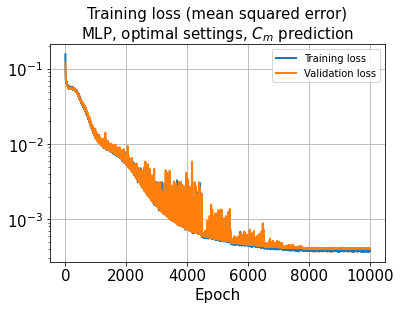

In [31]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

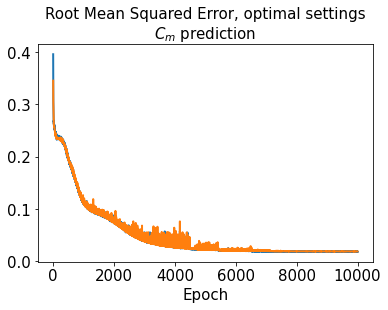

In [32]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

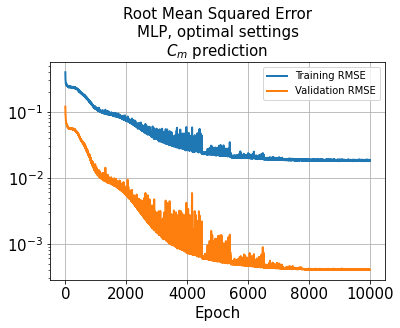

In [33]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [34]:
train_results = model.evaluate(x_train, y_train)

219/219 [==============================] - 1s 4ms/step - loss: 3.8396e-04 - rmse: 0.0182


In [35]:
val_results = model.evaluate(x_val, y_val)

63/63 [==============================] - 0s 4ms/step - loss: 4.0296e-04 - rmse: 0.0187


In [36]:
test_results = model.evaluate(x_test, y_test)

32/32 [==============================] - 0s 4ms/step - loss: 4.0933e-04 - rmse: 0.0189


In [37]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

32/32 [==============================] - 0s 1ms/step


In [38]:
decoded_train_

array([[0.12445027],
       [0.2912429 ],
       [0.02296148],
       ...,
       [0.27574366],
       [0.18308486],
       [0.5555148 ]], dtype=float32)

In [39]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [40]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [41]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [42]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [43]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [44]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [45]:
model_directory = "D:\\TrainedModels\\20221227"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221227unsteadyValidation_MLP_Flap1_2_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_randomState50CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [46]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [47]:
os.chdir(storage_dir)

In [48]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [49]:
l2_error_train = l2_error(decoded_train, y_train)
mape_train = smape(decoded_train, y_train)
print(l2_error_train)
print(mape_train)

0.05327538477583661
2.7508931960784238


In [50]:
l2_error_val = l2_error(decoded_val, y_val)
mape_val= smape(decoded_val, y_val)
print(l2_error_val)
print(mape_val)

0.05574556737826438
2.906583173123443


In [51]:
l2_error_test = l2_error(decoded_test, y_test)
mape_test= smape(decoded_test, y_test)
print(l2_error_test)
print(mape_test)

0.05538779991881001
2.849423737351556


In [52]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [53]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [54]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [55]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [56]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [57]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [58]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

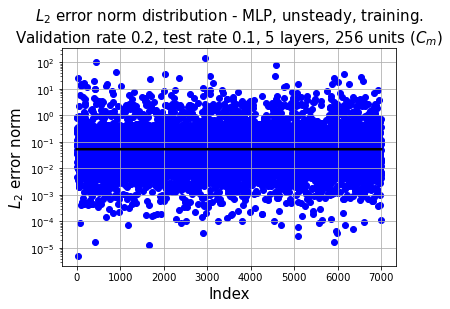

In [59]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

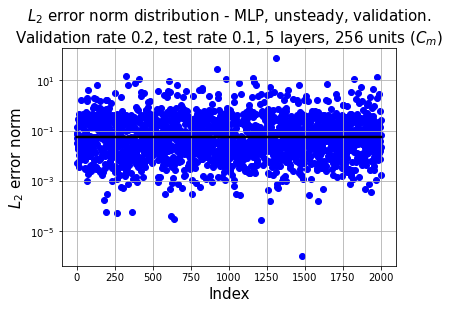

In [60]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

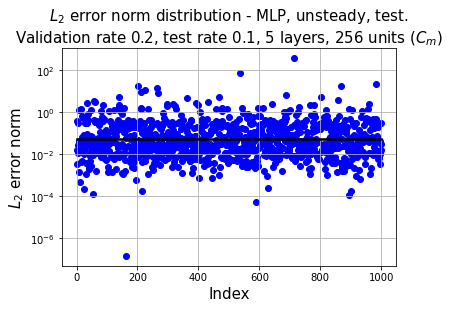

In [61]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [62]:
predicted = model.predict(x)

313/313 [==============================] - 1s 2ms/step


In [63]:
predicted.shape

(10000, 1)

In [91]:
l2_error(predicted, y)

0.04263180801136636

In [78]:
tTrain = x[index_train]+10
tVal = x[index_val]+10
tTest = x[index_test]+10

In [79]:
t_train

array([[10.   ],
       [10.001],
       [10.002],
       ...,
       [14.996],
       [14.997],
       [14.999]])

In [67]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [68]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [80]:
x += 10

In [84]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tTest, iTrain, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(x[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(x[:5000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [86]:
Cm

array([], shape=(0, 1), dtype=float64)

In [87]:
predicted

array([[0.08099103],
       [0.07610719],
       [0.08222316],
       ...,
       [0.10484898],
       [0.10484898],
       [0.09667686]], dtype=float32)

In [89]:
y[0]

array([0.07609022])

In [90]:
y[5000]

array([0.08941975])

L2 error of Cm: 0.0425


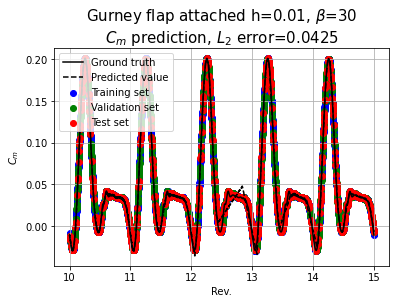

L2 error of Cm: 0.0428


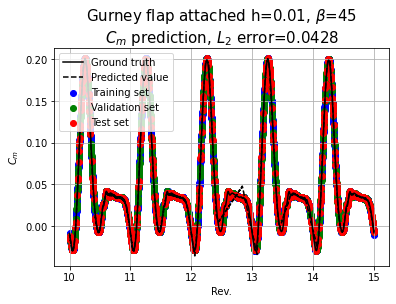

In [88]:
h = [0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [0, 30, 45, 30, 45, 30, 45, 90, 90, 90, 60, 60, 60, 75, 75, 75]
for i in range(1, 3):
    # Index from each dataset
#     iTrain = []
#     iVal = []
#     iTest = []
    
#     # Index from input data (alpha, in this case)
#     t_train = []
#     t_val = []
#     t_test = []
    
    predictedValue = predicted[t_len*(i-1):t_len*i,:]
    y_corres = y[t_len*(i-1):t_len*i,:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
#     for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
#         iTrain.append(predicted[index])
#     for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
#         iVal.append(predicted[index])    
#     for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
#         iTest.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
#     iTrain = np.array(iTrain)
#     iVal = np.array(iVal)
#     iTest = np.array(iTest)
    
#     for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
#         t_train.append(t[index])
#     for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
#         t_val.append(t[index])
#     for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
#         t_test.append(t[index])
        
#     tTrain = np.array(t_train)
#     tVal = np.array(t_val)
#     tTest = np.array(t_test)
    
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tTest, iTrain, iTest)

In [92]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm), 'b--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0425


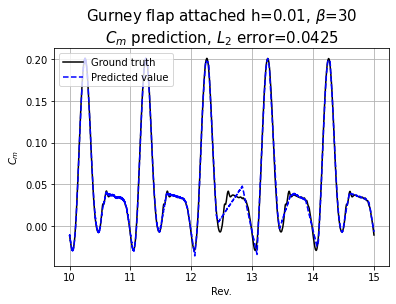

L2 error of Cm: 0.0428


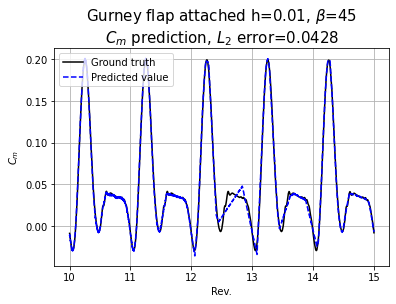

In [95]:
for i in range(1,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*(i-1):t_len*(i),:]
    y_corres = y[t_len*(i-1):t_len*(i),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [ ]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[1]) + r'$\beta$=%d'%(beta[1])+'\n$C_m$ prediction, training $L_2$ error=%.4f'%(l2_error_train)
title_Cm = title_n_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
# plt.scatter(tVal, iVal, color='g', label='Validation set')
# plt.scatter(tTest,iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [ ]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap attached h=%.2f, '%(h[1]) + r'$\beta$=%d'%(beta[1])+'\n$C_m$ prediction, validation $L_2$ error=%.4f'%(l2_error_val)
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#plt.scatter(tTest, iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [ ]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap attached h=%.2f, '%(h[1]) + r'$\beta$=%d'%(beta[1])+'\n$C_m$ prediction, test $L_2$ error=%.4f'%(l2_error_test)
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
#plt.scatter(tVal, iVal, color='g', label='Validation set')
plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()